# Analysis 3.0

## Install packages 

In [ ]:
pip install cycler

In [ ]:
pip install matplotlib

In [ ]:
pip install pyalex

In [ ]:
pip install gender_guesser

In [ ]:
pip install pycountry

In [ ]:
pip install mapclassify

In [ ]:
pip install geopandas

In [ ]:
pip install gensim

In [ ]:
pip install wordcloud

In [ ]:
pip install pyLDAvis

In [ ]:
pip install --upgrade nltk


In [ ]:
pip install --upgrade label-studio-converter

In [1762]:
pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.4 MB/s eta 0:00:00a 0:00:01m
Note: you may need to restart the kernel to use updated packages.


In [95]:
pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 3.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 2.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 6.7 MB/s eta 0:00:00ta 0:00:01
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=b68a6eb8bc382e0a7bdd6a6df3e87b17eb38b639c7d793f6d7ac21388fa664ee
  Stored in directory: /Users/signebendsen/Library/Caches/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma
Note: you may need to restart the kernel to use updated packages.


## Import packages

In [2]:
#general
import pandas as pd 
from cycler import cycler
import json
import numpy as np
import warnings
import pickle
from pprint import pprint
from datetime import date
import tqdm
from tqdm import tqdm
from itertools import cycle
from array import array
from sklearn import preprocessing
from scipy import stats

#for plotting
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
from lifelines import KaplanMeierFitter
from plotly import __version__
import plotly.io as pio
import plotly.offline as ply
ply.init_notebook_mode(connected=True)
pio.renderers.default = "browser"  # Switch to browser renderer

#for OpenAlex
import pyalex
from pyalex import Works, Authors, Sources, Institutions, Concepts, Publishers, Funders
from itertools import chain

#for Gender Guesser
from urllib.request import urlopen
import gender_guesser.detector as gender
import pycountry
import re

#for Geo things
import mapclassify
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from geotext import GeoText

#for topic model
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import *
from nltk.stem.porter import *

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim import corpora, models
from gensim.matutils import corpus2csc
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import CoherenceModel

from wordcloud import WordCloud
import scipy.interpolate.interpnd
import pyLDAvis
import pyLDAvis.gensim

In [7]:
#unwanted warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
#downloads 
nltk.download('omw-1.4')
nltk.download('wordnet')


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/signebendsen/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/signebendsen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Import data

In [4]:
%%time
with open('OpenAlex Data/Unify2024/05032024OriginalData.pkl', 'rb') as f:
    article_author_data_original = pickle.load(f)

CPU times: user 2.69 s, sys: 2.16 s, total: 4.85 s
Wall time: 6.29 s


In [47]:
%%time
with open('OpenAlex Data/Unify2024/05032024FinalData.pkl', 'rb') as f:
    article_author_data_final = pickle.load(f)

CPU times: user 2.26 s, sys: 3.14 s, total: 5.4 s
Wall time: 21 s


# Plotting

## Settings

In [9]:
#define colors

# Get the PuRd colormap
cmap = plt.get_cmap('PuRd')
num_colors = 10  # Number of colors
# Create a list of colors from the colormap
purd_colors = [cmap(i / num_colors) for i in range(num_colors)]


In [10]:
#plotting parameters
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.autolayout"] = True
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['tab:pink', 'tab:red', 'tab:purple', 'tab:blue', 'tab:cyan', 'tab:green', 'tab:olive', 'tab:orange', 'tab:brown', 'tab:gray']) 
plt.rcParams['axes.prop_cycle'] = cycler(color=purd_colors[3::])
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "serif"


font = {'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)


## Functions

In [11]:
def cat_plot(data, title=None, xlabel=None, ylabel='Frequency', norm=False, multiply=1, font=None, rot=0, xmargins=None, ymargins=None, save_name=None):
    """
    Create a categorical plot for a given DataFrame column.

    Parameters:
    - data (pd.Series): The input DataFrame column.
    - title (str): The title of the plot. Default is None.
    - xlabel (str): The label for the x-axis. Default is None.
    - ylabel(str): The label for the y-axis. Default is Frequency.
    - norm (bool): Whether to normalize data or not. Default is False.
    - multiply (int): Multiply data to achieve percentage. This should be 100 if norm=True. Default is 1.
    - rot (int): Rotation scale of x-tick-labels. Default is 0.
    - font (str): Font type. If Chinese letters, use: 'Heiti TC'. Default is None.
    - xmargins (int): The size of the x-margins. Default is None.
    - save_name (str): The name to use when saving the plot.

    Returns:
    - None
    """
    # count the number and/or percentage within each category
    value_counts = data.value_counts(normalize=norm).mul(multiply).reset_index()
    count_n = data.value_counts().reset_index()
    count_n = count_n.iloc[:, 1]
    count = value_counts.iloc[:, 1]
    cats = value_counts.iloc[:, 0]

    fig, ax = plt.subplots()
    bars = ax.bar(cats, count, width=0.8, alpha=0.6, edgecolor='white', label='Histogram of Data')

    # Add text on top of each bar if the number of bars is 5 or less
    if len(bars) <= 10:
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height, f'N={count_n.iloc[i]}', ha='center', va='bottom', color='black', fontsize=12)

    # Add text in the center of each bar if the bar percentage count is 2 percent or more and we have less than 10 categories
    for cat, c in zip(cats, count):
        if len(cats) <=10 and c >= 2:
            ax.text(cat, c / 2, f'{c:.1f}%', ha='center', va='center', color='white', fontsize=12)

    plt.xticks(cats, font=font, size=12, rotation=rot)
    plt.margins(x=xmargins, y=ymargins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    save_name = save_name
    save_path = f'Plots/{date.today()}/{save_name}{data.name}'
    plt.savefig(save_path)

    plt.show()


In [12]:

def cat_plot_compare(data1, data2, title=None, xlabel=None, ylabel='Frequency', norm=False, multiply=1, font=None, rot=0, xmargins=None, ymargins=None, save_name=None, label1='Dataset 1', label2='Dataset 2'):
    """
    Create a categorical plot for given DataFrame columns for comparison.

    Parameters:
    - data1 (pd.Series): The first input DataFrame column.
    - data2 (pd.Series): The second input DataFrame column.
    - title (str): The title of the plot. Default is None.
    - xlabel (str): The label for the x-axis. Default is None.
    - ylabel(str): The label for the y-axis. Default is Frequency.
    - norm (bool): Whether to normalize data or not. Default is False.
    - multiply (int): Multiply data to achieve percentage. This should be 100 if norm=True. Default is 1.
    - rot (int): Rotation scale of x-tick-labels. Default is 0.
    - font (str): Font type. If Chinese letters then use: 'Heiti TC'. Default is None.
    - xmargins (int): The size of the x-margins. Default is None.
    - save_name (str): The name to use when saving the plot.
    - label1 (str): Label for Dataset 1. Default is 'Dataset 1'.
    - label2 (str): Label for Dataset 2. Default is 'Dataset 2'.

    Returns:
    - None
    """
    # Merge data1 and data2 to ensure all categories are represented
    merged_data = pd.merge(data1, data2, how='outer', left_index=True, right_index=True, suffixes=('_df1', '_df2'))

    #count N without turning into percentage in both dataframes 
    count_n1 = merged_data[data1.name + '_df1'].value_counts().reset_index()
    count_n2 = merged_data[data2.name + '_df2'].value_counts().reset_index()

    # get value counts with the parameter normalize in order to be able to get percentage of both dataframes
    value_counts1 = merged_data[data1.name + '_df1'].value_counts(normalize=norm).mul(multiply).reset_index()
    value_counts2 = merged_data[data2.name + '_df2'].value_counts(normalize=norm).mul(multiply).reset_index()

    # Sort the value counts by category
    all_categories = set(value_counts1[data1.name + '_df1']).union(set(value_counts2[data2.name + '_df2']))
    value_counts1 = value_counts1.set_index(data1.name + '_df1').reindex(all_categories, fill_value=0).reset_index()
    count_n1 = count_n1.set_index(data1.name + '_df1').reindex(all_categories, fill_value=0).reset_index()
    value_counts2 = value_counts2.set_index(data2.name + '_df2').reindex(all_categories, fill_value=0).reset_index()
    count_n2 = count_n2.set_index(data2.name + '_df2').reindex(all_categories, fill_value=0).reset_index()

    #select either count or category column 
    count_n1 = count_n1.iloc[:, 1]
    count1 = value_counts1.iloc[:, 1]
    cats1 = value_counts1.iloc[:, 0]

    count2 = value_counts2.iloc[:, 1]
    count_n2 = count_n2.iloc[:, 1]
    cats2 = value_counts2.iloc[:, 0]

    width = 0.4  # width of the bars

    # Get integer positions for each category
    cat_positions1 = range(len(cats1))
    cat_positions2 = [pos + width + 0.01 for pos in cat_positions1]

    #define colors
    # Get the PuRd colormap
    cmap = plt.get_cmap('PuRd')
    num_colors = 10  # Number of colors
    # Create a list of colors from the colormap
    purd_colors = [cmap(i / num_colors) for i in range(num_colors)]
    color1=purd_colors[5]
    color2=purd_colors[3]

    fig, ax = plt.subplots()
    bars1=ax.bar(cat_positions1, count1, width, alpha=0.6, color=color1, edgecolor='white', label=label1)
    bars2=ax.bar(cat_positions2, count2, width, alpha=0.6, color=color2, edgecolor='white', label=label2)

    # Add text on top of each bar if the number of bars is 10 or less for both datasets and count is more than zero 
    if len(bars1) <= 10:
        for i, bar in enumerate(bars1):
            height = bar.get_height()
            if count_n1.iloc[i] > 0:
                ax.text(bar.get_x() + bar.get_width() / 2, height, f'N={count_n1.iloc[i]}', ha='center', va='bottom', color='black', fontsize=12)

    if len(bars2) <= 10:
        for i, bar in enumerate(bars2):
            height = bar.get_height()
            if count_n2.iloc[i] > 0:
                ax.text(bar.get_x() + bar.get_width() / 2, height, f'N={count_n2.iloc[i]}', ha='center', va='bottom', color='black', fontsize=12)


    # Add text in the center of each bar if the bar percentage count is 2 percent or more and we have less than 10 categories for both datasets
    for cat, c1, c2, bar1, bar2 in zip(all_categories, count1, count2, bars1, bars2):
        if len(cat) <= 10 and c1 >= 2:
            percentbar1 = c1
            ax.text(bar1.get_x() + bar1.get_width() / 2, c1 / 2, f'{percentbar1:.1f}%', ha='center', va='center', color='white', fontsize=12)
        if len(cat) <= 10 and c2 >= 2:
            percentbar2 = c2
            ax.text(bar2.get_x() + bar2.get_width() / 2, c2 / 2, f'{percentbar2:.1f}%', ha='center', va='center', color='white', fontsize=12)

    plt.xticks([pos + width / 2 for pos in cat_positions1], cats1, font=font, size=10, rotation=rot)
    plt.margins(x=xmargins, y=ymargins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

    save_path = f'Plots/{date.today()}/{str(save_name)}'
    plt.savefig(save_path)

    plt.show()

    plt.show()

In [13]:
short_names = []
full_names = []

def average_plot(avg, err, title=None, xlabel=None, ylabel=None, rot=0, full_names=full_names, short_names=short_names, add_means=False):
        # Create figure
        fig, ax = plt.subplots(figsize=(16,6))

        # Create short versions of names for x-ticks
        full_names = full_names
        short_names = short_names 

        #create legend labels
        legend_labels = [f'{short_names[i]}: {full_names[i]}' for i in range(len(full_names))]
        
        # X values are measurement number
        x = np.arange(len(avg))+1
        
        # Plot values and errorbars
        ax.scatter(x, avg, label=legend_labels)
        ax.errorbar(x, avg, err, fmt='o', color=purd_colors[8], ecolor=purd_colors[5], elinewidth=1, capsize=2, capthick=1)
        
        #Plot the weighted average line
        ax.hlines(avg.mean(), 0, len(x)+0.5, colors = purd_colors[5], linestyle = 'dashed')
        #plot extra average lines 
        if add_means:
                ax.hlines(avg_cites_domain.author_mean_cites.loc[0], 0, len(avg_cites_topics)+0.5, colors = purd_colors[9], linestyle = 'dashed')
                ax.text(-1.2, avg_cites_domain.author_mean_cites.loc[0]+5, 'Avg Research', color=purd_colors[9], size=8)
                ax.hlines(avg_cites_domain.author_mean_cites.loc[1], 0, len(avg_cites_topics)+0.5, colors = purd_colors[1], linestyle = 'dashed')
                ax.text(-1.2, avg_cites_domain.author_mean_cites.loc[1]-9, 'Avg Review', color=purd_colors[1], size=8)
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xticks(np.arange(1,len(avg)+1, 1))
        ax.set_xticklabels(short_names, size=10, rotation=rot)
        # Add legend manually without any handles
        # Create legend handles
        legend_handles = [(plt.Line2D([], [], color=purd_colors[8], marker="o", linewidth=0)) for x in legend_labels]
        # Manually create legend with handles and labels
        plt.legend(handles=legend_handles, labels=legend_labels, fontsize=10, loc='center right', bbox_to_anchor=(1.5, 0.5))
        ax.margins(x=0.1, y=0.1)
        fig.tight_layout()
        plt.show()

In [14]:

def cat_plot_compare_short_names(data1, data2, data3, title=None, xlabel=None, ylabel='Frequency', norm=False, multiply=1, font=None, rot=0, xmargins=None, ymargins=None, save_name=None, label1='Dataset 1', label2='Dataset 2'):
    """
    Create a categorical plot for given DataFrame columns for comparison.

    Parameters:
    - data1 (pd.Series): The first input DataFrame column.
    - data2 (pd.Series): The second input DataFrame column.
    - data3 (pd.Seris): Full label for name to print in legend. 
    - title (str): The title of the plot. Default is None.
    - xlabel (str): The label for the x-axis. Default is None.
    - ylabel(str): The label for the y-axis. Default is Frequency.
    - norm (bool): Whether to normalize data or not. Default is False.
    - multiply (int): Multiply data to achieve percentage. This should be 100 if norm=True. Default is 1.
    - rot (int): Rotation scale of x-tick-labels. Default is 0.
    - font (str): Font type. If Chinese letters then use: 'Heiti TC'. Default is None.
    - xmargins (int): The size of the x-margins. Default is None.
    - save_name (str): The name to use when saving the plot.
    - label1 (str): Label for Dataset 1. Default is 'Dataset 1'.
    - label2 (str): Label for Dataset 2. Default is 'Dataset 2'.

    Returns:
    - None
    """
    # Merge data1 and data2 to ensure all categories are represented
    merged_data = pd.merge(data1, data2,how='outer', left_index=True, right_index=True, suffixes=('_df1', '_df2'))

    #count N without turning into percentage in both dataframes 
    count_n1 = merged_data[data1.name + '_df1'].value_counts().reset_index()
    count_n2 = merged_data[data2.name + '_df2'].value_counts().reset_index()

    # get value counts with the parameter normalize in order to be able to get percentage of both dataframes
    value_counts1 = merged_data[data1.name + '_df1'].value_counts(normalize=norm).mul(multiply).reset_index()
    value_counts2 = merged_data[data2.name + '_df2'].value_counts(normalize=norm).mul(multiply).reset_index()

    # Sort the value counts by category
    all_categories = set(value_counts1[data1.name + '_df1']).union(set(value_counts2[data2.name + '_df2']))
    value_counts1 = value_counts1.set_index(data1.name + '_df1').reindex(all_categories, fill_value=0).reset_index()
    count_n1 = count_n1.set_index(data1.name + '_df1').reindex(all_categories, fill_value=0).reset_index()
    value_counts2 = value_counts2.set_index(data2.name + '_df2').reindex(all_categories, fill_value=0).reset_index()
    count_n2 = count_n2.set_index(data2.name + '_df2').reindex(all_categories, fill_value=0).reset_index()
    
    #select either count or category column 
    count_n1 = count_n1.iloc[:, 1]
    count1 = value_counts1.iloc[:, 1]
    cats1 = value_counts1.iloc[:, 0]

    count2 = value_counts2.iloc[:, 1]
    count_n2 = count_n2.iloc[:, 1]
    cats2 = value_counts2.iloc[:, 0]

    width = 0.4  # width of the bars

    # Get integer positions for each category
    cat_positions1 = range(len(cats1))
    cat_positions2 = [pos + width + 0.01 for pos in cat_positions1]

    #define colors
    # Get the PuRd colormap
    cmap = plt.get_cmap('PuRd')
    num_colors = 10  # Number of colors
    # Create a list of colors from the colormap
    purd_colors = [cmap(i / num_colors) for i in range(num_colors)]
    color1=purd_colors[5]
    color2=purd_colors[3]

    fig, ax = plt.subplots(figsize=(20,8))
    bars1=ax.bar(cat_positions1, count1, width, alpha=0.6, color=color1, edgecolor='white', label=label1)
    bars2=ax.bar(cat_positions2, count2, width, alpha=0.6, color=color2, edgecolor='white', label=label2)

    # Add text on top of each bar if the number of bars is 10 or less for both datasets and count is more than zero 
    if len(bars1) <= 10:
        for i, bar in enumerate(bars1):
            height = bar.get_height()
            if count_n1.iloc[i] > 0:
                ax.text(bar.get_x() + bar.get_width() / 2, height, f'N={count_n1.iloc[i]}', ha='center', va='bottom', color='black', fontsize=12)

    if len(bars2) <= 10:
        for i, bar in enumerate(bars2):
            height = bar.get_height()
            if count_n2.iloc[i] > 0:
                ax.text(bar.get_x() + bar.get_width() / 2, height, f'N={count_n2.iloc[i]}', ha='center', va='bottom', color='black', fontsize=12)


    # Add text in the center of each bar if the bar percentage count is 2 percent or more and we have less than 10 categories for both datasets
    for cat, c1, c2, bar1, bar2 in zip(all_categories, count1, count2, bars1, bars2):
        if len(cats1) <= 10 and c1 >= 2:
            percentbar1 = c1
            ax.text(bar1.get_x() + bar1.get_width() / 2, c1 / 2, f'{percentbar1:.1f}%', ha='center', va='center', color='white', fontsize=12)
        if len(cats2) <= 10 and c2 >= 2:
            percentbar2 = c2
            ax.text(bar2.get_x() + bar2.get_width() / 2, c2 / 2, f'{percentbar2:.1f}%', ha='center', va='center', color='white', fontsize=12)

    plt.xticks([pos + width / 2 for pos in cat_positions1], cats1, font=font, size=10, rotation=rot)
    #ax.set_xticklabels(cats1, size=10, rotation=rot)
    plt.margins(x=xmargins, y=ymargins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    #add extra legend 
    #get label to match with cats index
    cats1_df=pd.DataFrame(cats1)
    merge_labels=pd.merge(cats1_df, data3, left_on='topic_index_df1', right_on='topic_index')
    #crate manual labels 
    manual_legend_labels = [f'{merge_labels.topic_index[i]}: {merge_labels.topic_label[i]}' for i in range(len(merge_labels))]
    # Create legend handles
    manual_legend_handles = [(plt.Line2D([], [], marker=None, linewidth=0)) for x in manual_legend_labels]
    #create twin axis for double legend 
    ax2 = ax.twinx()
    ax2.plot(np.NaN, np.NaN)
    ax2.get_yaxis().set_visible(False)
    ax.legend()
    # Manually create legend with handles and labels
    ax2.legend(handles=manual_legend_handles, labels=manual_legend_labels, fontsize=10, loc='center right', bbox_to_anchor=(1.3, 0.5), handlelength=0)
    #auto_legend=
    #ax.add_artist(auto_legend)
    #ax.add_artist(manual_legend)
    save_path = f'Plots/{date.today()}/{str(save_name)}'
    plt.savefig(save_path)

    plt.show()


In [15]:
def cat_top_plot(data, top_n=10, title=None, xlabel=None, ylabel='Frequency', norm=False, multiply=1, font=None, rot=0, xmargins=None, ymargins=None, save_name=None):
    """
    Create a categorical plot for a given DataFrame column.

    Parameters:
    - data (pd.DataFrame): The input DataFrame column.
    - top_n (int): The number of top categories to display. Default is 10.
    - title (str): The title of the plot. Default is None.
    - xlabel (str): The label for the x-axis. Default is None.
    - ylabel(str): The label for the y-axis. Default is Frequncy.
    - norm(True/False): Whether to normalize data or not. Default is False.
    - multiply(int): Multiply data to achieve percentage. This should be 100 if norm=True. Default is 1.
    - rot(int): Rotation scale of x-tick-labels. Default is 0.
    - font(str): Font type. If Chinese letters, use: 'Heiti TC'. Default is None.
    - xmargins (int): The size of the x-margins. Default is None.

    Returns:
    - None
    """
    
    # count the number and/or percentage within each category and set the top categories that you would want
    top_n = top_n
    value_counts = data.value_counts(normalize=norm).mul(multiply).reset_index()[0:top_n]
    count_n = data.value_counts().reset_index()
    count_n = count_n.iloc[:, 1]
    count = value_counts.iloc[:, 1]
    cats = value_counts.iloc[:, 0]

    # Create plot
    fig, ax = plt.subplots()
    bars = ax.bar(cats, count, width=0.8, alpha=0.6, edgecolor='white', label='Histogram of Data')

    # Add text on top of each bar if the number of bars is 5 or less
    if len(bars) <= 10:
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height, f'N={count_n.iloc[i]}', ha='center', va='bottom', color='black', fontsize=12)

    # Add text in the center of each bar if the bar percentage count is 2 percent or more
    for cat, c in zip(cats, count):
        if len(cat) <=10 and c >= 2:
            ax.text(cat, c / 2, f'{c:.1f}%', ha='center', va='center', color='white', fontsize=12)

    plt.xticks(cats, font=font, size=10, rotation=rot)
    plt.margins(x=xmargins, y=ymargins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    save_name = save_name
    save_path = f'Plots/{date.today()}/{save_name}{data.name}'
    plt.savefig(save_path)

    plt.show()


In [16]:
short_names = [] #don't know if this will cause any issue

def cat_top_plot_short_names(data, top_n=10, title=None, xlabel=None, ylabel='Frequency', norm=False, multiply=1, font=None, rot=0, xmargins=None, save_name=None, legend_labels=None, short_names=short_names):
    """
    Create a categorical plot for a given DataFrame column.

    Parameters:
    - data (pd.DataFrame): The input DataFrame column.
    - top_n (int): The number of top categories to display. Default is 10.
    - title (str): The title of the plot. Default is None.
    - xlabel (str): The label for the x-axis. Default is None.
    - ylabel(str): The label for the y-axis. Default is Frequncy.
    - norm(True/False): Whether to normalize data or not. Default is False.
    - multiply(int): Multiply data to achieve percentage. This should be 100 if norm=True. Default is 1.
    - rot(int): Rotation scale of x-tick-labels. Default is 0.
    - font(str): Font type. If Chinese letters, use: 'Heiti TC'. Default is None.
    - xmargins (int): The size of the x-margins. Default is None.

    Returns:
    - None
    """
    
    # count the number and/or percentage within each category and set the top categories that you would want
    top_n = top_n
    value_counts = data.value_counts(normalize=norm).mul(multiply).reset_index()[0:top_n]
    count_n = data.value_counts().reset_index()
    count_n = count_n.iloc[:, 1]
    count = value_counts.iloc[:, 1]
    cats = value_counts.iloc[:, 0]

    # Create short versions of journal names for x-ticks
    short_names = short_names

    #create legend labels
    if legend_labels is None:
        legend_labels = [f'{short_names[i]}: {cats[i]}' for i in range(len(cats))]

    #create colors 
    num_colors = len(short_names)+3
    cmap = plt.get_cmap('PuRd')
    purd_colors = [cmap(i / num_colors) for i in range(num_colors)]

    # Create plot
    fig, ax = plt.subplots()
    bars = ax.bar(short_names, count, width=0.8, alpha=0.6, edgecolor='white',color=purd_colors[3::], label=legend_labels)

    # Add text on top of each bar if the number of bars is 5 or less
    if len(bars) <= 5:
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height, f'N={count_n.iloc[i]}', ha='center', va='bottom', color='black', fontsize=12)

    # Add text in the center of each bar if the bar percentage count is 2 percent or more and we have less than 10 categories
    for cat, short_name, c in zip(cats, short_names, count):
        if top_n <= 10 and c >= 2:
            ax.text(short_name, c / 2, f'{c:.1f}%', ha='center', va='center', color='white', fontsize=12)

    plt.xticks(short_names, font=font, size=10, rotation=rot)
    plt.margins(x=xmargins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title=None, fontsize=8, loc="upper right")

    save_name = save_name
    save_path = f'Plots/{date.today()}/{save_name}{data.name}'
    plt.savefig(save_path)

    plt.show()


In [17]:
short_names = [] #don't know if this will cause any issue

def cat_value_top_plot_short_names(data, sort_col='column', top_n=10, title=None, xlabel=None, ylabel='Frequency', norm=False, multiply=1, font=None, rot=0, xmargins=None, save_name=None, legend_labels=None, short_names=short_names):
    """
    Create a categorical plot for a given DataFrame column.

    Parameters:
    - data (pd.DataFrame): The input DataFrame column.
    - top_n (int): The number of top categories to display. Default is 10.
    - title (str): The title of the plot. Default is None.
    - xlabel (str): The label for the x-axis. Default is None.
    - ylabel(str): The label for the y-axis. Default is Frequncy.
    - norm(True/False): Whether to normalize data or not. Default is False.
    - multiply(int): Multiply data to achieve percentage. This should be 100 if norm=True. Default is 1.
    - rot(int): Rotation scale of x-tick-labels. Default is 0.
    - font(str): Font type. If Chinese letters, use: 'Heiti TC'. Default is None.
    - xmargins (int): The size of the x-margins. Default is None.

    Returns:
    - None
    """
    
    # count the number and/or percentage within each category and set the top categories that you would want
    top_n = top_n
    #sort values to be the top 
    data=data.sort_values(by=sort_col, ascending=False)
    #value_counts = data.value_counts(normalize=norm).mul(multiply).reset_index()[0:top_n]
    #count_n = data.value_counts().reset_index()
    #count_n = count_n.iloc[:, 1]
    #count = value_counts.iloc[:, 1]
    cats = data.iloc[:, 0][0:top_n]
    count= data.iloc[:, 1][0:top_n]

    # Create short versions of journal names for x-ticks
    short_names = short_names

    #create legend labels
    if legend_labels is None:
        legend_labels = [f'{short_names[i]}: {cats[i]}' for i in range(len(cats))]

    #create colors 
    num_colors = len(short_names)+3
    cmap = plt.get_cmap('PuRd')
    purd_colors = [cmap(i / num_colors) for i in range(num_colors)]

    # Create plot
    fig, ax = plt.subplots()
    bars = ax.bar(short_names, count, width=0.8, alpha=0.6, edgecolor='white',color=purd_colors[3::], label=legend_labels)

    # Add text on top of each bar if the number of bars is 5 or less
    if len(bars) <= 5:
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height, f'N={count_n.iloc[i]}', ha='center', va='bottom', color='black', fontsize=12)

    # Add text in the center of each bar if the bar percentage count is 2 percent or more and we have less than 10 categories
    for cat, short_name, c in zip(cats, short_names, count):
        if top_n <= 10 and c >= 2:
            ax.text(short_name, c / 2, f'{c:.1f}', ha='center', va='center', color='white', fontsize=12)

    plt.xticks(short_names, font=font, size=10, rotation=rot)
    plt.margins(x=xmargins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title=None, fontsize=8, loc="upper right")

    save_name = save_name
    save_path = f'Plots/{date.today()}/{save_name}'
    plt.savefig(save_path)

    plt.show()


In [18]:
def Sturges_bins(data):
    
    """
    INPUT:
    data = 1d array of all data
    
    OUTPUT:
    k = number of bins to use
    """
    
    # Number of data
    N = len(data)
    
    # Number of bins
    k = int( np.ceil( np.log2(N) ) + 1 )
    
    return k

In [19]:
def hist_plot(data, N_bins=None, log=False, title=None, xlabel=None, ylabel='Frequency', xmargins=None, save_name=None, legend_labels=None, disp_legend=True):
    """
    Create a histogram for given DataFrame columns.

    Parameters:
    - data (List[pd.Series]): List of input DataFrame columns.
    - log (True/False): Plot on log scale. Default is False.
    - title (str): The title of the plot. Default is None.
    - xlabel (str): The label for the x-axis. Default is None.
    - ylabel (str): The label for the y-axis. Default is 'Frequency'.
    - xmargins (int): The size of the x-margins. Default is None.
    - save_name (str): The name to use when saving the plot.
    - legend_labels (List[str]): List of legend labels for each dataset. Default is None.
    
    Returns:
    - None
    """

    fig, ax = plt.subplots()

    if len(data) == 2:
        colors = [purd_colors[7], purd_colors[3]]
    else:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    if legend_labels is None:
        legend_labels = [f'Data {i + 1}' for i in range(len(data))]

    for i, (column_data, legend_label, color) in enumerate(zip(data, legend_labels, colors)):
        # Extract values from histogram and outline data
        if N_bins is None:
            N_bins = Sturges_bins(data[0])
        counts, bin_edges, _ = ax.hist(column_data, bins=N_bins, log=log, alpha=0.6, color=color, edgecolor='white', label=legend_label)
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        binwidth = bin_edges[1] - bin_edges[0]

        # Poisson errors on the count in each bin
        s_counts = np.sqrt(counts)

        # We remove any bins, which don't have any counts in them:
        x = bin_centers[counts > 0]
        y = counts[counts > 0]
        sy = s_counts[counts > 0]

        # Plot data with error
        ax.errorbar(x, y, yerr=sy, fmt='.', color='k', ecolor='k', elinewidth=1, capsize=1, capthick=1)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.margins(x=xmargins)

    if disp_legend is True:
        ax.legend()

    save_path = f'Plots/{date.today()}/{save_name}'
    plt.savefig(save_path)

    plt.show()

In [20]:

def stacked_bar_plot_normalized(dataframe, x_col, y_cols, title=None, xlabel=None, ylabel=None, xmargins=None, ymargins=None, save_name=None):
    """
    Generate a stacked bar plot for normalized gender distribution over years.

    Parameters:
    - dataframe: DataFrame containing the data.
    - year_col: Column name for the years.
    - gender_cols: List of column names representing different gender categories.
    - title: Title of the plot. Default is None.
    - xlabel: Label for the x-axis. Default is None.
    - ylabel: Label for the y-axis. Default is None.
    """

    # Calculate the total count per year
    total_counts = dataframe[y_cols].sum(axis=1)

    # Normalize the data to percentages
    normalized_df = dataframe.copy()
    for y_col in y_cols:
        normalized_df[y_col] = (normalized_df[y_col] / total_counts) * 100

    # Initialize the bottom values for stacking
    bottom_values = [0] * len(normalized_df)
    # initialize the height values for stacking
    height_values = []

    # create colors
    num_colors = 20
    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i / num_colors) for i in range(num_colors)]
    reversed_colors = list(reversed(colors))
    selected_colors = [reversed_colors[i] for i in [0, 2, 4, 5, 7]]

    fig, ax = plt.subplots()
    for i, y_col in enumerate(y_cols):
        color = selected_colors[i]
        bars = ax.bar(normalized_df[x_col], normalized_df[y_col], bottom=bottom_values, edgecolor='white', color=color, alpha=0.7, label=y_col)
        bottom_values = [bottom + value for bottom, value in zip(bottom_values, normalized_df[y_col])]
        height_values.extend([bottom for bottom in bottom_values])

    # Add text on top of each bar if the number of bars is 5 or less
    if len(bars) <= 5:
        for i, bar in enumerate(bars):
            height = 100
            ax.text(bar.get_x() + bar.get_width() / 2, 100, f'N={total_counts.iloc[i]}', ha='center', va='bottom', color='black', fontsize=12)

    # Create an iterator from the height list
    height_iterator = cycle(height_values)

    # Iterate through the columns (categories) of normalized_df[y_col]
    for i, y_col in enumerate(y_cols):
        for j, bars in enumerate(ax.patches[i::len(y_cols)]):
            val = normalized_df[y_col].iloc[j]
            # Manually set x position
            x_position = np.sort([bars.get_x() for bars in ax.patches[i::len(y_cols)]])
            x_position = [x_position[i] for i in range(len(x_position))]
            custom_x = x_position[j]

            # Add text for each category at the appropriate height if val >= 5
            if val >= 5 and len(x_position) <=5:
                # Use the next value from the iterator as the current_height
                current_height = next(height_iterator)
                ax.text(custom_x + bars.get_width() / 2, current_height-1, f'{val:.1f}%', ha='center', va='top', color='white', fontsize=10)
            else:
                # Skip updating the iterator if the condition is not met
                next(height_iterator)

    # Adding labels and title
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)
    plt.margins(x=xmargins, y=ymargins)
    plt.legend(fontsize=12)

    save_name = save_name
    save_path = f'Plots/{date.today()}/{[name for name, obj in globals().items() if obj is dataframe][0]}{save_name}'
    plt.savefig(save_path)

    # Display the plot
    plt.show()


In [21]:
def stacked_bar_plot_normalized_compare(dataframes, x_col, y_cols, title=None, xlabel=None, ylabel=None, xmargins=None, ymargins=None, save_name=None, labels=None):
    """
    Generate a stacked bar plot for normalized gender distribution over years.

    Parameters:
    - dataframes: List of DataFrames containing the data.
    - x_col: Column name for the years.
    - y_cols: List of column names representing different gender categories.
    - title: Title of the plot. Default is None.
    - xlabel: Label for the x-axis. Default is None.
    - ylabel: Label for the y-axis. Default is None.
    - xmargins: The size of the x-margins. Default is None.
    - ymargins: The size of the y-margins. Default is None.
    - save_name: The name to use when saving the plot.
    - labels: List of labels for each DataFrame in dataframes.

    Returns:
    - None
    """
    # Find the common set of publication years across all dataframes
    common_years = set(dataframes[0][x_col])
    for df in dataframes[1:]:
        common_years.intersection_update(df[x_col])

    # Filter each dataframe to include only the common years
    dataframes_filtered = [df[df[x_col].isin(common_years)] for df in dataframes]

    fig, ax = plt.subplots()

    # Create colors
    num_colors = 20
    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i / num_colors) for i in range(num_colors)]
    reversed_colors = list(reversed(colors))
    selected_colors = [reversed_colors[i] for i in [0, 2, 4, 5, 7]]

    for i, df in enumerate(dataframes_filtered):
        # Normalize the data to percentages
        normalized_df = df.copy()
        total_col_name = 'total'
    
        # Calculate total within the function for the given y_cols
        normalized_df[total_col_name] = normalized_df[y_cols].sum(axis=1)

        
        for y_col in y_cols:
            normalized_df[y_col] = (normalized_df[y_col] / normalized_df['total']) * 100

        # Create an iterator for colors
        color_iterator = cycle(selected_colors)
        
        # Initialize the bottom values for stacking within the same DataFrame
        bottom_values = [0] * len(normalized_df)

        for j, y_col in enumerate(y_cols):
            color = next(color_iterator)
            x_values = np.arange(len(common_years)) + i * 0.2
            bars = ax.bar(x_values, normalized_df[y_col], bottom=bottom_values, edgecolor='white', color=color, alpha=0.7, width=0.4, label=f'{labels[i]} - {y_col}')
            
            # Update bottom values for stacking within the same DataFrame
            bottom_values = [bottom + value for bottom, value in zip(bottom_values, normalized_df[y_col])]

    # Adding labels and title
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)
    plt.margins(x=xmargins, y=ymargins)
    plt.legend(fontsize=12)

    if save_name:
        save_path = f'Plots/{date.today()}/{save_name}'
        plt.savefig(save_path)

    # Display the plot
    plt.show()


In [22]:
def scatter_plot(x, y, title=None, xlabel=None, ylabel=None, label=None, font='font', xmargins=None, new_figure=True, save_name=None):
    """
    Create a plot between two variables for two given lists of numbers.

    Parameters:
    - x (list): The input x data.
    - y (list): The input y data.
    - title (str): The title of the plot. Default is None.
    - xlabel (str): The label for the x-axis. Default is None.
    - ylabel(str): The label for the y-axis. Default is Frequncy.
    - font(str): font type. If Chinese letters then use: 'Heiti TC'. Default is 'font'.
    - xmargins (float): The margins for the x-axis. Default is None.
    - new_figure (bool): Whether to create a new figure or plot in the same figure. Default is True.

    Returns:
    - None
    """
    if new_figure:
        fig, ax = plt.subplots()
    else:
        fig, ax = plt.gcf(), plt.gca()

    ax.plot(x, y, '.')
    plt.margins(x=xmargins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    save_name = save_name
    save_path = f'Plots/{date.today()}/{save_name}'
    plt.savefig(save_path)

    plt.show()


In [23]:
def plot_with_twiny(x1, x2, y, title=None, xlabel1=None, xlabel2=None, ylabel=None, norm_separate=False, norm_together=False, multiply=1, font=None, xmargins=None, ymargins=None, legend_loc='best', save_name=None):
    """
    Create a scatter plot with twin x-axis.

    Parameters:
    - x (pd.Series): The input DataFrame column for x-axis.
    - y1 (pd.Series): The input DataFrame column for primary y-axis.
    - y2 (pd.Series): The input DataFrame column for secondary y-axis.
    - title (str): The title of the plot. Default is None.
    - xlabel (str): The label for the x-axis. Default is None.
    - ylabel1(str): The label for the primary y-axis. Default is None.
    - ylabel2(str): The label for the secondary y-axis. Default is None.
    - norm (bool): Whether to normalize data or not. Default is False.
    - multiply (int): Multiply data to achieve percentage. This should be 100 if norm=True. Default is 1.
    - font (str): Font type. If Chinese letters, use: 'Heiti TC'. Default is None.
    - xmargins (int): The size of the x-margins. Default is None.
    - ymargins (int): The size of the y-margins. Default is None.
    - save_name (str): The name to use when saving the plot.

    Returns:
    - fig (matplotlib.figure.Figure): The matplotlib figure object.
    """
    if norm_separate:
        x1 = np.abs(pd.Series(preprocessing.normalize(x1.values.reshape(-1, 1), axis=0).flatten()))
        x2 = np.abs(pd.Series(preprocessing.normalize(x2.values.reshape(-1, 1), axis=0).flatten()))
    
    if norm_together:
        total_sum = abs(x1.sum()) + abs(x2.sum())
        x1 = x1 / total_sum * multiply
        x2 = x2 / total_sum * multiply


    fig, ax1 = plt.subplots()

    #create colors 
    num_colors = 3
    cmap = plt.get_cmap('PuRd')
    purd_colors = [cmap(i / num_colors) for i in range(num_colors)]

    line1, = ax1.plot(x1, y, '.-', markersize=8, color=purd_colors[1], label=xlabel1)
    ax1.set_ylabel(ylabel)
    ax1.set_xlabel(xlabel1, color=purd_colors[1])
    ax1.tick_params(axis='x', labelcolor=purd_colors[1])
    
    line2, = ax1.plot(x2, y, '.-', markersize=8, color=purd_colors[2], label=xlabel2)
    ax2 = ax1.twiny()  
    ax2.set_xlabel(xlabel2, color=purd_colors[2])
    ax2.tick_params(axis='x', labelcolor=purd_colors[2])


    # Combine the line handles and labels for the legend
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]

    plt.title(title)
    plt.margins(x=xmargins, y=ymargins)
    plt.grid(True, zorder=0)
    legend_loc=legend_loc
    plt.legend(lines, labels, loc=legend_loc)

    save_name = save_name
    save_path = f'Plots/{pd.Timestamp.now().strftime("%Y-%m-%d")}/{save_name}'
    plt.savefig(save_path)


    return fig

In [24]:
def plot_with_twinx(x, y1, y2, title=None, xlabel=None, ylabel1=None, ylabel2=None, norm_separate=False, norm_together=False, multiply=1, plot_min_max=True, font=None, xmargins=None, ymargins=None, legend_loc='best', save_name=None):
    """
    Create a scatter plot with twin x-axis.

    Parameters:
    - x (pd.Series): The input DataFrame column for x-axis.
    - y1 (pd.Series): The input DataFrame column for primary y-axis.
    - y2 (pd.Series): The input DataFrame column for secondary y-axis.
    - title (str): The title of the plot. Default is None.
    - xlabel (str): The label for the x-axis. Default is None.
    - ylabel1(str): The label for the primary y-axis. Default is None.
    - ylabel2(str): The label for the secondary y-axis. Default is None.
    - norm (bool): Whether to normalize data or not. Default is False.
    - multiply (int): Multiply data to achieve percentage. This should be 100 if norm=True. Default is 1.
    - font (str): Font type. If Chinese letters, use: 'Heiti TC'. Default is None.
    - xmargins (int): The size of the x-margins. Default is None.
    - ymargins (int): The size of the y-margins. Default is None.
    - save_name (str): The name to use when saving the plot.

    Returns:
    - fig (matplotlib.figure.Figure): The matplotlib figure object.
    """
    if norm_separate:
        y1 = np.abs(pd.Series(preprocessing.normalize(y1.values.reshape(-1, 1), axis=0).flatten()))
        y2 = np.abs(pd.Series(preprocessing.normalize(y2.values.reshape(-1, 1), axis=0).flatten()))
    
    if norm_together:
        total_sum = abs(y1.sum()) + abs(y2.sum())
        y1 = y1 / total_sum * multiply
        y2 = y2 / total_sum * multiply


    fig, ax1 = plt.subplots()

    #create colors 
    num_colors = 3
    cmap = plt.get_cmap('PuRd')
    purd_colors = [cmap(i / num_colors) for i in range(num_colors)]

    line1, = ax1.plot(x, y1, '.-', markersize=8, color=purd_colors[1], label=ylabel1)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel1, color=purd_colors[1])
    ax1.tick_params(axis='y', labelcolor=purd_colors[1])
    
    line2, = ax1.plot(x, y2, '.-', markersize=8, color=purd_colors[2], label=ylabel2)
    ax2 = ax1.twinx()  
    ax2.set_ylabel(ylabel2, color=purd_colors[2])
    ax2.tick_params(axis='y', labelcolor=purd_colors[2])

    if plot_min_max:
    # Find minimum perplexity score and corresponding x-value
        min_perplexity_idx = np.argmin(y1)
        min_perplexity_x = x[min_perplexity_idx]

    # Find maximum coherence score and corresponding x-value
        max_coherence_idx = np.argmax(y2)
        max_coherence_x = x[max_coherence_idx]

        ax1.plot(min_perplexity_x, y1[min_perplexity_idx], 'x', color=purd_colors[1], markersize=14, label='Min Perplexity')
        ax1.text(min_perplexity_x-13, y1[min_perplexity_idx]-0.2, 'Min Perplexity', color=purd_colors[1], size=10)
        ax1.plot(max_coherence_x, y2[max_coherence_idx], 'x', color=score_colors[2], markersize=14, label='Max Coherence')
        ax1.text(max_coherence_x-3, y2[max_coherence_idx]-2, 'Max Coherence', color=purd_colors[2], size=10)



    # Combine the line handles and labels for the legend
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]

    plt.title(title)
    plt.margins(x=xmargins, y=ymargins)
    plt.grid(True, zorder=0)
    legend_loc=legend_loc
    plt.legend(lines, labels, loc=legend_loc)

    save_name = save_name
    save_path = f'Plots/{pd.Timestamp.now().strftime("%Y-%m-%d")}/{save_name}'
    plt.savefig(save_path)


    return fig

In [25]:


def cat_top_plot_dual_axis(data1, data2, top_n=10, title=None, xlabel=None, ylabel1='Frequency', ylabel2='Frequency', norm=False, multiply=1, font=None, rot=0, xmargins=None, ymargins=None, label1=None, label2=None, save_name=None):
    # count the number and/or percentage within each category and set the top categories that you would want
    value_counts1 = data1.value_counts(normalize=norm).mul(multiply).reset_index().iloc[:top_n]
    count_n1 = data1.value_counts().reset_index()
    count_n1 = count_n1.iloc[:, 1]
    count1 = value_counts1.iloc[:, 1]
    cats1 = value_counts1.iloc[:, 0]

    value_counts2 = data2.value_counts(normalize=norm).mul(multiply).reset_index().iloc[:top_n]
    count_n2 = data2.value_counts().reset_index()
    count_n2 = count_n2.iloc[:, 1]
    count2 = value_counts2.iloc[:, 1]
    cats2 = value_counts2.iloc[:, 0]

    #create colors 
    num_colors = 10
    cmap = plt.get_cmap('PuRd')
    purd_colors = [cmap(i / num_colors) for i in range(num_colors)]
    color1 = purd_colors[3]
    color2 = purd_colors[5]

    #set bar width
    width = 0.4

    # Create plot
    fig, ax1 = plt.subplots()
    ax1.set_ylabel(ylabel1, color=color1)
    bars1 = ax1.bar(cats1, count1, width=width, color=color1, alpha=0.6, edgecolor='white', label='Dataset 1')
    ax1.tick_params(axis='y', labelcolor=color1)

    # Add text on top of each bar if the number of bars is 5 or less
    #if len(bars1) <= 10:
        #for i, bar in enumerate(bars1):
           # height = bar.get_height()
           # ax1.text(bar.get_x() + bar.get_width() / 2, height, f'N={count_n1.iloc[i]}', ha='center', va='bottom', color='black', fontsize=10)

    # Add text in the center of each bar if the bar percentage count is 2 percent or more
    #for cat, c in zip(cats1, count1):
        #if len(cat) <=10 and c >= 2:
            #ax1.text(cat, c / 2, f'{c:.1f}%', ha='center', va='center', color='white', fontsize=12)

    # Creating a second y-axis on the right
    ax2 = ax1.twinx()
    ax2.set_ylabel(ylabel2, color=color2)
    bars2 = ax2.bar(np.arange(len(cats2)) + width, count2, width=width, color=color2, alpha=0.6, edgecolor='white', label='Dataset 2')
    ax2.tick_params(axis='y', labelcolor=color2)

    # Add text on top of each bar if the number of bars is 5 or less
    #if len(bars2) <= 10:
        #for i, bar in enumerate(bars2):
           # height = bar.get_height()
            #ax2.text(bar.get_x() + bar.get_width() / 2, height, f'N={count_n2.iloc[i]}', ha='center', va='bottom', color='black', fontsize=10)

    # Add text in the center of each bar if the bar percentage count is 2 percent or more
    #for cat, c in zip(cats2, count2):
        #if len(cat) <=10 and c >= 2:
            #ax2.text(cat, c / 2, f'{c:.1f}%', ha='center', va='center', color='white', fontsize=12)

    # Combine legends for both datasets with distinct colors
    legend_patches = [Patch(color=color1, alpha=0.6, label=label1), Patch(color=color2, alpha=0.6, label=label2)]
    plt.legend(handles=legend_patches, loc='best')

    plt.title(title)
    ax1.set_xticks(np.arange(len(cats2)) + width /2)
    ax1.xaxis.set_ticklabels([])

    for i, label in enumerate(cats1):
        ax1.text(i-0.01, -0.04, label, color=color1, ha='center', size=12, transform=ax1.get_xaxis_transform())
    for i, label in enumerate(cats2):
        ax1.text(i + width, -0.08, label.capitalize(), color=color2, ha='center', size=12, transform=ax1.get_xaxis_transform())

    plt.margins(x=xmargins, y=ymargins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel1)  # Assuming both y-axes should have the same label

    # Save the plot if save_name is provided
    if save_name:
        save_path = f'Plots/{date.today()}/{save_name}.png'
        plt.savefig(save_path)

    plt.show()

In [26]:

def plot_topic_weights(dataframe):
    # Assuming 'data' is a DataFrame with the given structure
    # Extract topics and weights for each row
    data = dataframe.topic_words
    topics_data = data.apply(lambda x: pd.Series(x.split(' + ')))
    topics_label = dataframe.topic_label

    # Create a figure with subplots
    num_rows = len(topics_data)
    
    for i, row in enumerate(topics_data.index):
        fig, ax = plt.subplots(figsize=(12, 6))  # Create a new figure for each row
        
        row_data = topics_data.loc[row].apply(lambda x: pd.Series(x.strip().split('*')))
        topics = row_data[1].apply(lambda x: x.strip('"'))
        weights = row_data[0].astype(float)
        topic_label = topics_label[i]

        ax.bar(topics, weights, alpha=0.6)
        ax.set_title(f'Topic {row}: {topic_label}')
        ax.set_ylabel('Weight')
        ax.set_xlabel('Words')
        ax.tick_params(axis='x', which='major', labelrotation=20, labelsize=12)

        plt.tight_layout()
        
        # Save the figure under the topic label name
        save_path = f'Plots/{date.today()}/{topic_label}.png'
        plt.savefig(save_path)
        
        plt.show()


In [27]:
short_names = [] #don't know if this will cause any issue

def cat_plot_short_names(data, title=None, xlabel=None, ylabel='Frequency', norm=False, multiply=1, font=None, rot=0, xmargins=None, save_name=None, legend_labels=None, short_names=short_names):
    """
    Create a categorical plot for a given DataFrame column.

    Parameters:
    - data (pd.DataFrame): The input DataFrame column.
    - top_n (int): The number of top categories to display. Default is 10.
    - title (str): The title of the plot. Default is None.
    - xlabel (str): The label for the x-axis. Default is None.
    - ylabel(str): The label for the y-axis. Default is Frequncy.
    - norm(True/False): Whether to normalize data or not. Default is False.
    - multiply(int): Multiply data to achieve percentage. This should be 100 if norm=True. Default is 1.
    - rot(int): Rotation scale of x-tick-labels. Default is 0.
    - font(str): Font type. If Chinese letters, use: 'Heiti TC'. Default is None.
    - xmargins (int): The size of the x-margins. Default is None.

    Returns:
    - None
    """
    
    # count the number and/or percentage within each category and set the top categories that you would want
    value_counts = data.value_counts(normalize=norm).mul(multiply).reset_index()
    count_n = data.value_counts().reset_index()
    count_n = count_n.iloc[:, 1]
    count = value_counts.iloc[:, 1]
    cats = value_counts.iloc[:, 0]

    # Create short versions of journal names for x-ticks
    short_names = short_names

    #create legend labels
    if legend_labels is None:
        legend_labels = [f'{short_names[i]}: {cats[i]}' for i in range(len(cats))]

    #create colors 
    num_colors = len(short_names)+3
    cmap = plt.get_cmap('PuRd')
    purd_colors = [cmap(i / num_colors) for i in range(num_colors)]

    # Create plot
    fig, ax = plt.subplots()
    bars = ax.bar(short_names, count, width=0.8, alpha=0.6, edgecolor='white',color=purd_colors[3::], label=legend_labels)

    # Add text on top of each bar if the number of bars is 5 or less
    if len(bars) <= 5:
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height, f'N={count_n.iloc[i]}', ha='center', va='bottom', color='black', fontsize=12)

    # Add text in the center of each bar if the bar percentage count is 2 percent or more and we have less than 10 categories
    for cat, short_name, c in zip(cats, short_names, count):
        if len(short_name) <= 10 and c >= 2:
            ax.text(short_name, c / 2, f'{c:.0f}%', ha='center', va='center', color='white', fontsize=11)

    plt.xticks(short_names, font=font, size=10, rotation=rot)
    plt.margins(x=xmargins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title=None, fontsize=8, loc="upper right")

    save_name = save_name
    save_path = f'Plots/{date.today()}/{save_name}{data.name}'
    plt.savefig(save_path)

    plt.show()


In [28]:
def hist2D(x_data, y_data, xlabel=None, ylabel=None, title=None, save_name=None):
    # Calculate max count
    max_count = max(x_data.max(), y_data.max())
        
    # Plot 2D histogram
    plt.figure(figsize=(9, 6))
    plt.hist2d(x_data, y_data, cmap='PuRd', alpha=0.7, bins=[np.arange(-0.5, max_count + 1.5, 1), np.arange(-0.5, max_count + 1.5, 1)])
    plt.colorbar()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    save_name = save_name
    save_path = f'Plots/{date.today()}/{save_name}'
    plt.savefig(save_path)
    
    plt.show()


In [29]:

def hist2D_author_gender_counts(article_author_data_final, total_authors_range, save_name=None):
    for total_authors in range(2, total_authors_range + 1):
        # Filter data for the specified total number of authors
        article_author_data_filtered = article_author_data_final[article_author_data_final['total_author_counts'] == total_authors].copy()
        
        # Remove author duplicates
        article_author_data_filtered.drop_duplicates(subset='author_id', keep='first', inplace=True)
        
        # Count the number of male/female authors per article
        binary_gender_article_counts = article_author_data_filtered.groupby(['article_id', 'binary_gender']).size().unstack(fill_value=0).reset_index()
        
        # Calculate max count
        max_count = max(binary_gender_article_counts['female'].max(), binary_gender_article_counts['male'].max())
        
        # Plot 2D histogram
        plt.figure(figsize=(9, 6))
        plt.hist2d(binary_gender_article_counts['female'], binary_gender_article_counts['male'], cmap='PuRd', alpha=0.7, bins=[np.arange(-0.5, max_count + 1.5, 1), np.arange(-0.5, max_count + 1.5, 1)])
        plt.xticks(np.arange(0, max_count + 1, 1))
        plt.yticks(np.arange(0, max_count + 1, 1))
        plt.title(f'Collaborations Between Male/Female Authors for {total_authors} Total Authors', pad=20)
        plt.xlabel('Female Authors')
        plt.ylabel('Male Authors')
        plt.colorbar(label='Frequency')

        save_name = save_name
        save_path = f'Plots/{date.today()}/{save_name}{total_authors}'
        plt.savefig(save_path)
        
        plt.show()



In [30]:
def hist2D_author_gender_counts_by_topic(data, save_name=None):
    # Group data by topic_label
    grouped_data = data.groupby('topic_label')
    
    for topic_label, topic_data in grouped_data:
        # Remove author duplicates
        topic_data.drop_duplicates(subset='author_id', keep='first', inplace=True)
        
        # Count the number of male/female authors per article
        binary_gender_article_counts = topic_data.groupby(['article_id', 'binary_gender']).size().unstack(fill_value=0).reset_index()
        
        # Map counts greater than 6 to 7
        binary_gender_article_counts['female'] = binary_gender_article_counts['female'].apply(lambda x: x if x <= 6 else 7)
        binary_gender_article_counts['male'] = binary_gender_article_counts['male'].apply(lambda x: x if x <= 6 else 7)
        
        # Plot 2D histogram
        plt.figure(figsize=(9, 6))
        plt.hist2d(binary_gender_article_counts['female'], binary_gender_article_counts['male'], cmap='PuRd', alpha=0.7, bins=[np.arange(-0.5, 8, 1), np.arange(-0.5, 8, 1)])
        plt.xticks(np.arange(0, 8, 1))
        plt.yticks(np.arange(0, 8, 1))
        plt.title(f'Collaborations Between Male/Female Authors for Topic: {topic_label}', pad=20)
        plt.xlabel('Female Authors')
        plt.ylabel('Male Authors')
        plt.colorbar(label='Frequency')

        save_name = save_name
        save_path = f'Plots/{date.today()}/{save_name}_{topic_label}'
        plt.savefig(save_path)
        
        plt.show()


In [31]:
short_names = []
full_names = []

def average_plot(avg, err, title=None, xlabel=None, ylabel=None, rot=0, full_names=full_names, short_names=short_names, add_means=False, save_name=None):
        # Create figure
        fig, ax = plt.subplots(figsize=(16,6))

        # Create short versions of names for x-ticks
        full_names = full_names
        short_names = short_names 

        #create legend labels
        legend_labels = [f'{short_names[i]}: {full_names[i]}' for i in range(len(full_names))]
        
        # X values are measurement number
        x = np.arange(len(avg))+1
        
        # Plot values and errorbars
        ax.scatter(x, avg, label=legend_labels)
        ax.errorbar(x, avg, err, fmt='o', color=purd_colors[8], ecolor=purd_colors[5], elinewidth=1, capsize=2, capthick=1)
        
        #Plot the weighted average line
        ax.hlines(avg.mean(), 0, len(x)+0.5, colors = purd_colors[5], linestyle = 'dashed')
        #plot extra average lines 
        if add_means:
                ax.hlines(avg_cites_domain.author_mean_cites.loc[0], 0, len(avg_cites_topics)+0.5, colors = purd_colors[9], linestyle = 'dashed')
                ax.text(-1.2, avg_cites_domain.author_mean_cites.loc[0]+5, 'Avg Research', color=purd_colors[9], size=8)
                ax.hlines(avg_cites_domain.author_mean_cites.loc[1], 0, len(avg_cites_topics)+0.5, colors = purd_colors[1], linestyle = 'dashed')
                ax.text(-1.2, avg_cites_domain.author_mean_cites.loc[1]-9, 'Avg Review', color=purd_colors[1], size=8)
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xticks(np.arange(1,len(avg)+1, 1))
        ax.set_xticklabels(short_names, size=10, rotation=rot)
        # Add legend manually without any handles
        # Create legend handles
        legend_handles = [(plt.Line2D([], [], color=purd_colors[8], marker="o", linewidth=0)) for x in legend_labels]
        # Manually create legend with handles and labels
        plt.legend(handles=legend_handles, labels=legend_labels, fontsize=10, loc='center right', bbox_to_anchor=(1.5, 0.5))
        ax.margins(x=0.1, y=0.1)
        fig.tight_layout()

        save_name = save_name
        save_path = f'Plots/{date.today()}/{save_name}'
        plt.savefig(save_path)
    
        plt.show()

In [32]:

def plot_ranking_scatter(x_data, y_data, label_data, xlabel=None, ylabel=None, title=None, save_name=None):
    """
    Plot a scatter plot of 'institution_ranking' vs 'journal_ranking' with annotations for each point.

    Args:
    data (pd.DataFrame): DataFrame containing 'institution_ranking', 'journal_ranking', and 'topic_label' columns.

    Returns:
    None
    """
    plt.figure(figsize=(12, 10))
    plt.scatter(x_data, y_data)

    # Annotate each point with its corresponding topic label
    for i, label in enumerate(label_data):
        plt.annotate(label, (x_data[i], y_data[i]), textcoords="offset points", xytext=(5,5), ha='center', size=10)

    # Add labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()

    save_name = save_name
    save_path = f'Plots/{date.today()}/{save_name}'
    plt.savefig(save_path)
    
    plt.show()


In [33]:
def survival_plot(data, event, title=None, xlabel=None, ylabel=None, save_name=None):
    # Initialize KaplanMeierFitter
    kmf = KaplanMeierFitter()

    # fit the Kaplan-Meier estimator to data
    kmf.fit(data, event_observed=event)

    # Plot 
    kmf.plot_survival_function()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    save_name = save_name
    save_path = f'Plots/{date.today()}/{save_name}'
    plt.savefig(save_path)

    
    plt.show()


In [34]:
def survival_compare_plot(data1, event1, data2, event2, label1=None, label2=None, title=None, xlabel=None, ylabel=None, save_name=None):
    # Initialize KaplanMeierFitter
    kmf = KaplanMeierFitter()

    #fit the first data 
    kmf.fit(data1, event_observed=event1, label=label1)
    # Plot the survival function for the first data
    kmf.plot_survival_function()

    # Fit the second data
    kmf.fit(data2, event_observed=event2, label=label2)
    #plot the second data
    kmf.plot_survival_function()

    # Add title and labels to the plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    save_name = save_name
    save_path = f'Plots/{date.today()}/{save_name}'
    plt.savefig(save_path)

    
    plt.show()


In [35]:

def plot_survival_by_group(data, group_data, title=None, xlabel=None, ylabel=None, legend_title=None, save_name=None):
    """
    Plot the survival function of author career length for each topic.

    Args:
    data (pd.DataFrame): DataFrame containing 'career_span_years', 'event_observed', and 'topic_label' columns.

    Returns:
    None
    """
    # Initialize Kaplan-Meier fitter
    kmf = KaplanMeierFitter()

    # Get unique groups labels
    groups = group_data.unique()

    # Create a plot
    plt.figure(figsize=(15, 8))

    # Get number of unique topics
    num_groups = len(groups)

    # Get a colormap
    cmap = plt.get_cmap('PuRd')

    # Loop through each topic and generate a color
    for i, group in enumerate(groups):
        # Fit the Kaplan-Meier estimator for the current topic
        kmf.fit(data['career_span_years'][group_data == group],
                event_observed=data['event_observed'][group_data == group],
                label=group)

        # Get color from the colormap
        color = cmap(i + 3 / num_groups)

        # Plot the survival function for the current topic with the generated color
        kmf.plot_survival_function(color=color)

    # Add title and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Show the plot
    plt.legend(title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.tight_layout()

    save_name = save_name
    save_path = f'Plots/{date.today()}/{save_name}'
    plt.savefig(save_path)
    
    plt.show()



In [36]:


def plot_survival_by_domain_compare(data, gender, cmap, save_name=None):
    """
    Plot the survival function of author career length for each topic within a specified gender.

    Args:
    data (pd.DataFrame): DataFrame containing 'career_span_years', 'event_observed', and 'domain' columns.
    gender (str): Gender value ('male' or 'female') to filter the data.
    cmap (str): Colormap name for the gender-specific plot.

    Returns:
    None
    """
    # Initialize Kaplan-Meier fitter
    kmf = KaplanMeierFitter()

    # Get unique topic labels
    topics = data['domain'].unique()

    # Get number of unique topics
    num_topics = len(topics)

    # Get a colormap
    cmap = plt.get_cmap(cmap)

    # Loop through each topic and generate a color
    for i, topic in enumerate(topics):
        # Fit the Kaplan-Meier estimator for the current topic
        kmf.fit(data['career_span_years'][data['domain'] == topic],
                event_observed=data['event_observed'][data['domain'] == topic],
                label=f'{topic} ({gender.capitalize()})')

        # Get color from the colormap
        color = cmap(i / num_topics)

        # Plot the survival function for the current topic with the generated color
        kmf.plot_survival_function(color=color)

    # Add title and labels
    plt.title(f'Survival Function of Author Career Length by Domain for {gender.capitalize()} Authors')
    plt.xlabel('Years')
    plt.ylabel('Probability of Survival')

    save_name = save_name
    save_path = f'Plots/{date.today()}/{save_name}'
    plt.savefig(save_path)




# Analysis

In [37]:
#total length
print("N original data:", len(article_author_data_original))
print("N clean data:", len(article_author_data_final))

NameError: name 'article_author_data_original' is not defined

In [35]:
#distinct articles length
print("N unique articles original data:", len(article_author_data_original.drop_duplicates(subset=['article_id'], keep='first')))
print("N unique articles clean data:", len(article_author_data_final.drop_duplicates(subset=['article_id'], keep='first')))

N unique articles original data: 518351
N unique articles clean data: 470034


In [36]:
#distinct authors length
print("N unique authors original data:", len(article_author_data_original.drop_duplicates(subset=['author_id'], keep='first')))
print("N unique authors clean data:", len(article_author_data_final.drop_duplicates(subset=['author_id'], keep='first')))

N unique authors original data: 810843
N unique authors clean data: 676613


In [37]:
#create new column with only binary gender so female/male 
article_author_data_final['binary_gender']=article_author_data_final['predicted_gender']
article_author_data_final['binary_gender']=article_author_data_final['binary_gender'].replace({'mostly_male': 'male'})
article_author_data_final['binary_gender']=article_author_data_final['binary_gender'].replace({'mostly_female': 'female'})
# set unknown as nan
article_author_data_final['binary_gender'].replace('unknown', np.nan, inplace=True)



In [38]:
#create new column with author first country 
article_author_data_original['author_first_country'] = article_author_data_original['author_countries'].apply(lambda x: x[0] if len(x[0])==2 else x)
article_author_data_final['author_first_country'] = article_author_data_final['author_countries'].apply(lambda x: x[0] if len(x[0])==2 else x)


In [39]:
#check for duplicates where both article and author id is repeated
TESTING=article_author_data_final[article_author_data_final.duplicated(subset=['article_id', 'author_id'])]


In [40]:
TESTINGTEST = TESTING.groupby(['article_id', 'author_id']).size().reset_index()



In [41]:
TESTINGTEST=TESTINGTEST.rename(columns={0:'author_id_count'})

In [42]:
TESTINGTEST[TESTINGTEST.author_id_count!=1]

article_id                         author_id  \
894   https://openalex.org/W2064011380  https://openalex.org/A5081725032   
1343  https://openalex.org/W2149219031  https://openalex.org/A5053470582   
3384  https://openalex.org/W4200038538  https://openalex.org/A9999999999   
3392  https://openalex.org/W4200112190  https://openalex.org/A9999999999   
3402  https://openalex.org/W4200186499  https://openalex.org/A9999999999   
...                                ...                               ...   
4311  https://openalex.org/W4308447026  https://openalex.org/A5092268898   
4344  https://openalex.org/W4310040167  https://openalex.org/A5060811147   
4390  https://openalex.org/W4312413957  https://openalex.org/A5041640890   
4523  https://openalex.org/W4361008314  https://openalex.org/A5060811147   
4730  https://openalex.org/W4386351485  https://openalex.org/A5057647276   

      author_id_count  
894                 3  
1343                3  
3384                4  
3392                8  
3402                2  
...               ...  
4311                5  
4344                2  
4390                2  
4523                2  
4730                2  

[80 rows x 3 columns]

In [138]:
# we need to drop the duplicates from our data in both original and final dataframe 
article_author_data_final[['article_id', 'author_id', 'title', 'extracted_first_name']][article_author_data_final.article_id=='https://openalex.org/W2149219031']

article_id                         author_id  \
187604  https://openalex.org/W2149219031  https://openalex.org/A5067713609   
187605  https://openalex.org/W2149219031  https://openalex.org/A5053470582   
187606  https://openalex.org/W2149219031  https://openalex.org/A5053470582   
187607  https://openalex.org/W2149219031  https://openalex.org/A5056730783   
187608  https://openalex.org/W2149219031  https://openalex.org/A5082769830   
187609  https://openalex.org/W2149219031  https://openalex.org/A5025121409   
187610  https://openalex.org/W2149219031  https://openalex.org/A5062087838   
187611  https://openalex.org/W2149219031  https://openalex.org/A5020884388   
187612  https://openalex.org/W2149219031  https://openalex.org/A5072915206   
187613  https://openalex.org/W2149219031  https://openalex.org/A5072915206   
187614  https://openalex.org/W2149219031  https://openalex.org/A5053470582   
187615  https://openalex.org/W2149219031  https://openalex.org/A5053470582   
187616  https://openalex.org/W2149219031  https://openalex.org/A5067962829   
187617  https://openalex.org/W2149219031  https://openalex.org/A5005193873   
187618  https://openalex.org/W2149219031  https://openalex.org/A5038793726   
187619  https://openalex.org/W2149219031  https://openalex.org/A5064906494   

                                                    title extracted_first_name  
187604  Status of and prospects for advanced tokamak r...             emanuele  
187605  Status of and prospects for advanced tokamak r...                   yu  
187606  Status of and prospects for advanced tokamak r...                   yu  
187607  Status of and prospects for advanced tokamak r...                 j.e.  
187608  Status of and prospects for advanced tokamak r...                 e.j.  
187609  Status of and prospects for advanced tokamak r...                 v.a.  
187610  Status of and prospects for advanced tokamak r...             masahiro  
187611  Status of and prospects for advanced tokamak r...       'steady-state'  
187612  Status of and prospects for advanced tokamak r...                   yu  
187613  Status of and prospects for advanced tokamak r...                   yu  
187614  Status of and prospects for advanced tokamak r...                   yu  
187615  Status of and prospects for advanced tokamak r...                   yu  
187616  Status of and prospects for advanced tokamak r...              y.-k.m.  
187617  Status of and prospects for advanced tokamak r...              hiroshi  
187618  Status of and prospects for advanced tokamak r...               eiichi  
187619  Status of and prospects for advanced tokamak r...                  jan

# Original Data

In [879]:
original_data_distinct_author=article_author_data_original.drop_duplicates(subset=['author_id'], keep='first')

In [894]:
original_data_distinct_author.author_country_name

0               united states
1          russian federation
2          russian federation
3          russian federation
4               united states
                  ...        
2000275                 japan
2000276                turkey
2000277       other_countries
2000278       other_countries
2000279       other_countries
Name: author_country_name, Length: 810843, dtype: object

In [926]:
andy_country=original_data_distinct_author.author_country_name[original_data_distinct_author.predicted_gender=='andy']
andy_country=andy_country.replace({'other_countries': 'Other', 'united states': 'USA', 'united kingdom': 'UK', 'china': 'China',
                                  'canada': 'Canada', 'germany': 'Germany', 'australia':'Australia', 'france': 'France',
                                  'brazil':'Brazil', 'indonesia':'Indonesia'})
andy_name=original_data_distinct_author.extracted_first_name[original_data_distinct_author.predicted_gender=='andy']


In [933]:
unknown_country=original_data_distinct_author.author_country_name[original_data_distinct_author.predicted_gender=='unknown']
unknown_country=unknown_country.replace({'other_countries': 'Other', 'united states': 'USA', 'united kingdom': 'UK', 'china': 'China',
                                  'canada': 'Canada', 'germany': 'Germany', 'australia':'Australia', 'france': 'France', 'italy':'Italy',
                                  'brazil':'Brazil', 'indonesia':'Indonesia', 'russian federation': 'Russia', 'india':'India'})
unknown_name=original_data_distinct_author.extracted_first_name[original_data_distinct_author.predicted_gender=='unknown']

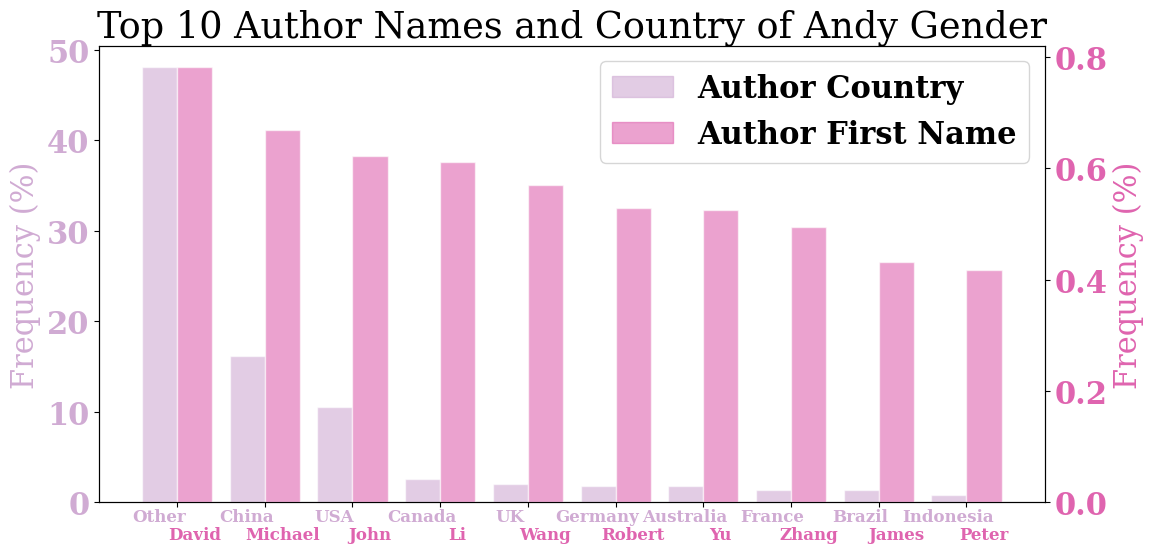

In [928]:
cat_top_plot_dual_axis(andy_country, andy_name, title='Top 10 Author Names and Country of Andy Gender', xlabel=None, norm=True, multiply=100, ylabel1='Frequency (%)', ylabel2='Frequency (%)', label1='Author Country', label2='Author First Name', save_name='top_10_andy')
#last thing is just to add country full name rather than short name - but let's look into that later 
#the frequency is out of total ANDY genders 

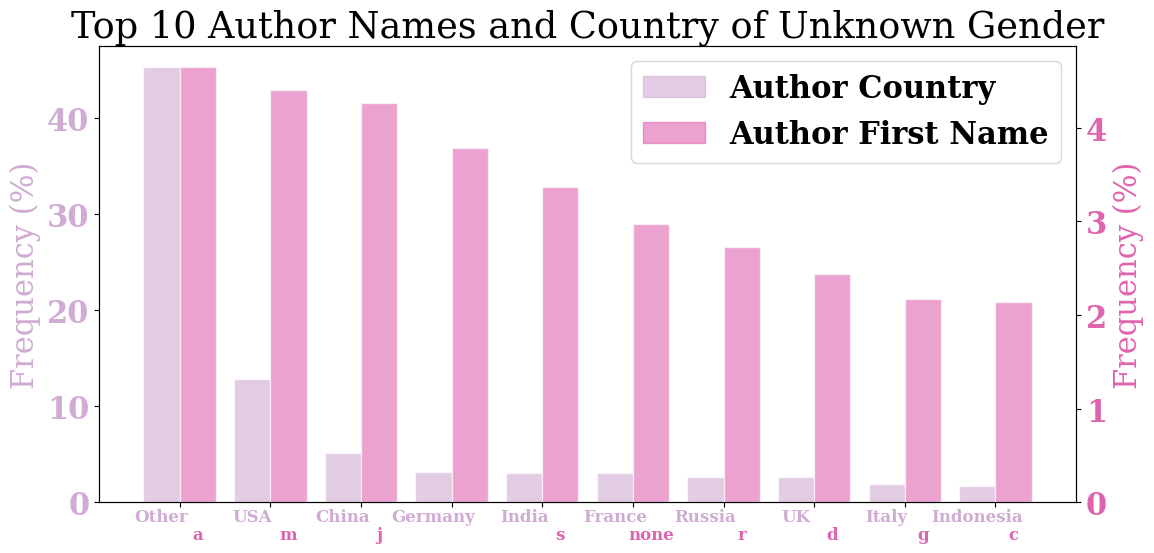

In [934]:
cat_top_plot_dual_axis_test(unknown_country, unknown_name, title='Top 10 Author Names and Country of Unknown Gender', xlabel=None, norm=True, multiply=100, ylabel1='Frequency (%)', ylabel2='Frequency (%)', label1='Author Country', label2='Author First Name', save_name='top_10_unknown')


## Before and after updates

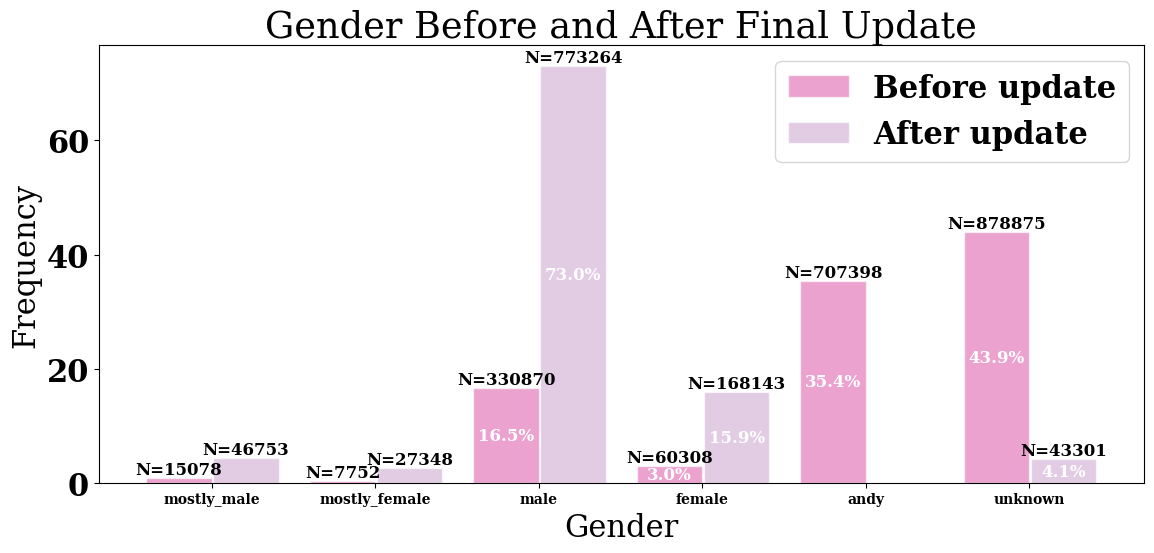

In [203]:
#show the result of the final update compared to original data
cat_plot_compare(article_author_data_original.predicted_gender, article_author_data_final.predicted_gender, title='Gender Before and After Final Update', xlabel='Gender', ylabel='Frequency', norm=True, multiply=100, font=font, rot=0, xmargins=None, save_name='genderupdatefinal', label1='Before update', label2='After update')


In [204]:
#ensure that ratios er still aligned before and after updates 
prct_gender_original=article_author_data_original.predicted_gender.value_counts(normalize=True).mul(100)
prct_gender_final=article_author_data_final.predicted_gender.value_counts(normalize=True).mul(100)


In [208]:
#female
female_original=prct_gender_original['female']+prct_gender_original['mostly_female']
female_final=prct_gender_final['female']+prct_gender_final['mostly_female']
#male
male_original=prct_gender_original['male']+prct_gender_original['mostly_male']
male_final=prct_gender_final['male']+prct_gender_final['mostly_male']


In [210]:
female_original/male_original*100

19.673476938730676

In [211]:
female_final/male_final*100

23.83987161241779

# Final Data 

## Collaborations 

In [31]:
# 2D histogram

In [70]:
binary_gender_article_counts = article_author_data_final.groupby(['article_id', 'binary_gender']).size().unstack(fill_value=0).reset_index()


In [71]:
binary_gender_article_counts['total']=binary_gender_article_counts['female']+binary_gender_article_counts['male']

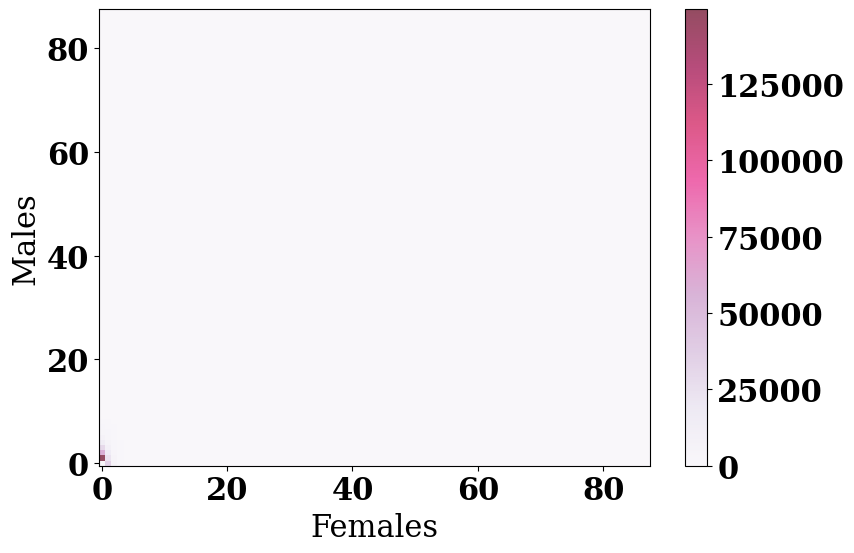

In [589]:
hist2D(binary_gender_article_counts['female'], binary_gender_article_counts['male'], xlabel='Females', ylabel='Males', title=None, save_name='2dhistbasic')


In [53]:
#udvælg udsnit hvor der ses en effekt det vil sige når N authors < 10 
#derfor kigger vi på udsnit af 4x4 hvor 4 eller større ryger i 4 plus (vi kalder den 5 her) 

In [196]:
binary_gender_article_counts_window=binary_gender_article_counts.copy()

In [197]:
binary_gender_article_counts_window['total'][binary_gender_article_counts_window['total']>4]=5

/var/folders/23/_5nwl30d12q_2dv4hhpqjfl00000gn/T/ipykernel_46419/1601406330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_gender_article_counts_window['total'][binary_gender_article_counts_window['total']>4]=5


In [198]:
#we also need to set the max authors to be 7+ 
binary_gender_article_counts_window['male'][binary_gender_article_counts_window['male']>4]=5
binary_gender_article_counts_window['female'][binary_gender_article_counts_window['female']>4]=5

/var/folders/23/_5nwl30d12q_2dv4hhpqjfl00000gn/T/ipykernel_46419/3923924034.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_gender_article_counts_window['male'][binary_gender_article_counts_window['male']>4]=5
/var/folders/23/_5nwl30d12q_2dv4hhpqjfl00000gn/T/ipykernel_46419/3923924034.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_gender_article_counts_window['female'][binary_gender_article_counts_window['female']>4]=5


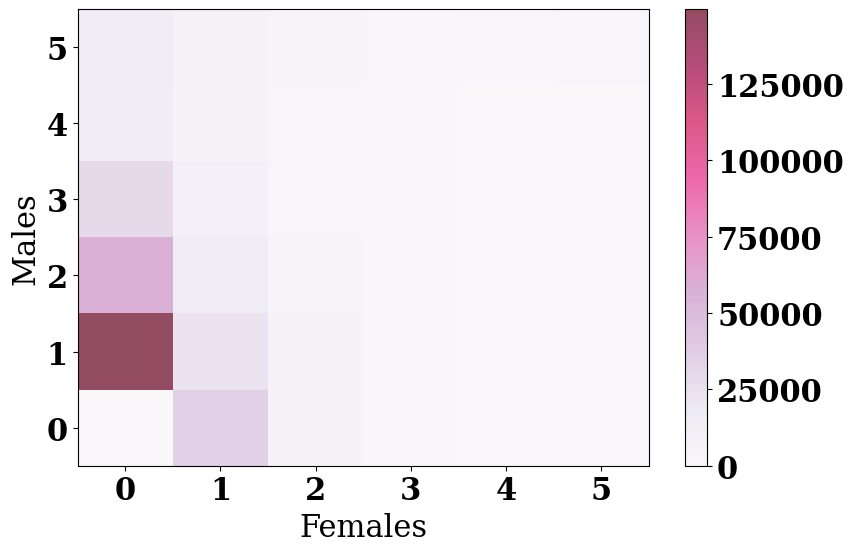

In [590]:
hist2D(binary_gender_article_counts_window['female'], binary_gender_article_counts_window['male'], xlabel='Females', ylabel='Males', title=None, save_name='2dhistbasicwindow6+')


In [96]:
# look at articles with a given number of total authors

In [196]:
topics_binary_gender_article_counts_window=binary_gender_article_counts.copy()

In [197]:
binary_gender_article_counts_window['total'][binary_gender_article_counts_window['total']>4]=5

/var/folders/23/_5nwl30d12q_2dv4hhpqjfl00000gn/T/ipykernel_46419/1601406330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_gender_article_counts_window['total'][binary_gender_article_counts_window['total']>4]=5


In [198]:
#we also need to set the max authors to be 7+ 
binary_gender_article_counts_window['male'][binary_gender_article_counts_window['male']>4]=5
binary_gender_article_counts_window['female'][binary_gender_article_counts_window['female']>4]=5

/var/folders/23/_5nwl30d12q_2dv4hhpqjfl00000gn/T/ipykernel_46419/3923924034.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_gender_article_counts_window['male'][binary_gender_article_counts_window['male']>4]=5
/var/folders/23/_5nwl30d12q_2dv4hhpqjfl00000gn/T/ipykernel_46419/3923924034.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_gender_article_counts_window['female'][binary_gender_article_counts_window['female']>4]=5


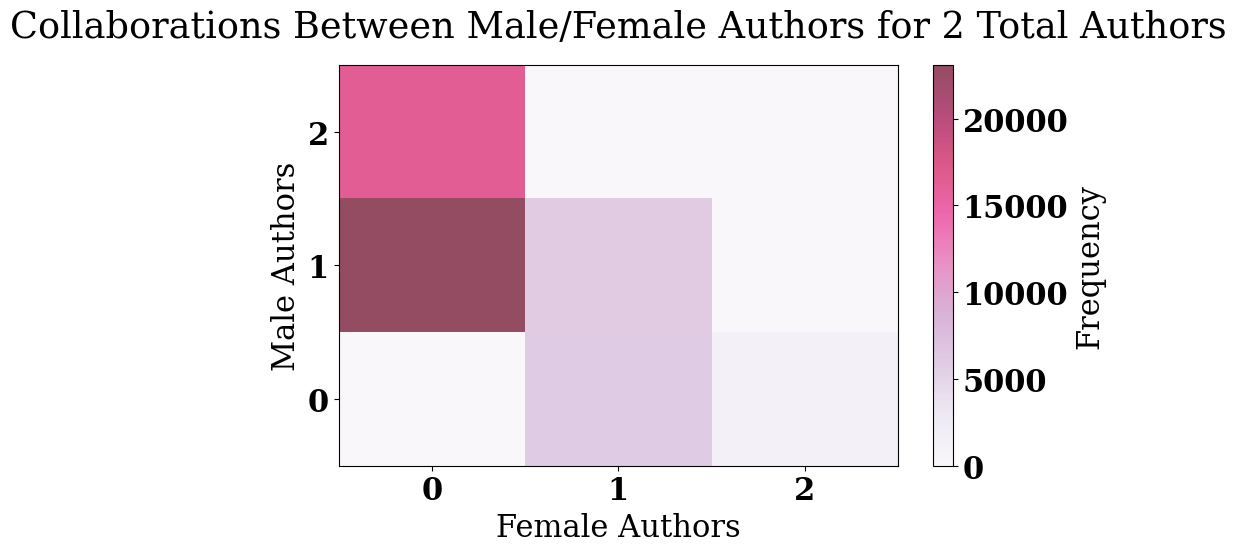

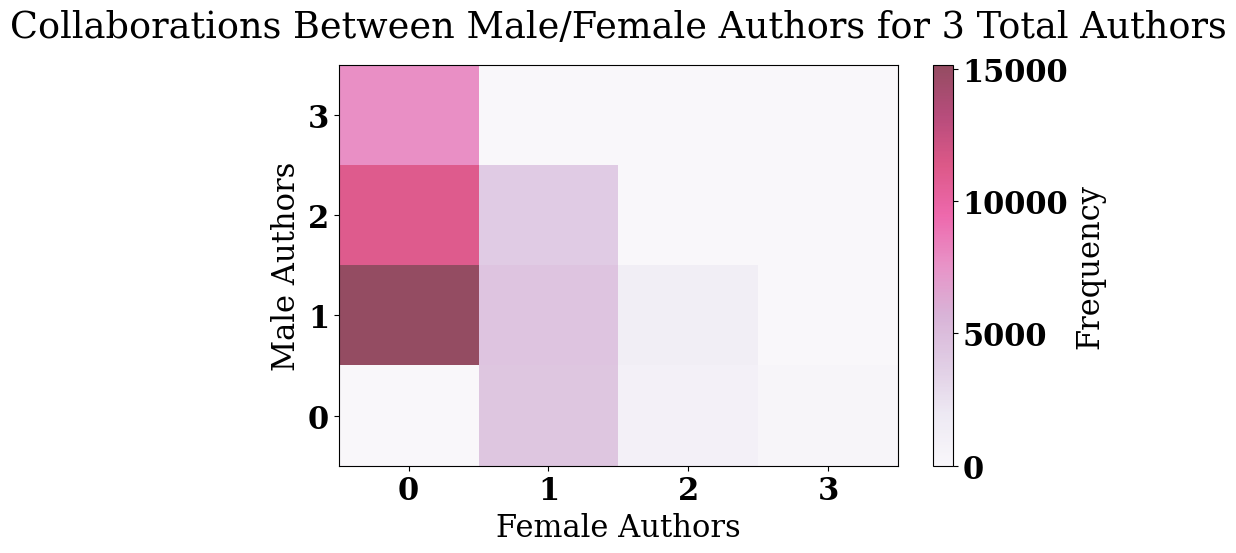

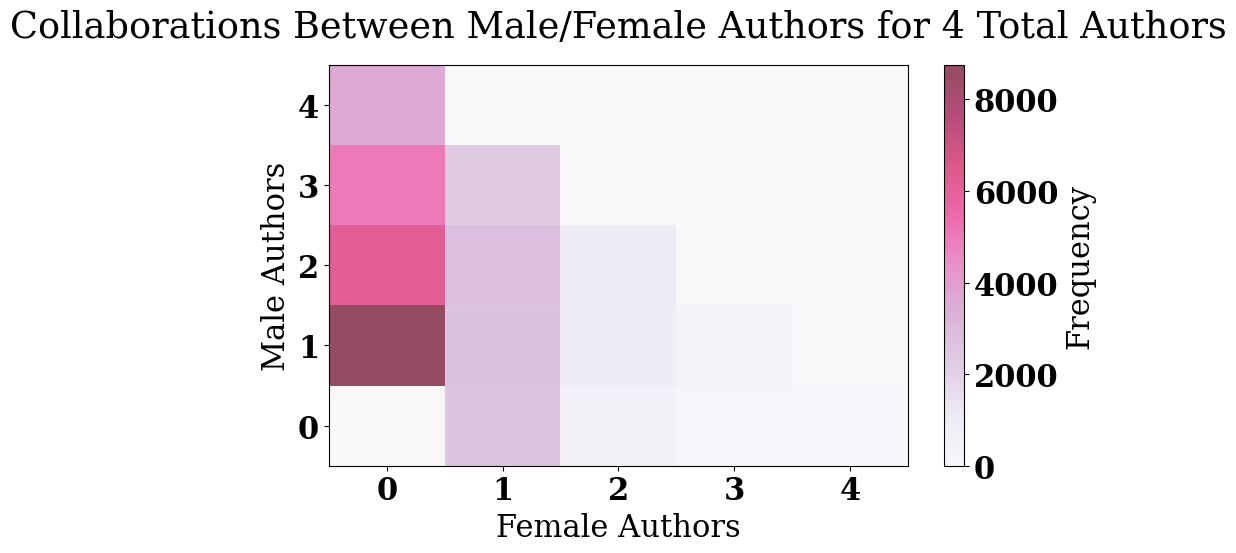

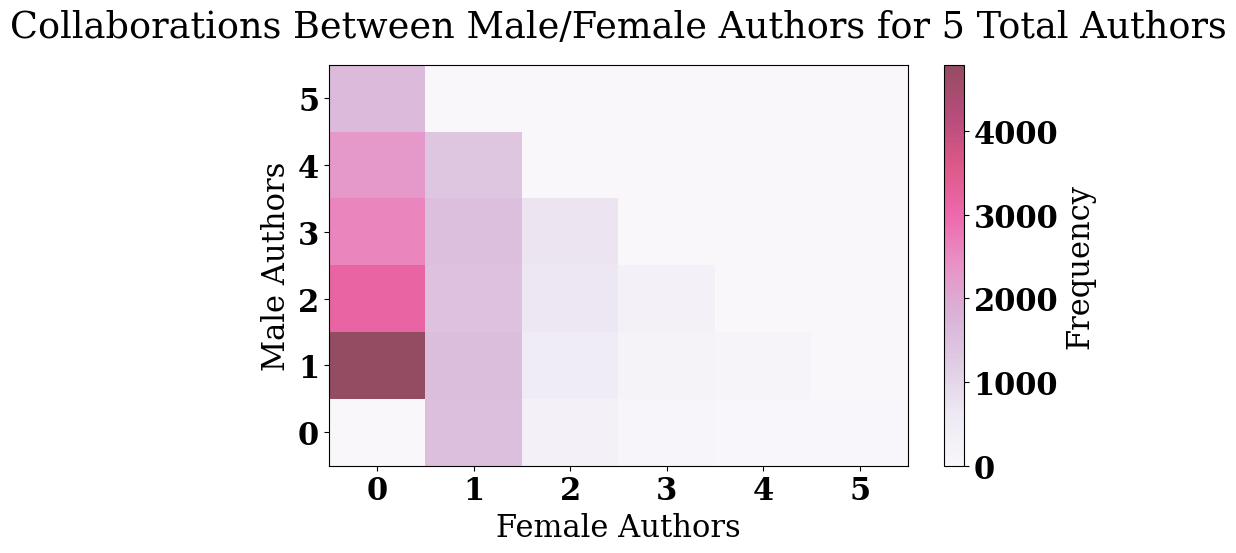

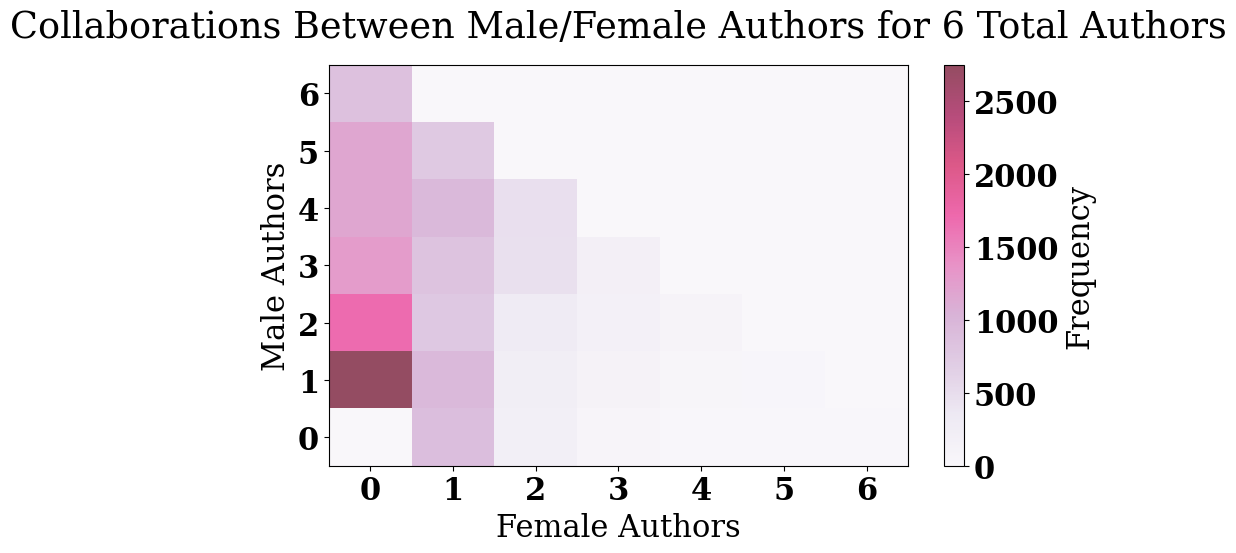

In [591]:
hist2D_author_gender_counts(article_author_data_final, total_authors_range=6)

#måske vi skal gøre noget med dropna da nogle ikke har et køn og derfor ser det lidt mærkeligt ud ?

# Topic Model

In [212]:
text_data=article_author_data_final.drop_duplicates(subset=['article_id'], keep='first')[['article_id', 'journal_name', 'title', 'abstract']]

## Text preparation

In [213]:
#create new column to clean abstract text 
text_data['abstract_clean']=text_data['abstract']

### Links

In [214]:
#let's first check the cases of links in the abstract
links_abstract=[]

for abstract in text_data['abstract_clean']:
    if 'https' in abstract:
        links_abstract.append(abstract)
        

In [215]:
len(links_abstract)

26505

In [216]:
def remove_links(text):
    # Define a pattern to match URLs
    url_pattern = re.compile(r'https?://\S+')

    # Use the pattern to find all URLs in the text
    matches = re.findall(url_pattern, text)

    # Replace each URL with an empty string
    for match in matches:
        text = text.replace(match, '')

    return text


In [217]:
text_data['abstract_clean'] = text_data['abstract_clean'].apply(remove_links)


In [218]:
#let's check number of links after the update 
links_abstract_updated=[]

for abstract in text_data['abstract_clean']:
    if 'https' in abstract:
        links_abstract_updated.append(abstract)
        

In [219]:
len(links_abstract_updated)

118

In [220]:
#links_abstract_updated #there is very few instances of https and URL left so maybe just add them as stopwords 

### Copyright

In [221]:
#let's check for copyright
copyright_abstract=[]

for abstract in text_data['abstract_clean']:
    if '©' in abstract:
        copyright_abstract.append(abstract)
        

In [222]:
len(copyright_abstract)

10646

In [223]:
copyright_text_data=text_data['abstract_clean'][text_data['abstract_clean'].isin(copyright_abstract)]

In [224]:
#we can now clean all abstract that include copyright but not at first few words
def clean_abstract_from_copyright(text):
    # Case-insensitive search for the first occurrence of "references"
    match = re.search(r'(?i)©', text)
    
    if match and match.start() > 20:
        # If a match is found and it's not the first word, remove everything from that point onward
        return text[:match.start()].strip()
    else:
        # If no match is found or it's the first word, return the original text
        return text

In [225]:
text_data['abstract_clean'][text_data['abstract_clean'].isin(copyright_abstract)] = text_data['abstract_clean'][text_data['abstract_clean'].isin(copyright_abstract)].apply(clean_abstract_from_copyright)


In [226]:
#let's check for copyright
copyright_abstract_clean=[]

for abstract in text_data['abstract_clean']:
    if '©' in abstract:
        copyright_abstract_clean.append(abstract)
        

In [227]:
len(copyright_abstract_clean) #for the remaining we remove the introductory text

38

In [228]:
#we remove the introductory text including copyright after investegating the above
def remove_introductory_text(text):
    # Check for the first occurrence of words (case-sensitive)
    match = re.search(r'\b(?:The|This|Many|String|Peter|We|There|Childbirth|Low|With|Improvements|It|NA62|GeN-FOAM|Prismatic|Refuges)\b', text)
    
    if match:
        # If there is a match, remove the part up to the match
        return text[match.start():].strip()
    else:
        # If no match, return an empty string
        return ''

In [229]:
text_data['abstract_clean'][text_data['abstract_clean'].isin(copyright_abstract_clean)] = text_data['abstract_clean'][text_data['abstract_clean'].isin(copyright_abstract_clean)].apply(remove_introductory_text)


In [230]:
#let's check for copyright final
copyright_abstract_final=[]

for abstract in text_data['abstract_clean']:
    if '©' in abstract:
        copyright_abstract_final.append(abstract)
        

In [231]:
len(copyright_abstract_final)

2

In [232]:
#copyright_abstract_final #perfect 

### Latex

In [233]:
#scan for documents matching latex formats 

In [234]:

def find_latex_matches(text):
    # Find $$ and their content
    matches = re.search(r'\$\$.*?\$\$', text) or re.search(r'\$.*?\$', text)

    # Find LaTeX commands like \text or \text{}
    matches = matches or re.search(r'\\[a-zA-Z]+\*?(\{.*?\})?', text)

    # Find references like [210]
    matches = matches or re.search(r'\[.*?\]', text)

    return bool(matches)



In [235]:
# Apply the function to filter rows
latex_abstract = text_data[text_data['abstract_clean'].apply(find_latex_matches)]


In [236]:
len(latex_abstract)

64315

In [237]:
#strip text for latex commands and special characters 
def strip_latex(text):
    # Remove $$ and their content
    text = re.sub(r'\$\$.*?\$\$', '', text)
    text = re.sub(r'\$.*?\$', '', text)


    # Remove LaTeX commands like \text or \text{}
    text = re.sub(r'\\[a-zA-Z]+\*?(\{.*?\})?', '', text)

    # Remove leftover $ (if any)
    text = text.replace('$', '')

    # remove refrencee e.g. [210]
    text = re.sub(r'\[.*?\]', '', text)

    return text


In [238]:
text_data['abstract_clean'][text_data['abstract_clean'].isin(latex_abstract['abstract_clean'])]=text_data['abstract_clean'][text_data['abstract_clean'].isin(latex_abstract['abstract_clean'])].apply(strip_latex)


### Chinese text

In [239]:

def find_chinese_text(text):
    # Define a regular expression pattern to match Chinese characters
    chinese_pattern = re.compile(r'[\u4e00-\u9fff]+')

    # Find all occurrences of Chinese text
    matches = re.findall(chinese_pattern, text)

    return bool(matches)


In [240]:
chinese_examples = text_data['abstract_clean'].apply(find_chinese_text)

In [241]:

def strip_chinese(text):
    # Define a regular expression pattern to match Chinese characters
    chinese_pattern = re.compile(r'[\u4e00-\u9fff]+')

    # Replace all occurrences of Chinese text with an empty string
    stripped_text = re.sub(chinese_pattern, '', text)

    return stripped_text


In [242]:
text_data['abstract_clean'][chinese_examples==True]=text_data['abstract_clean'][chinese_examples==True].apply(strip_chinese) 
#should we just apply to all?

## Costum stopwords

In [11]:
institution_names=article_author_data_final.institution_name.unique().tolist()
institution_names.remove('unknown')

In [12]:
split_inst_name=institution_names.copy()
#split list into each name element separated by - , . or space 
split_pattern = re.compile(r'[-\,\.\s]+')
split_inst_name = [name for split_inst_name in map(split_pattern.split, split_inst_name) for name in split_inst_name]
#remove names that are less than 2 characters 
places = [name for name in split_inst_name if len(name) >= 2]

In [13]:
#get geogrphaic references from institution name places and use those as stopwords as well 

def extract_geographic_entities(data):
    entities = set()
    for text in data:
        places_geotext = GeoText(text)
        entities.update(map(str.lower, places_geotext.cities))
        entities.update(map(str.lower, places_geotext.countries))
    return list(set(entities))

# Extract geographic entities
geographic_places = extract_geographic_entities(places)


In [14]:
author_name_list1=article_author_data_final['author.display_name'].dropna().unique().tolist() 
author_name_list2=article_author_data_final.raw_author_name.dropna().unique().tolist() 


In [15]:
#conc list 1 and 2 and then remove duplicates to have each name ones 
author_name_list=author_name_list1 + author_name_list2
author_name_list = set(author_name_list)
#get lowercase value of names 
author_name_list = [name.lower() for name in author_name_list]
#split list into each name element separated by , . or space 
split_pattern = re.compile(r'[,\.\s]+')
split_names = [name for name_set in map(split_pattern.split, author_name_list) for name in name_set]
#remove names that are less than 2 characters 
author_names = [name for name in split_names if len(name) >= 2]



In [16]:
months= ["january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december"]


In [17]:
custom_stopwords = set(["article", "paper", "articles", "papers", "abstract", "vol" "iss", "Volume", "issue", "issn",
                        "introduction", "objective", "aim", "method", "methodology", "results", "conclusion", "discussion",
                       "views", "icon", "review", "share", "twitter", "facebook", "reddit", "linkedin", "reprints", "cite", 
                        "citation", "citations", "citing", "cite", "previews", "next", "https", "url", "isbn", "doi", "author", "authors",
                        "department", "research", "physics", "contents", "figures", "tables", "video", "audio", "supplementary", "peer", 
                        "tools", "icon", "download", "manager", "easybib", "bookends", "mendeley", "papers", "endnote", "refworks", 
                        "bibtex", "latex", "toolbar", "dropdown","menu", "auto", "suggest", "content", "AIP", "publishing", "portfoliothe",
                        "published", "portfolio", "journal", "pages", "reprint", "permission", "reference", "references", "contentaip",
                       "accepted", "bookend", "permission", "permissions", "crossreference", "crossref", "crossrefs", "text",
                       "british", "american", "canadian", "glasgowsearch", "aboutpdf", "toolsrequest", "citationadd", "favoritestrack",
                       "accessplease", "access", "accessshare", "pdfpdf", "shareshar", "share", "authorref", "authorrefs", 
                        "term", "condition", "useshare", "linkus", "version", "friend", "colleague", "linkshare", "school", "college",
                       "inredditwechat", "literature", "note", "ottawasearch", "favoritestrack", "give", "onlin", "publish", "published",
                       "annals", "academy", "sciencesvolume", "read", "accept", "useshareable", "linkuse", "link", "share", #added from first result
                       "friends", "colleagues", "copy", "conference", "symposium", "contentamerican", "contentamericans", "zotero",
                       "scholar", "google", "href", "xmln", "xlink", "penelitian", "pembelajaran", "belajar", "dalam", "menggunakan",
                       "adalah", "analisi","peserta", "email", "providedcopi", "providedcopy", "addressthe", "addressth", "preprint",
                       "preprints", "submit", "accessy", "preprintopen", "duchess", "gloucest", "cockcroft", "slash", "linkop",
                       "lwfa", "tion", "msub", "msup", "xmln", "cdata", "msubsup", "inline", "mtext", "mathvari", "punjab", "dinfo",
                       "epub", "inredditemail", "fareast", "tstyle", "bidi", "citationstracking", "citationstrack", "citationstracker", "citationstracked",
                        "toolsadd", "shareshare", "lwfa", "tute", "ture", "shanxi", "banara", "providedcopy", "addressthe", "adalah", "menggunakan",
                       "peserta", "bahwa", "cdata", "xlink", #added from second result 
                       "calibri", "ascii", "pagin", "msonormalt", "noshow", "rowband", "colband", "xmln", "italic", "contentphysics", "contentphys",
                       "texatom", "today", "terhadap", "digunakan", "metod", "methode", "metode", "dapat", "submit", "accessy", "esse", "universityid",
                       "preliminary", "preliminari", "ensino", "estudiant", "trabajo", "sobre", "est", "aprendizaj", "esta", "resultado", "ensenanza",
                     #third
                        "entre", "olarak", "anahtar", "kelimel", "onemli", "ogrencilerin", "calismada", "ozet", "icin", "arastirma", "eld",
                       "untuk", "yaitu", "menunjukkan", "sebesar", "bertujuan", "eksperiment", "pengembangan", "estudiante", "alttext",
                       "script", "mathvariant", "mathvari", "overflow", "scroll", "submit", "submitted", "portfolioaip", "also",
                       "ffmt", "amtx", "aofi", "akev", "xref", "url_ctx_fmt", "plusful", "citationtrack", "citationtracks", "citationtracking",
                       "articlenext"]) 




custom_stopwords.update(institution_names)
custom_stopwords.update(geographic_places)
custom_stopwords.update(author_names)
custom_stopwords.update(months)

## Text preprocessing 

In [250]:
#save and load clean abstracts 
text_data.to_csv(f'Data backup/text_data{str(date.today())}') #'2024-03-10'

In [49]:
text_data=pd.read_csv(f'Data backup/text_data2024-03-10') #'2024-03-10'

In [18]:
# Load NLTK's WordNet Lemmatizer
wn_lemmatizer = WordNetLemmatizer()

# Update NLTK's English stopwords with your custom stopwords
nltk_stopwords = set(stopwords.words('english'))
nltk_stopwords.update(custom_stopwords)

# Initialize the Porter stemmer
porter_stemmer = PorterStemmer()

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        lowercase_token = token.lower()
        if lowercase_token not in nltk_stopwords and len(lowercase_token) > 3:
            # Lemmatize the token
            lemma_token = wn_lemmatizer.lemmatize(lowercase_token)
            # Stem the lemma token
            stemmed_token = porter_stemmer.stem(lemma_token)
            result.append(stemmed_token)
    return result


In [19]:
text_abstract=text_data['abstract_clean'].reset_index() #do we have to reset index? 

In [20]:
documents=text_abstract

In [21]:
%%time
#apply preprocessing function on to all documents to get lemmatized docs 
processed_docs = documents['abstract_clean'].dropna().map(preprocess)

CPU times: user 7min 7s, sys: 4.09 s, total: 7min 11s
Wall time: 7min 14s


On string length: https://datascience.stackexchange.com/questions/58825/does-the-length-of-the-text-data-affects-the-score-of-clustering

In [256]:
#let's check the average abstract length in order to set a reasonable minimum length for comparison 

In [23]:
#check if there are any processed docs that are empty or less than 10 words 
any_empty = processed_docs.apply(lambda x: len(x) <= 3)
print("Empty documents:", len(any_empty[any_empty==True]))

#remove the empty documents 
processed_docs=processed_docs[~any_empty==True] #don't know if we should reset index though 


Empty documents: 0


In [24]:
#check if there are any processed docs that are empty 
any_empty = processed_docs.apply(lambda x: len(x) <= 3)
print("Empty documents:", len(any_empty[any_empty==True]))

Empty documents: 0


In [25]:
#save and load clean abstracts 
processed_docs.to_csv(f'Data backup/processed_docs{str(date.today())}') #'2024-03-14'

In [50]:
processed_docs=pd.read_csv(f'Data backup/processed_docs2024-03-14')  #'2024-03-14'

In [261]:
#create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set.
dictionary = gensim.corpora.Dictionary(processed_docs)

In [262]:
#Filter out tokens that appear in less than 15 documents (absolute number) or 
#more than 0.5 documents (fraction of total corpus size, not absolute number).
dictionary.filter_extremes(no_below=15, no_above=0.5) # maybe we wont to tune this part as well? 

In [263]:
dictionary.save(f'Data backup/dictionary{str(date.today())}') #'2024-03-10'


In [264]:
#create bow corpus 
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [265]:
#use TfidfModel
tfidf = models.TfidfModel(bow_corpus)

In [266]:
#create final tfidf corpus for model training 
corpus_tfidf = tfidf[bow_corpus]

In [267]:
#save and load corpus 
corpora.MmCorpus.serialize(f'Data backup/corpus_tfidf{str(date.today())}.mm', corpus_tfidf) #'2024-03-10'

In [62]:
#loading the saved corpus
corpus_tfidf = corpora.MmCorpus(f'Data backup/corpus_tfidf2024-03-10.mm') #'2024-03-10'

## Parameter settings 

In [1118]:
len(corpus_tfidf) #this will take at least 6,5 days! let's try and start by just 20 as K topics and 1 passes 

469698

In [ ]:
num_topics_range = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100] #less than 20 and more than 40 topics seem unreasonable

# an idea we start by testing just one topic number with the highest and lowest alpha and beta
#then once we have checked for that we see which is better and then compare that to the middle one 0.1
#then similarly for 40 topics and potentially 30 topics 

#or start by finding the best alpha keeping topics and beta fixed
#then do the same for beta ??? 

#or loop through each topics but keeping alpha and beta constant and then changing them - let's try that!! 


In [ ]:
def train_lda_model_topics(corpus_tfidf, num_topics_range, random_seed, passes, workers):
    results = []

    # Total number of combinations of num_topics, alpha, and beta
    total_combinations = len(num_topics_range)
    total_documents = len(corpus_tfidf)

    # Counter for tracking progress
    progress_counter = 0

    for num_topics in num_topics_range:
                # Increment progress counter
                progress_counter += 1

                print(f"Processing combination {progress_counter}/{total_combinations} - num_topics: {num_topics}")

                # Train LDA model
                lda_model_tfidf = gensim.models.LdaMulticore(
                    corpus_tfidf,
                    num_topics=num_topics,
                    id2word=dictionary,
                    random_state=random_seed,
                    #alpha='auto',
                    #eta='atuo',
                    passes=passes,
                    workers=workers
                )

                # Calculate coherence score
                coherence_model = CoherenceModel(
                    model=lda_model_tfidf,
                    texts=processed_docs,
                    dictionary=dictionary,
                    coherence='c_v'
                )

                # Append results to the list
                results.append({
                    'num_topics': num_topics,
                    'coherence_score': coherence_model.get_coherence(),
                    'perplexity': lda_model_tfidf.log_perplexity(corpus_tfidf)
                })

    print("Training complete.")

    return results


In [ ]:
%%time
model_results = train_lda_model_topics(corpus_tfidf, num_topics_range, random_seed=42, passes=2, workers=2)


In [ ]:
#vi startede den 09:37 8 feb

In [ ]:
model_results_topics=pd.DataFrame(model_results)

In [ ]:
model_results_topics

In [ ]:
model_results_topics[['num_topics', 'coherence_score', 'perplexity']]

In [ ]:
model_results_topics.to_csv('Data backup/LDA_model_results_topics.csv')

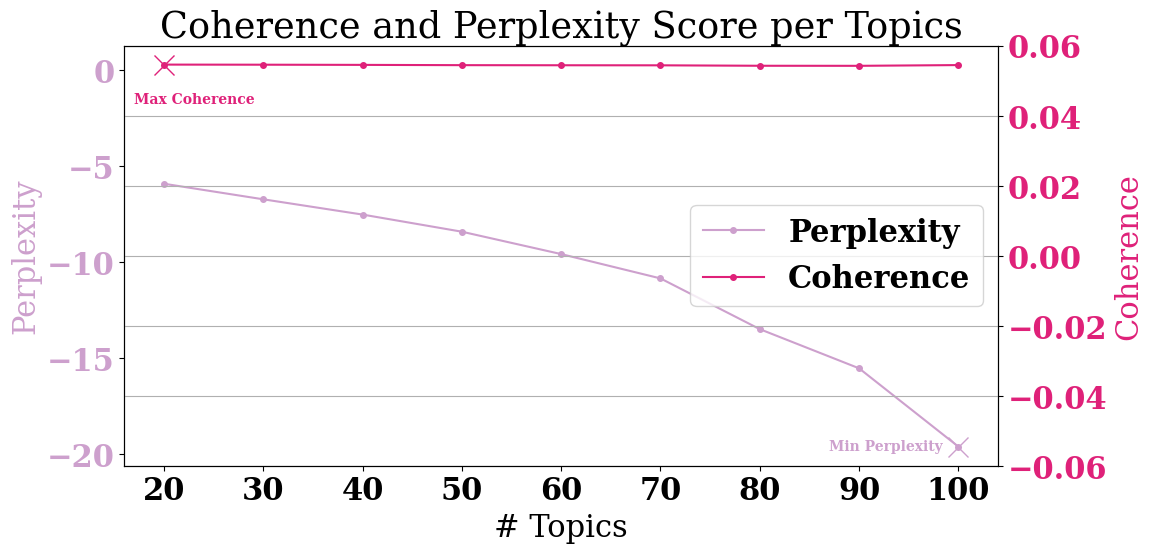

In [936]:
plot_with_twinx(model_results_topics['num_topics'], model_results_topics['perplexity'], model_results_topics['coherence_score'], title='Coherence and Perplexity Score per Topics', xlabel='# Topics', ylabel1='Perplexity', ylabel2='Coherence', norm_separate=False, norm_together=True, multiply=100, xmargins=0.1, ymargins=0.1, legend_loc='center right', save_name='coherence_perplexity')


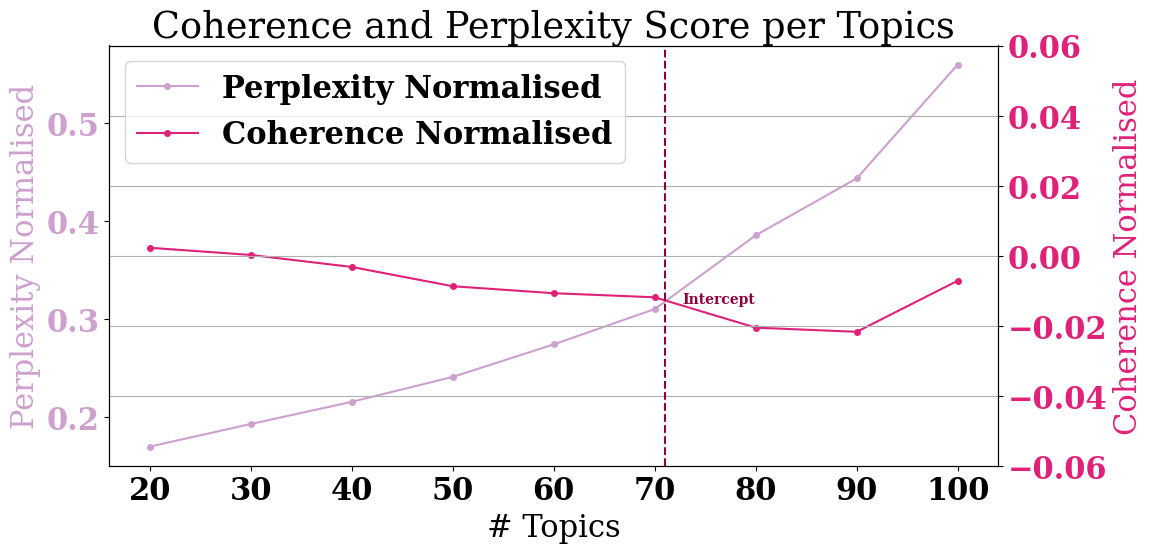

In [938]:
fig=plot_with_twinx(model_results_topics['num_topics'], model_results_topics['perplexity'], model_results_topics['coherence_score'], title='Coherence and Perplexity Score per Topics', xlabel='# Topics', ylabel1='Perplexity Normalised', ylabel2='Coherence Normalised', norm_separate=True, norm_together=False, multiply=1, plot_min_max=False, xmargins=0.1, ymargins=0.1, legend_loc='upper left', save_name='coherence_perplexity_norm')
ax = fig.gca()
ax.axvline(71, 0, 1, ls='--', color=purd_colors[9])
ax.text(72.7, -0.0135, 'Intercept', color=purd_colors[9], size=10)
plt.show()

In [940]:
#even though analysis shows 70 topics as a good trade-off this would not lead to any very comprenhensive analysis
#so we choose 20 going forward - this also has the highest coherence score which might be more relevant than perplexity

In [966]:
#now that we have decided on number of topics we test for the hyperparameters 
def train_lda_model_parameter(corpus_tfidf, num_topics, alpha_values, beta_values, random_seed, passes, workers):
    results = []

    # Total number of combinations of num_topics, alpha, and beta
    total_combinations = len(alpha_values) * len(beta_values)
    total_documents = len(corpus_tfidf)

    # Counter for tracking progress
    progress_counter = 0

    for alpha in alpha_values:
        for beta in beta_values:
            # Increment progress counter
            progress_counter += 1

            print(f"Processing combination {progress_counter}/{total_combinations} - num_topics: {num_topics}, alpha: {alpha}, beta: {beta}")

                # Train LDA model
            lda_model_tfidf = gensim.models.LdaMulticore(
                corpus_tfidf,
                num_topics=num_topics,
                id2word=dictionary,
                random_state=random_seed,
                alpha=alpha,
                eta=beta,
                passes=passes,
                workers=workers
            )

                # Calculate coherence score
            coherence_model = CoherenceModel(
                model=lda_model_tfidf,
                texts=processed_docs,
                dictionary=dictionary,
                coherence='c_v'
            )

                # Append results to the list
            results.append({
                'num_topics': num_topics,
                'alpha': alpha,
                'beta': beta,
                'coherence_score': coherence_model.get_coherence(),
            })

    print("Training complete.")

    return results


In [967]:
alpha_values = [0.01, 0.1, 1.0] 
beta_values = [0.01, 0.1, 1.0]
num_topics = 20

In [968]:
#lad os sætte den i gang i aften/nat hehe 

In [969]:
%%time
model_results_parameter=train_lda_model_parameter(corpus_tfidf, num_topics, alpha_values, beta_values, random_seed=42, passes=2, workers=2)


Processing combination 1/9 - num_topics: 20, alpha: 0.01, beta: 0.01
Processing combination 2/9 - num_topics: 20, alpha: 0.01, beta: 0.1
Processing combination 3/9 - num_topics: 20, alpha: 0.01, beta: 1.0
Processing combination 4/9 - num_topics: 20, alpha: 0.1, beta: 0.01
Processing combination 5/9 - num_topics: 20, alpha: 0.1, beta: 0.1
Processing combination 6/9 - num_topics: 20, alpha: 0.1, beta: 1.0
Processing combination 7/9 - num_topics: 20, alpha: 1.0, beta: 0.01
Processing combination 8/9 - num_topics: 20, alpha: 1.0, beta: 0.1
Processing combination 9/9 - num_topics: 20, alpha: 1.0, beta: 1.0
Training complete.
CPU times: user 34min 11s, sys: 7min 50s, total: 42min 2s
Wall time: 1h 39min 9s


In [972]:
model_results_parameter=pd.DataFrame(model_results_parameter)

In [994]:
model_results_parameter=model_results_parameter.sort_values(by=['coherence_score'])


In [996]:
model_results_parameter

num_topics  alpha  beta  coherence_score
6          20   1.00  0.01         0.368601
7          20   1.00  0.10         0.412725
8          20   1.00  1.00         0.481174
4          20   0.10  0.10         0.494421
0          20   0.01  0.01         0.496179
3          20   0.10  0.01         0.500060
5          20   0.10  1.00         0.543652
1          20   0.01  0.10         0.544857
2          20   0.01  1.00         0.563709

In [997]:
#we are now ready to run the final topic model with K=20 topics, alpha=0.01 and beta=1.0 

## Run model 

In [268]:
num_topics=20
random_seed=42
alpha=0.01
beta=1.00
workers=2
passes=5

In [269]:
%%time

#Running LDA using TF-IDF
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=num_topics, id2word=dictionary, 
                                               alpha=alpha, eta=beta, random_state=random_seed, 
                                               passes=passes, workers=workers)


CPU times: user 8min 11s, sys: 2min 17s, total: 10min 29s
Wall time: 34min 1s


In [271]:
# save model to disk
lda_model_tfidf.save(f'Data backup/lda_model_tfidf{str(date.today())}.model') #'2024-03-10'

In [55]:
# later on, load trained model from file
lda_model_tfidf =  models.LdaModel.load(f'Data backup/lda_model_tfidf2024-03-10.model') #'2024-03-10'

In [56]:
#show topic and its words 
for idx_abstract, topic_abstract in lda_model_tfidf.print_topics():
    print('Topic: {} Word: {}'.format(idx_abstract, topic_abstract))

Topic: 0 Word: 0.023*"learn" + 0.011*"teach" + 0.009*"skill" + 0.006*"develop" + 0.005*"use" + 0.005*"think" + 0.004*"subject" + 0.004*"base" + 0.004*"valid" + 0.004*"problem"
Topic: 1 Word: 0.008*"crossrefgoogl" + 0.006*"linkgoogl" + 0.001*"authorpublish" + 0.001*"accesstechn" + 0.001*"astronautica" + 0.001*"astronaut" + 0.001*"univ" + 0.001*"aeronaut" + 0.001*"rocket" + 0.000*"peopl"
Topic: 2 Word: 0.008*"neural" + 0.008*"learn" + 0.007*"network" + 0.006*"algorithm" + 0.006*"pinn" + 0.005*"base" + 0.005*"propos" + 0.005*"optim" + 0.005*"approach" + 0.005*"predict"
Topic: 3 Word: 0.009*"accessy" + 0.008*"submit" + 0.007*"venu" + 0.007*"default" + 0.007*"archiv" + 0.006*"essoar" + 0.005*"latest" + 0.005*"feedback" + 0.004*"view" + 0.004*"commun"
Topic: 4 Word: 0.006*"patient" + 0.006*"protein" + 0.005*"clinic" + 0.005*"imag" + 0.005*"cancer" + 0.004*"treatment" + 0.004*"diseas" + 0.003*"radiat" + 0.003*"cell" + 0.003*"therapi"
Topic: 5 Word: 0.000*"abstractpdf" + 0.000*"mechanik" + 0.0

In [273]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_tfidf, corpus_tfidf, dictionary)
pyLDAvis.save_html(vis, f'Plots/{date.today()}/topic_abstract_{num_topics}_topics_{passes}_passes.html')
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.169530  0.001459       1        1  12.165452
2     -0.222533  0.022859       2        1  11.545447
10    -0.200755  0.015474       3        1  11.244926
8     -0.158783  0.000184       4        1  10.847764
11    -0.190382  0.020188       5        1  10.727304
13    -0.170306  0.004379       6        1   8.073458
7     -0.063521 -0.030463       7        1   7.602137
0     -0.135076  0.017405       8        1   7.039292
15    -0.019725 -0.006865       9        1   5.829796
6     -0.123576 -0.018660      10        1   5.550753
4     -0.038574 -0.024541      11        1   5.022158
19     0.156536 -0.030617      12        1   1.318579
12     0.190583  0.374909      13        1   1.308347
16     0.165712 -0.048840      14        1   0.339864
17     0.169824 -0.051019      15        1   0.273373
9      0.161917 -0.049467      16        1   0.272304
3      0.159251 -0.054672      17        1   0.260786
1      0.164307 -0.048219      18        1   0.215697
5      0.162316 -0.046746      19        1   0.181348
18     0.162316 -0.046746      20        1   0.181214, topic_info=             Term         Freq        Total Category  logprob  loglift
3233       annual  3521.000000  3521.000000  Default  30.0000  30.0000
335         engin  4164.000000  4164.000000  Default  29.0000  29.0000
598      composit  3027.000000  3027.000000  Default  28.0000  28.0000
288         polym  2819.000000  2819.000000  Default  27.0000  27.0000
9269      omnisci  2554.000000  2554.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
4550       fulfil     0.170850   243.079024  Topic20 -10.1778  -0.9471
3999       mammal     0.170799    43.044400  Topic20 -10.1782   0.7837
301       centuri     0.170761   918.960657  Topic20 -10.1784  -2.2775
12532       avant     0.170737    30.351353  Topic20 -10.1785   1.1328
8668   hereditari     0.170732    25.251644  Topic20 -10.1785   1.3167

[1200 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
6213      1  0.004097      aapm
6213      2  0.004097      aapm
6213      3  0.004097      aapm
6213      4  0.008194      aapm
6213      5  0.004097      aapm
...     ...       ...       ...
1313      8  0.076123  équation
1313      9  0.076123  équation
1313     10  0.076123  équation
1313     11  0.076123  équation
1313     12  0.076123  équation

[12639 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 3, 11, 9, 12, 14, 8, 1, 16, 7, 5, 20, 13, 17, 18, 10, 4, 2, 6, 19])

In [57]:
#assign topic label based on term frequency and weight 
topics_tfidf=pd.DataFrame(lda_model_tfidf.print_topics())

In [58]:
topics = [
    "Learning and Teaching", #Topic 0
    "Undefined Topic 1", #Topic 1
    "Machine Learning and Neural Networks", #Topic 2
    "Undefined Topic 2", #Topic 3
    "Medical Imaging and Radiology", #Topic 4
    "Undefined Topic 3", #Topic 5
    "Astrophysics", #Topic 6 
    "Philosophy Physics", #Topic 7
    "Reactor Physics", #Topic 8
    "Teaching", #Topic 9
    "Mathemathical Physics", #Topic 10
    "Quantum Physics", #Topic 11
    "Materials Science", #Topic 12
    "Particle Physics", #Topic 13
    "Fluid Dynamics", #Topic 14
    "Undefined Topic 4", #Topic 15
    "Undefined Topic 5", #Topic 16 
    "Undefined Topic 6", #Topic 17 
    "Undefined Topic 7", #Topic 18 
    "Plant and Animal Science" #Topic 19 
]

# Assign these topics to your dataframe or data structure
topics_tfidf['topic_label'] = topics

In [59]:
topics_tfidf=topics_tfidf.rename(columns={0: "topic_index", 1: "topic_words"})
topics_tfidf

topic_index                                        topic_words  \
0             0  0.023*"learn" + 0.011*"teach" + 0.009*"skill" ...   
1             1  0.008*"crossrefgoogl" + 0.006*"linkgoogl" + 0....   
2             2  0.008*"neural" + 0.008*"learn" + 0.007*"networ...   
3             3  0.009*"accessy" + 0.008*"submit" + 0.007*"venu...   
4             4  0.006*"patient" + 0.006*"protein" + 0.005*"cli...   
5             5  0.000*"abstractpdf" + 0.000*"mechanik" + 0.000...   
6             6  0.007*"observ" + 0.006*"cosmic" + 0.006*"gravi...   
7             7  0.003*"philosophi" + 0.003*"world" + 0.003*"un...   
8             8  0.005*"xmln" + 0.005*"electron" + 0.004*"puls"...   
9             9  0.016*"input" + 0.015*"teachersth" + 0.004*"as...   
10           10  0.010*"equat" + 0.005*"function" + 0.004*"nonl...   
11           11  0.007*"topolog" + 0.007*"spin" + 0.006*"magnet...   
12           12  0.078*"omnisci" + 0.075*"ceram" + 0.069*"annua...   
13           13  0.015*"neutrino" + 0.007*"lepton" + 0.007*"dec...   
14           14  0.008*"flow" + 0.004*"fluid" + 0.004*"pressur"...   
15           15  0.013*"desk" + 0.008*"annual" + 0.007*"help" +...   
16           16  0.001*"estudiant" + 0.001*"est" + 0.001*"apren...   
17           17  0.001*"analisi" + 0.001*"eksperimen" + 0.001*"...   
18           18  0.000*"sergip" + 0.000*"cosmophys" + 0.000*"br...   
19           19  0.017*"work" + 0.008*"agricultur" + 0.007*"eng...   

                             topic_label  
0                  Learning and Teaching  
1                      Undefined Topic 1  
2   Machine Learning and Neural Networks  
3                      Undefined Topic 2  
4          Medical Imaging and Radiology  
5                      Undefined Topic 3  
6                           Astrophysics  
7                     Philosophy Physics  
8                        Reactor Physics  
9                               Teaching  
10                 Mathemathical Physics  
11                       Quantum Physics  
12                     Materials Science  
13                      Particle Physics  
14                        Fluid Dynamics  
15                     Undefined Topic 4  
16                     Undefined Topic 5  
17                     Undefined Topic 6  
18                     Undefined Topic 7  
19              Plant and Animal Science

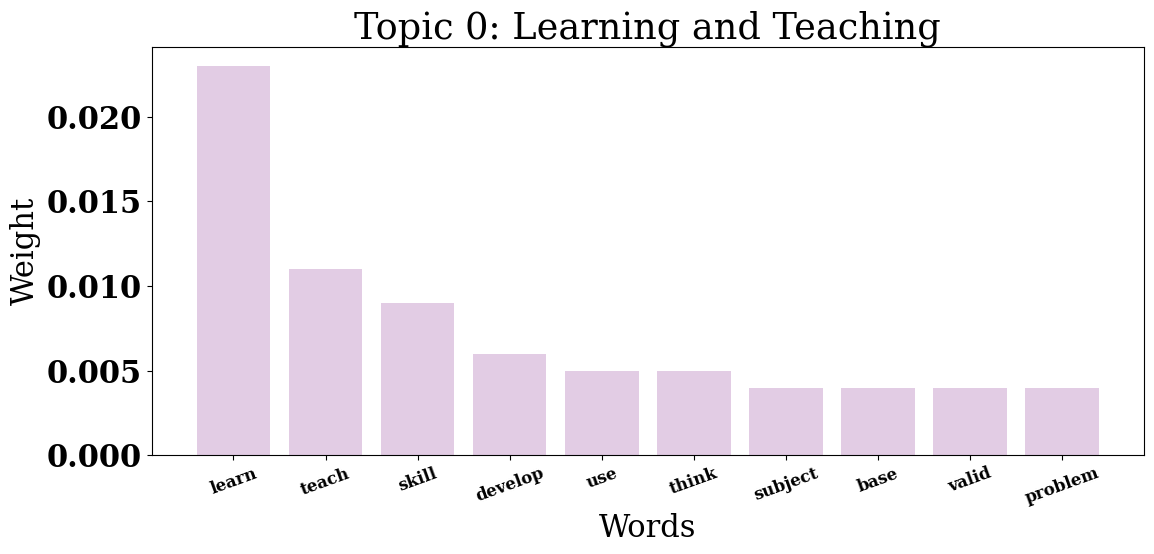

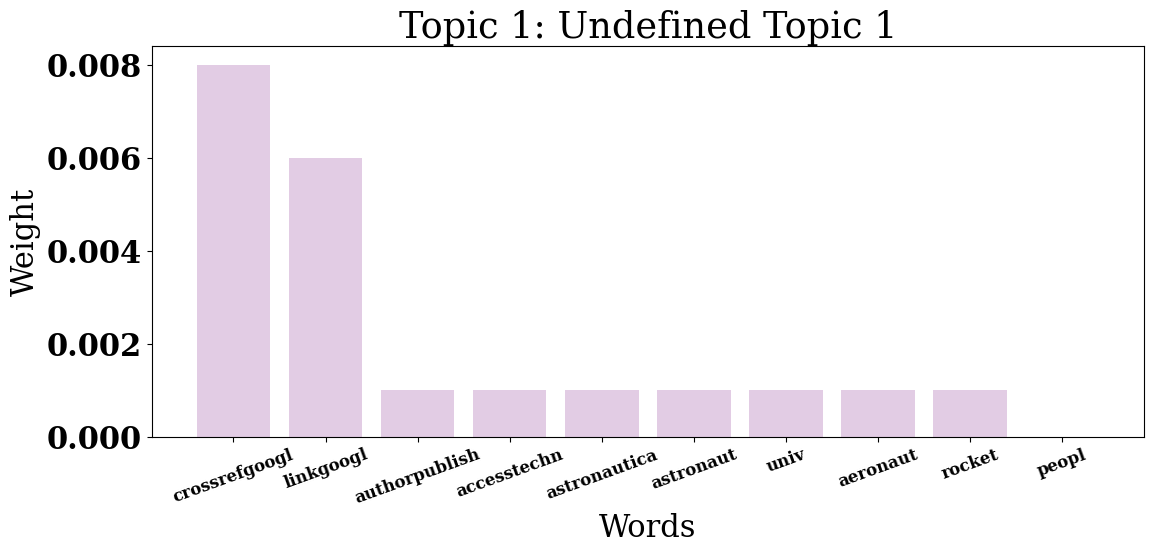

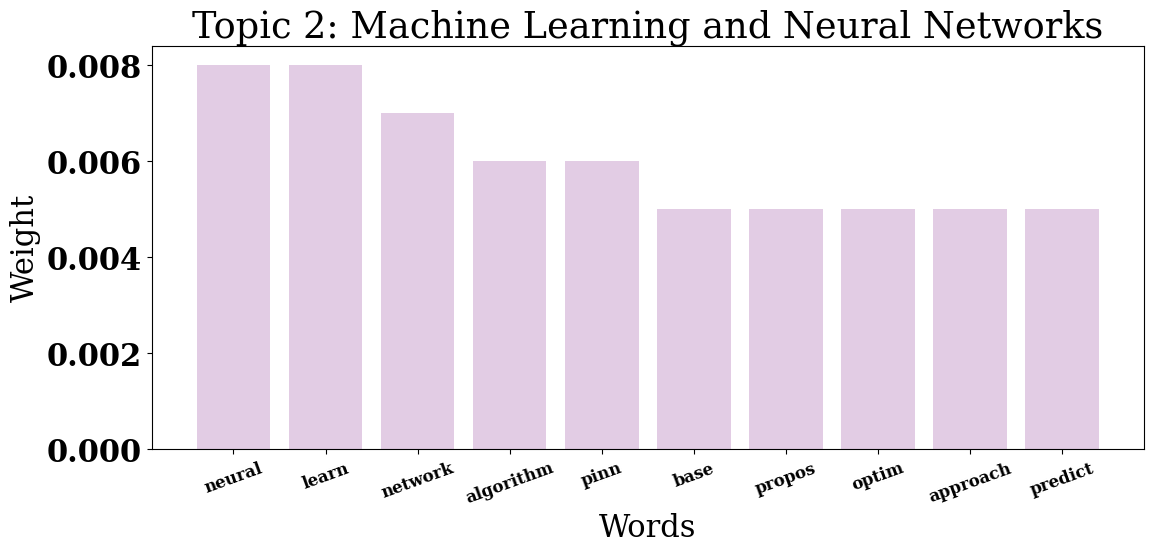

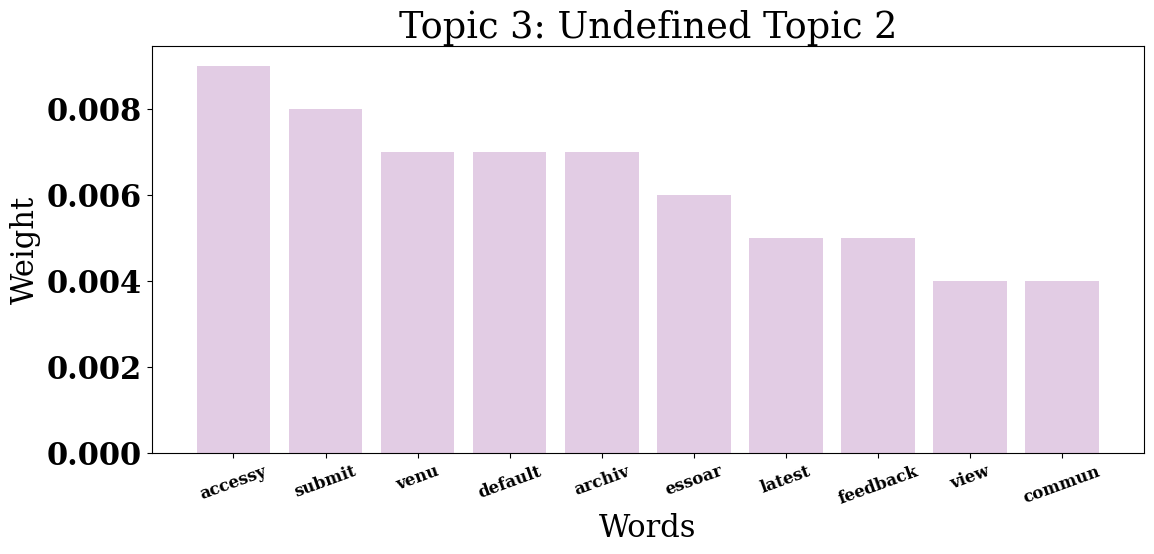

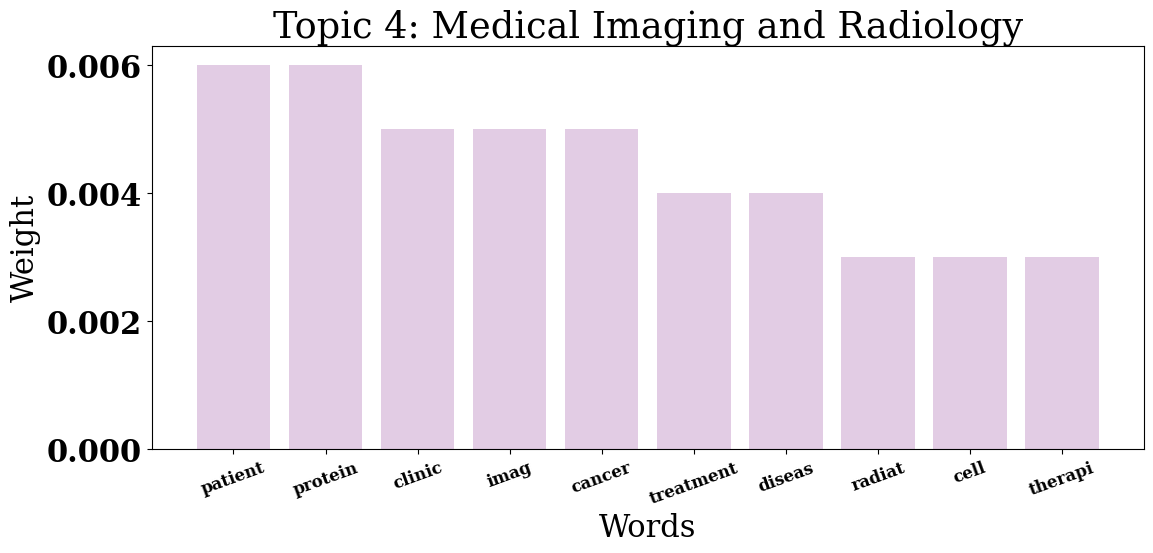

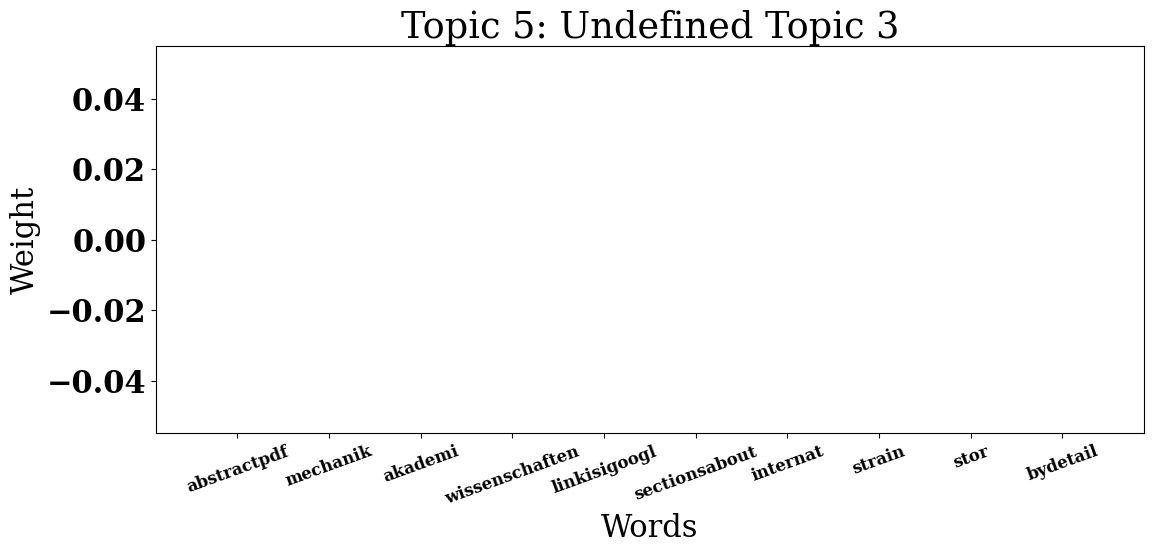

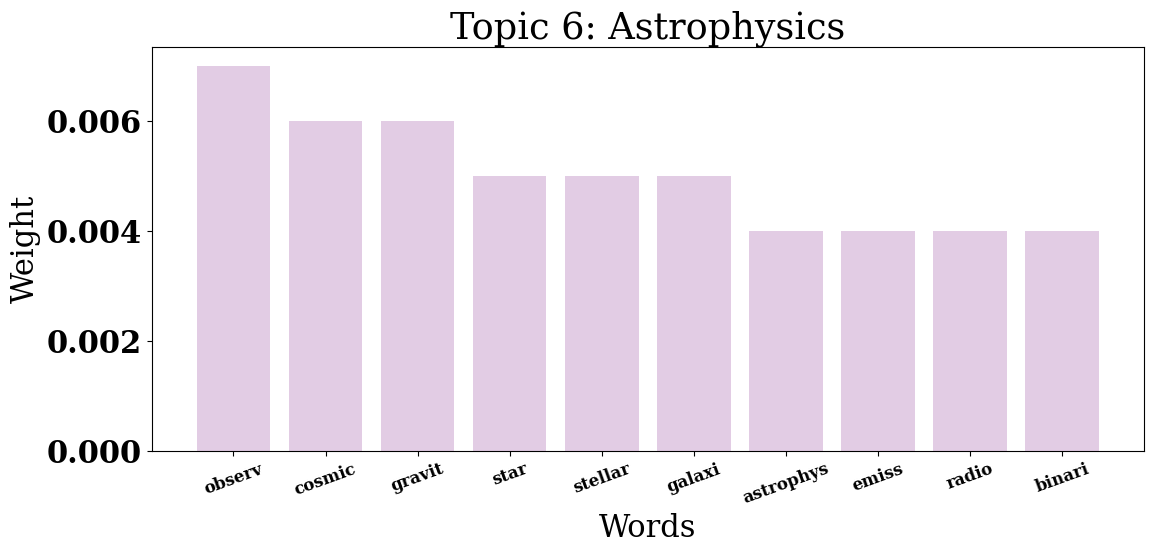

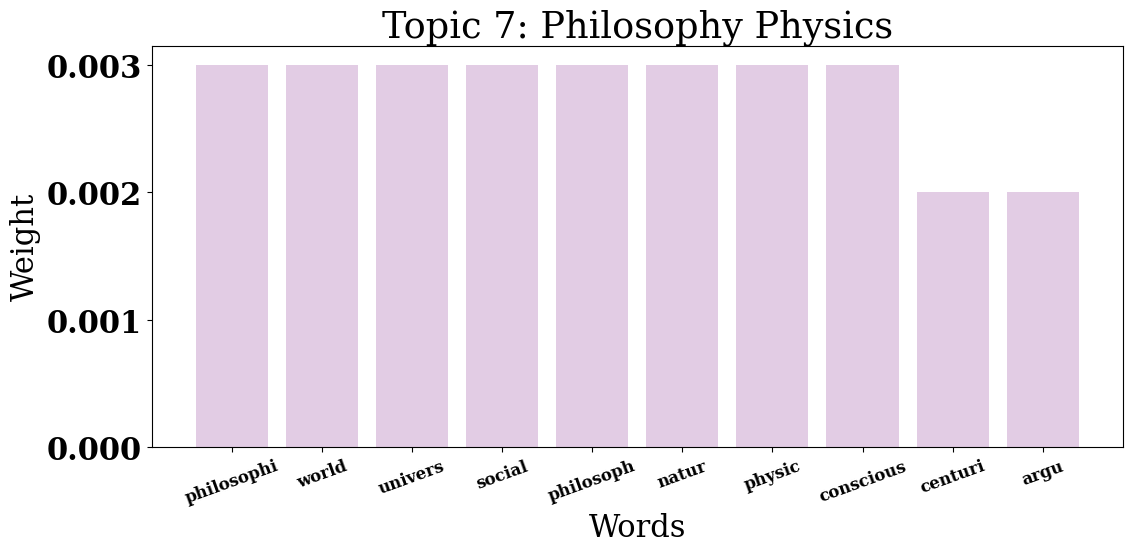

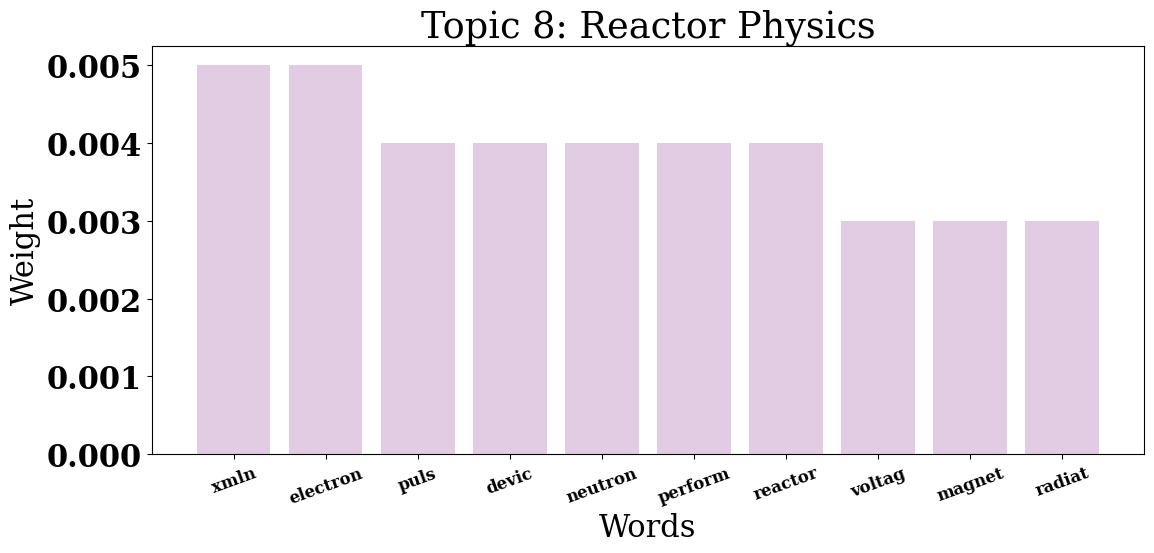

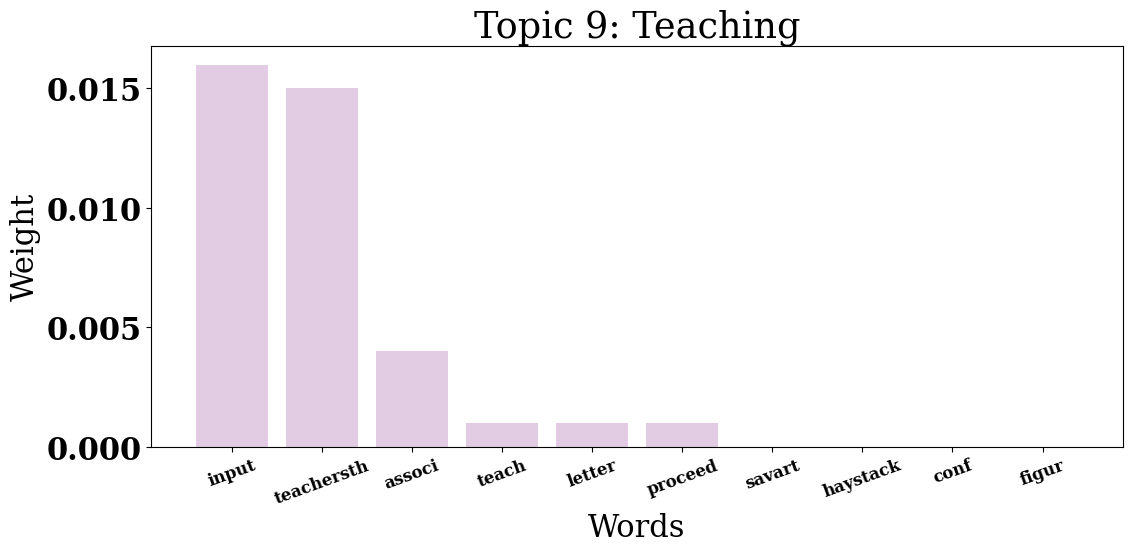

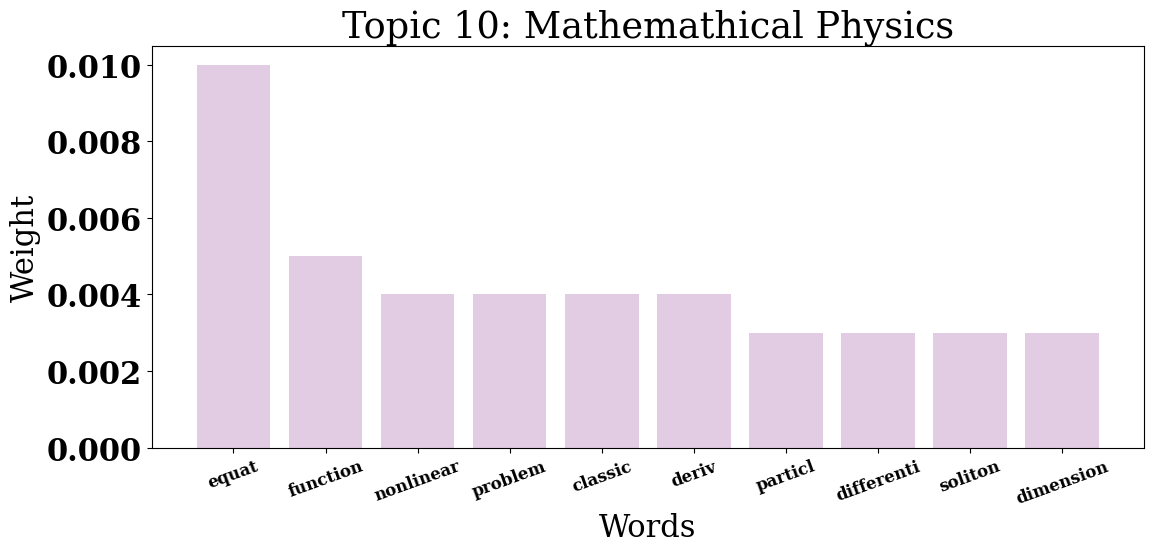

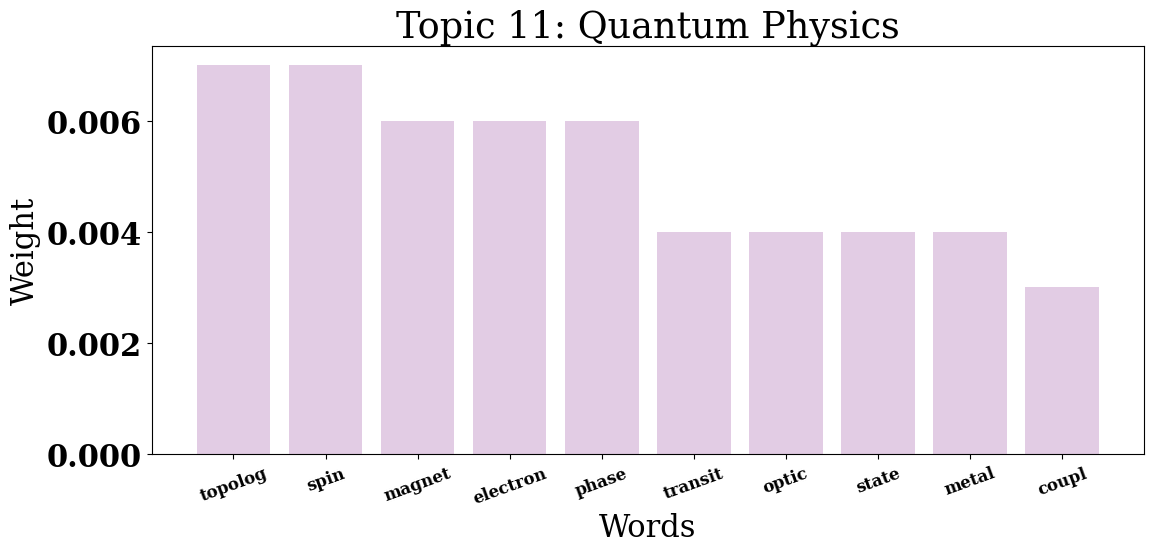

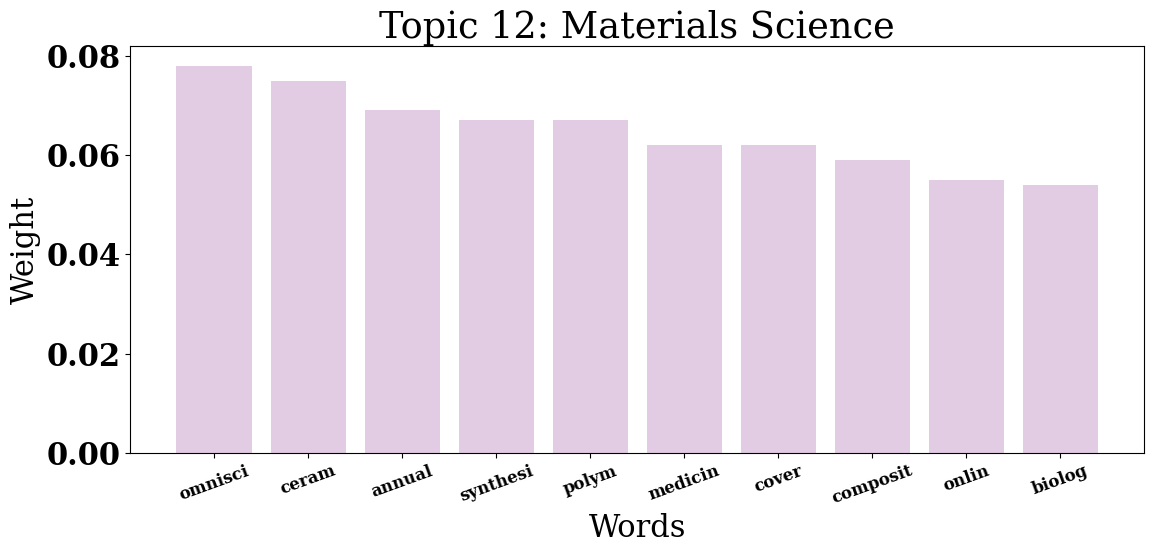

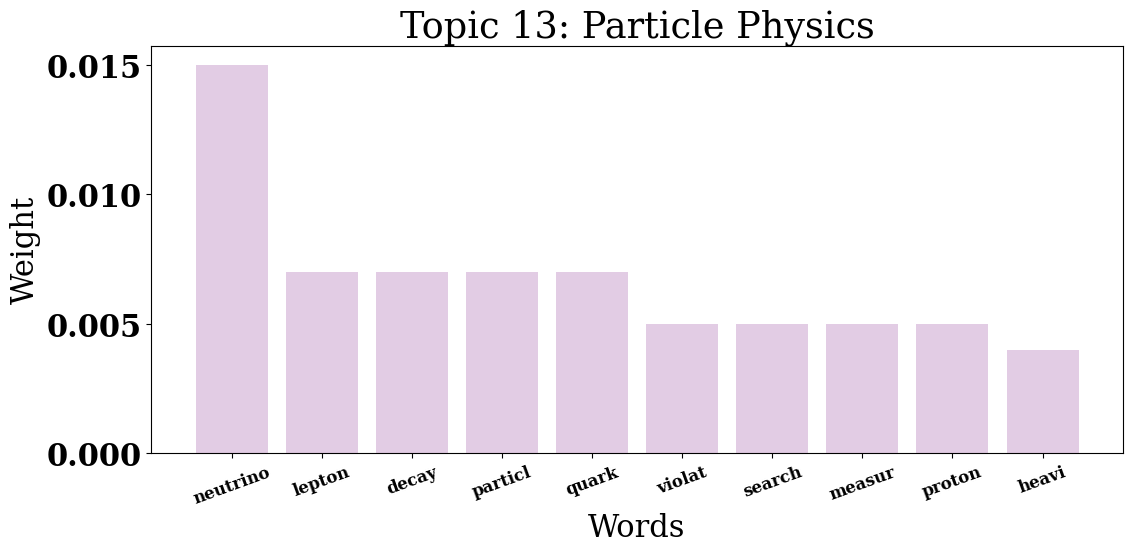

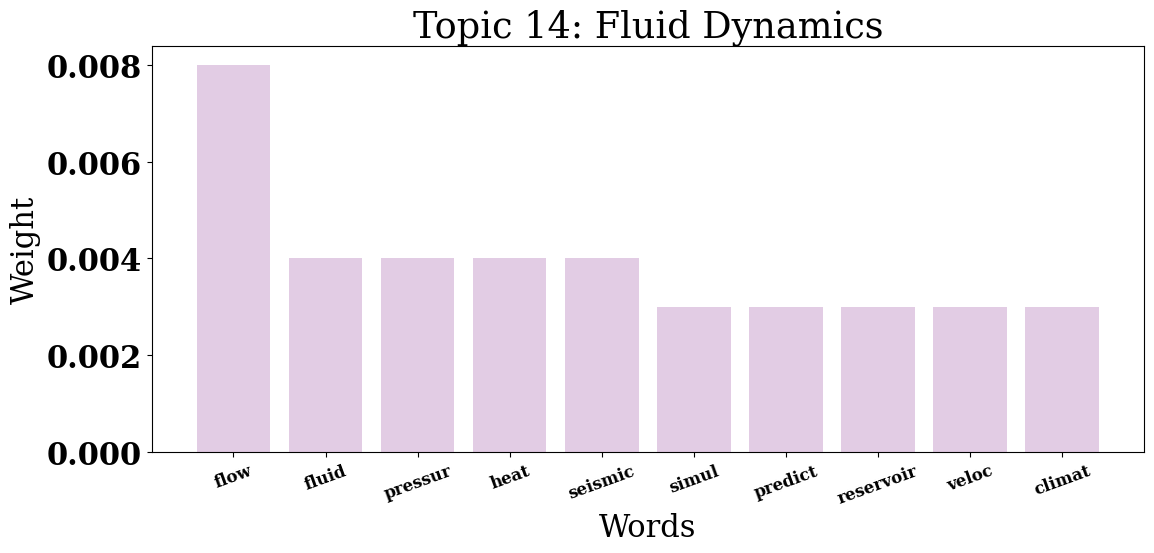

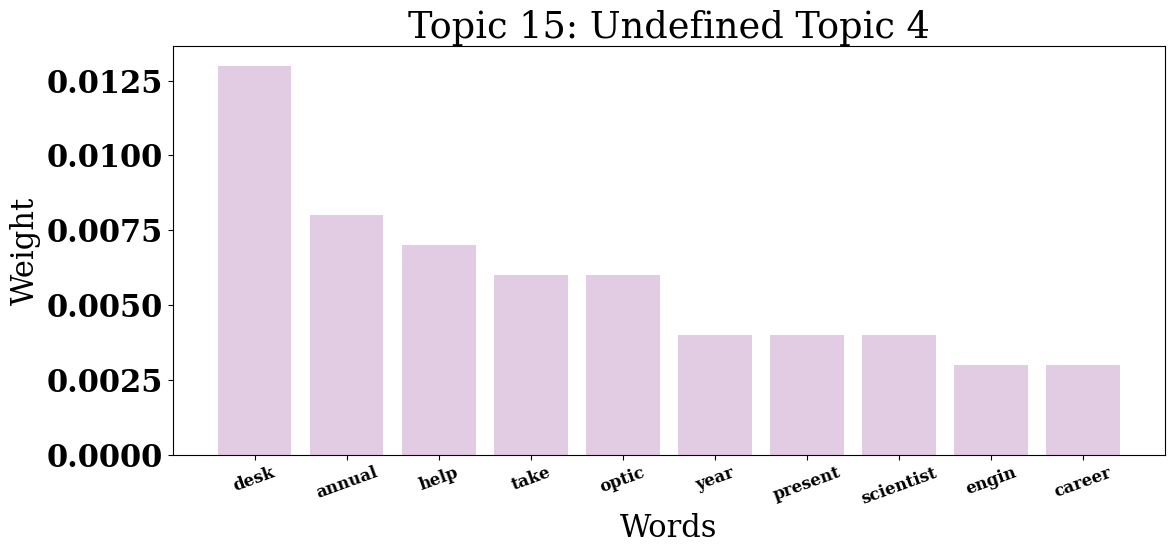

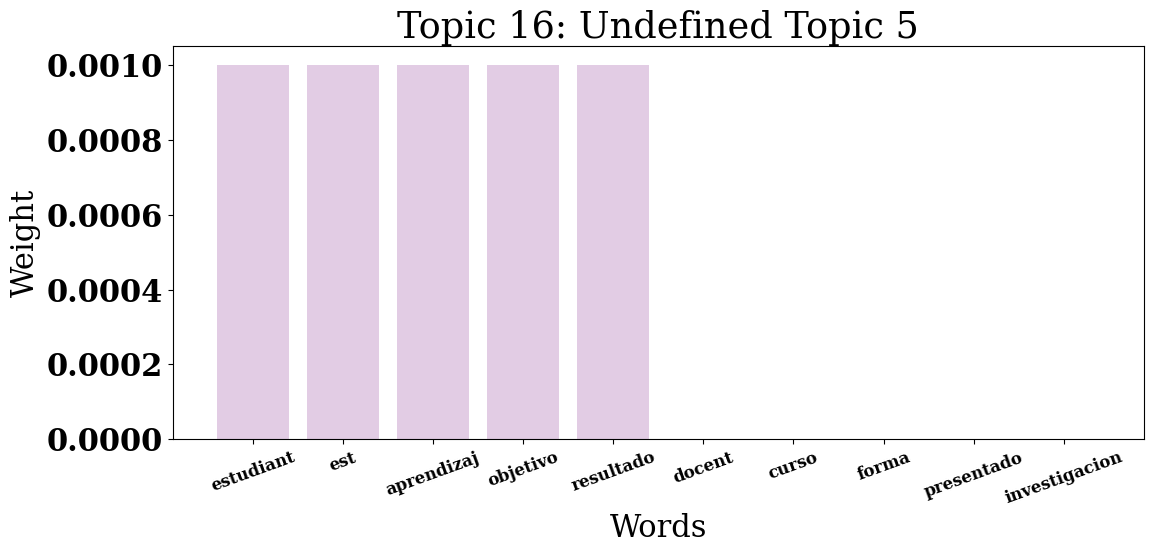

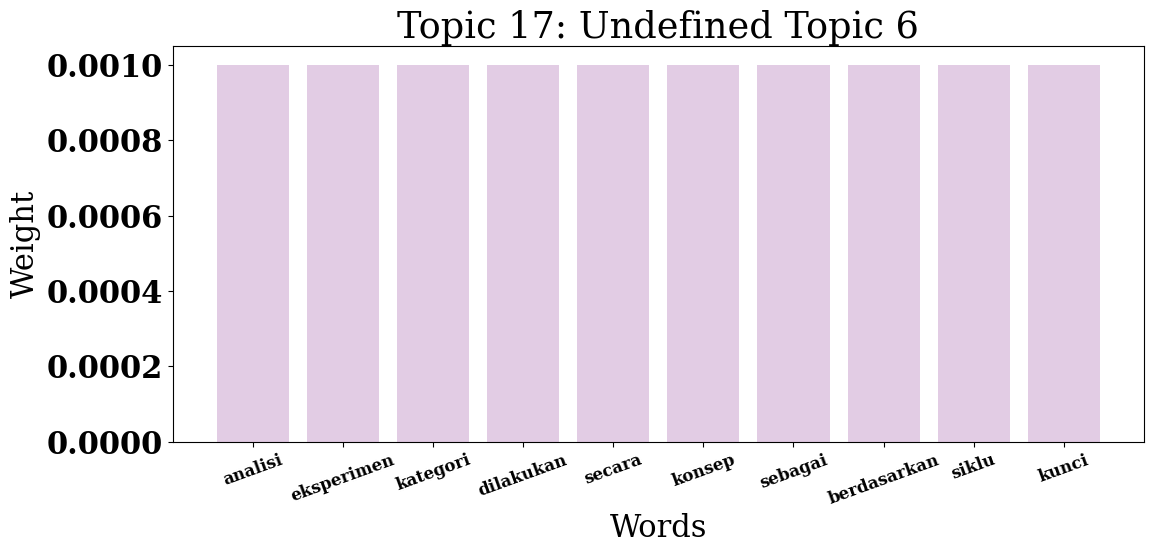

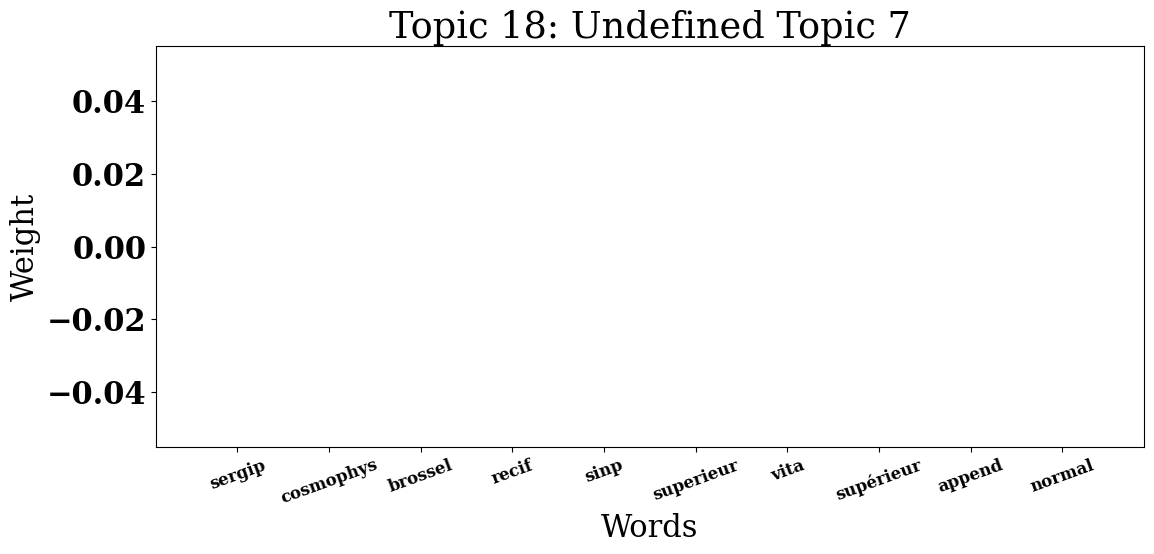

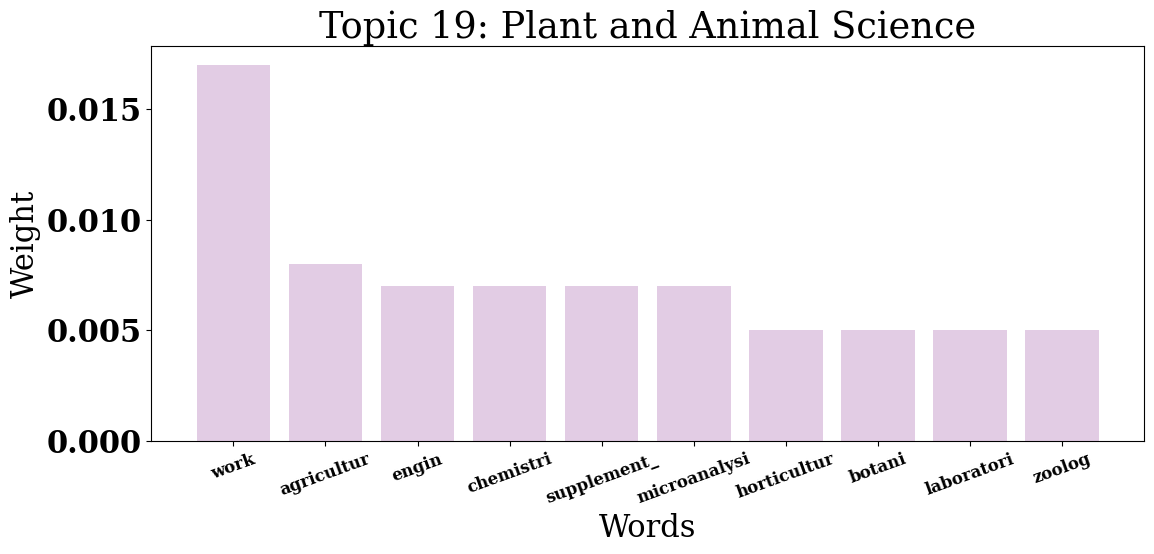

In [277]:
#plot topic labels and their respective words and weight 
plot_topic_weights(topics_tfidf)

## Topic Assignment 

In [60]:
#create a function that calculates and returns the max score of each article per possible topic
def max_topic_score(corpus_tfidf, lda_model_tfidf, modelname=None):
    
    max_scores = {}

    for doc_index, doc in enumerate(corpus_tfidf):
        max_score = None
        max_index = None

        for index, score in sorted(lda_model_tfidf[doc], key=lambda tup: -1 * tup[1]):
            if max_score is None or score > max_score:
                max_score = score
                max_index = index

        # Store both the max score and its topic index in the dictionary 
        max_scores[doc_index] = {f'topic_max_score': max_score, f'topic_index': max_index}

    # Move the return statement outside the loop
    max_scores_df = pd.DataFrame(max_scores).T
    return max_scores_df


In [63]:
max_scores=max_topic_score(corpus_tfidf, lda_model_tfidf)

In [64]:
max_scores

topic_max_score  topic_index
0              0.574908         11.0
1              0.923773         10.0
2              0.960802         10.0
3              0.951620         14.0
4              0.578325         11.0
...                 ...          ...
465719         0.952246          4.0
465720         0.969499         11.0
465721         0.965539          7.0
465722         0.967984          7.0
465723         0.686983          4.0

[465724 rows x 2 columns]

In [65]:
#define text dataset and reset index to match our corpus tfidf index
text_dataset=text_data.reset_index()
#take the same index of our text data as is in the processed docs (which the corpus is created from) to ensure we merge back on the matching article 
#when merging with max scores 
text_dataset=text_dataset.loc[text_dataset.index.isin(processed_docs.index)] #this is what we need 
#drop the old "index" column
text_dataset=text_dataset.drop(columns={'index'})

In [66]:
len(text_dataset)-len(max_scores) #check that they are now the same length 
#they match in length so now we just need to match and merge on their index

-13924

In [67]:
#reset index on text_dataset AGAIN to make it match with index of match score 
text_dataset=text_dataset.reset_index()
#drop the old "index" column AGAIN
text_dataset=text_dataset.drop(columns={'index'})

In [68]:
#finally join our max scores and text data 
text_dataset=text_dataset.join(max_scores)

In [69]:
#then merge with topic labels for max score per article 
text_dataset=pd.merge(text_dataset, topics_tfidf, on='topic_index')

In [286]:
#distribution of topics 

In [287]:
short_names=text_dataset.topic_index.value_counts().reset_index().topic_index.astype(str).tolist()

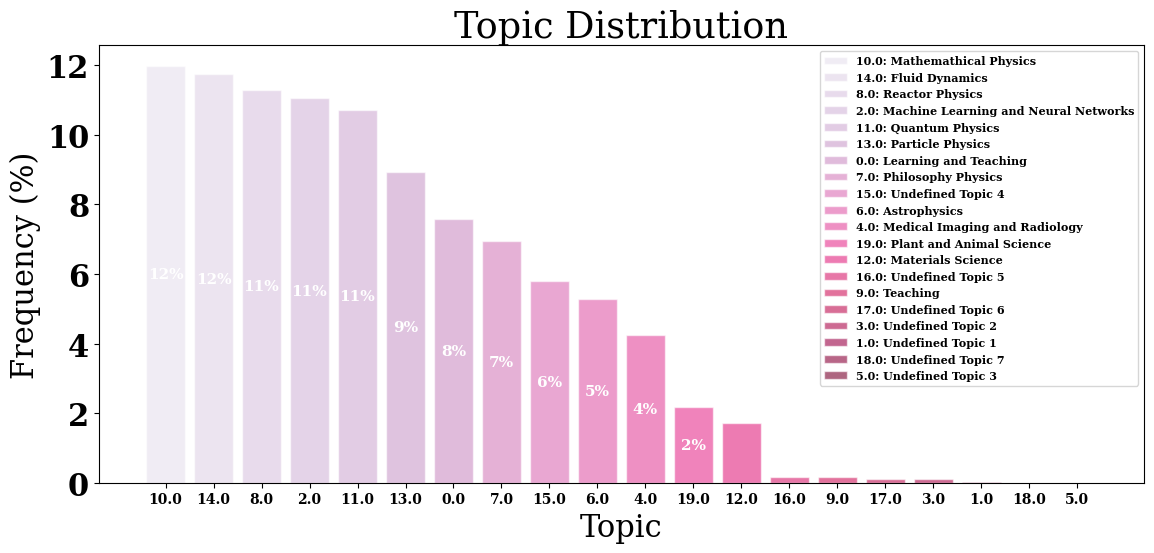

In [288]:
cat_plot_short_names(text_dataset.topic_label, title='Topic Distribution', xlabel='Topic', ylabel='Frequency (%)', norm=True, multiply=100, font=None, rot=0, xmargins=None, save_name='Topic_dist', legend_labels=None, short_names=short_names)



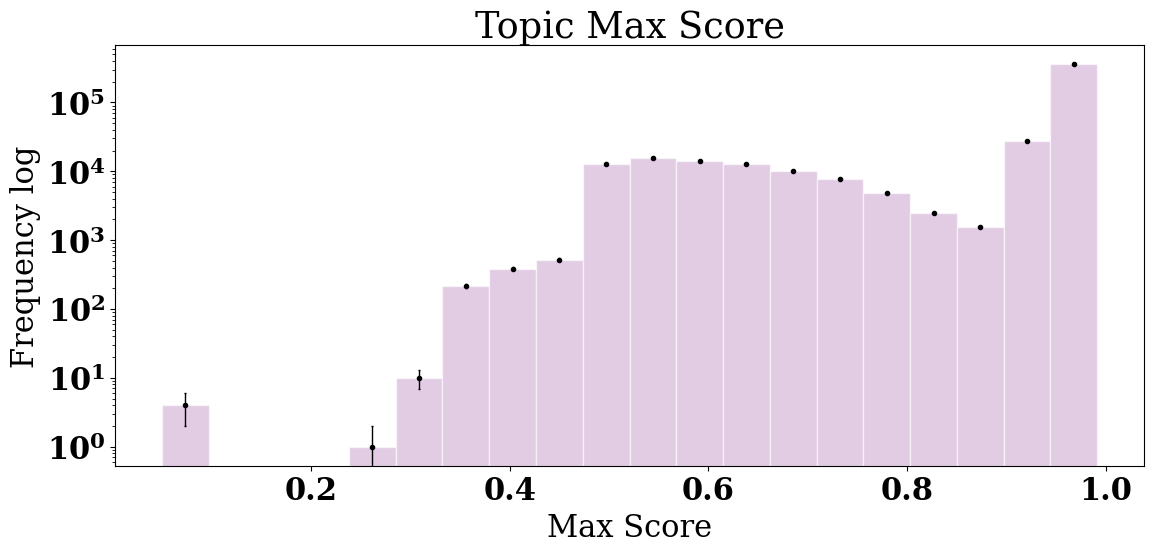

In [289]:
#plot topic score distribution 
hist_plot([text_dataset.topic_max_score], N_bins=None, log=True, title='Topic Max Score', xlabel='Max Score', ylabel='Frequency log', xmargins=None, save_name='topic_max_score', legend_labels=None, disp_legend=False)


In [154]:
len(text_dataset_threshold)

462541

# Topics

In [70]:
#merge text_dataset with full dataset 
topics_data=pd.merge(article_author_data_final, text_dataset, on ='article_id')

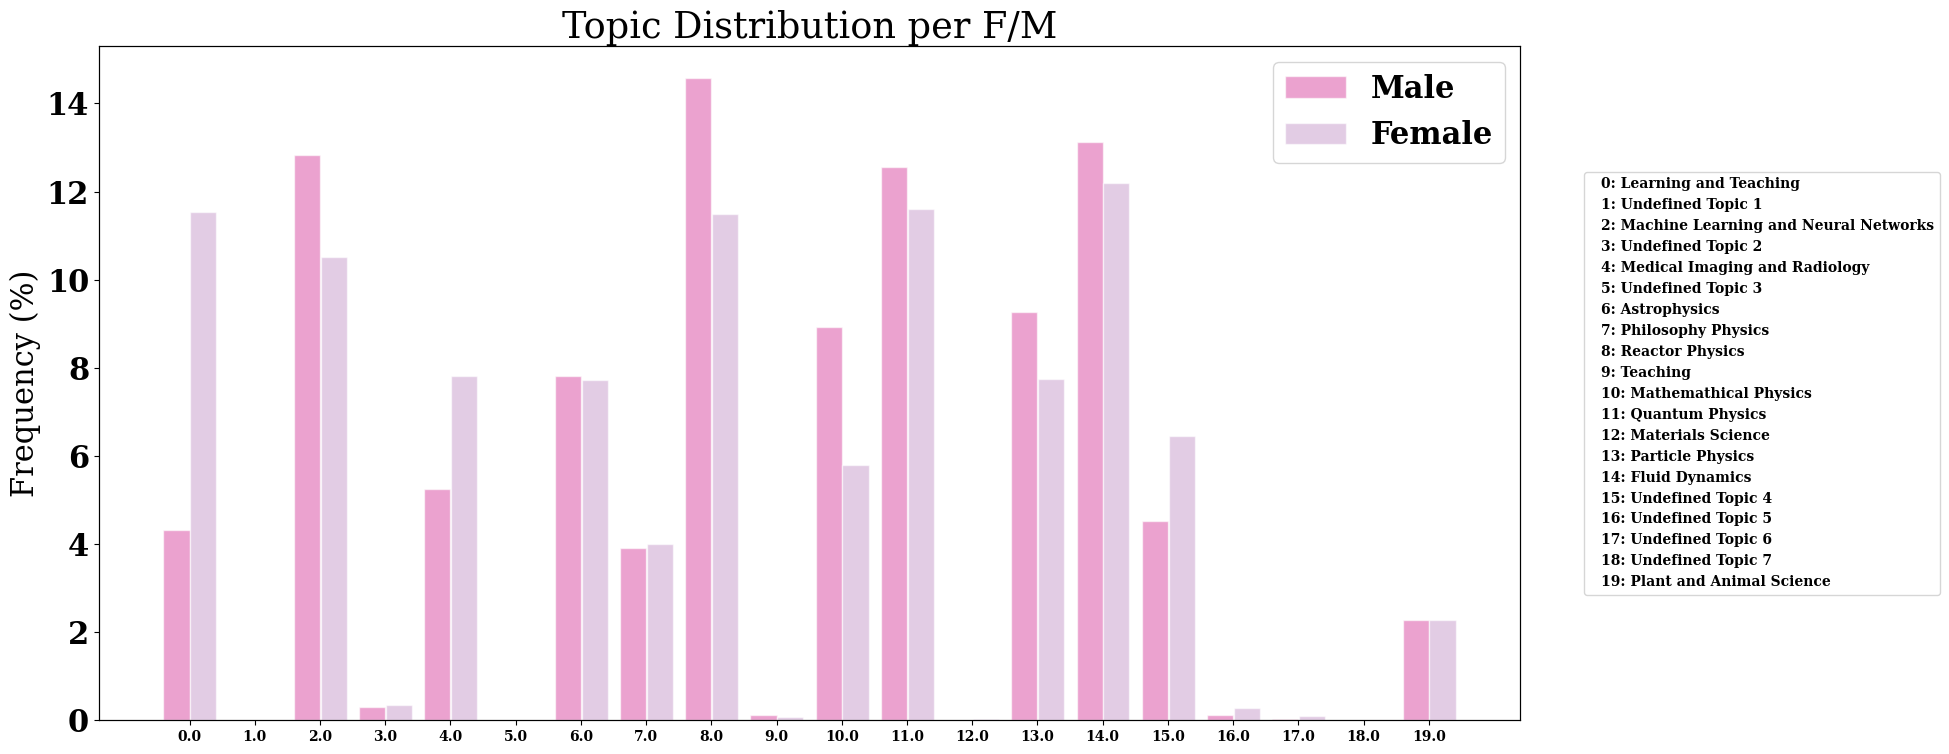

In [291]:
cat_plot_compare_short_names(topics_data['topic_index'][topics_data.binary_gender=='male'], topics_data['topic_index'][topics_data.binary_gender=='female'], 
                             topics_tfidf[['topic_index', 'topic_label']], title='Topic Distribution per F/M', xlabel=None, ylabel='Frequency (%)', norm=True, multiply=100, 
                             font=None, rot=0, xmargins=None, ymargins=None, save_name='RawTopicsGender', label1='Male', label2='Female')

#this plot does not take into account that this is potentially the same authors publishing several times within one subject 

In [292]:
#why is materials science so low?
topics_data['binary_gender'][topics_data.topic_label=='Materials Science'].isna().sum()/len(topics_data['binary_gender'][topics_data.topic_label=='Materials Science'])*100 
#okay so apperently the ones publishing within materials science isna 
#or at least a last fraction compared to the small fraction overall anyways 

98.40871829491753

## Clean Topics 

In [65]:
#discard the undefined topics for now 

In [71]:
topics_data.drop(topics_data.loc[topics_data['topic_label'].str.contains("Undefined")].index, inplace=True)


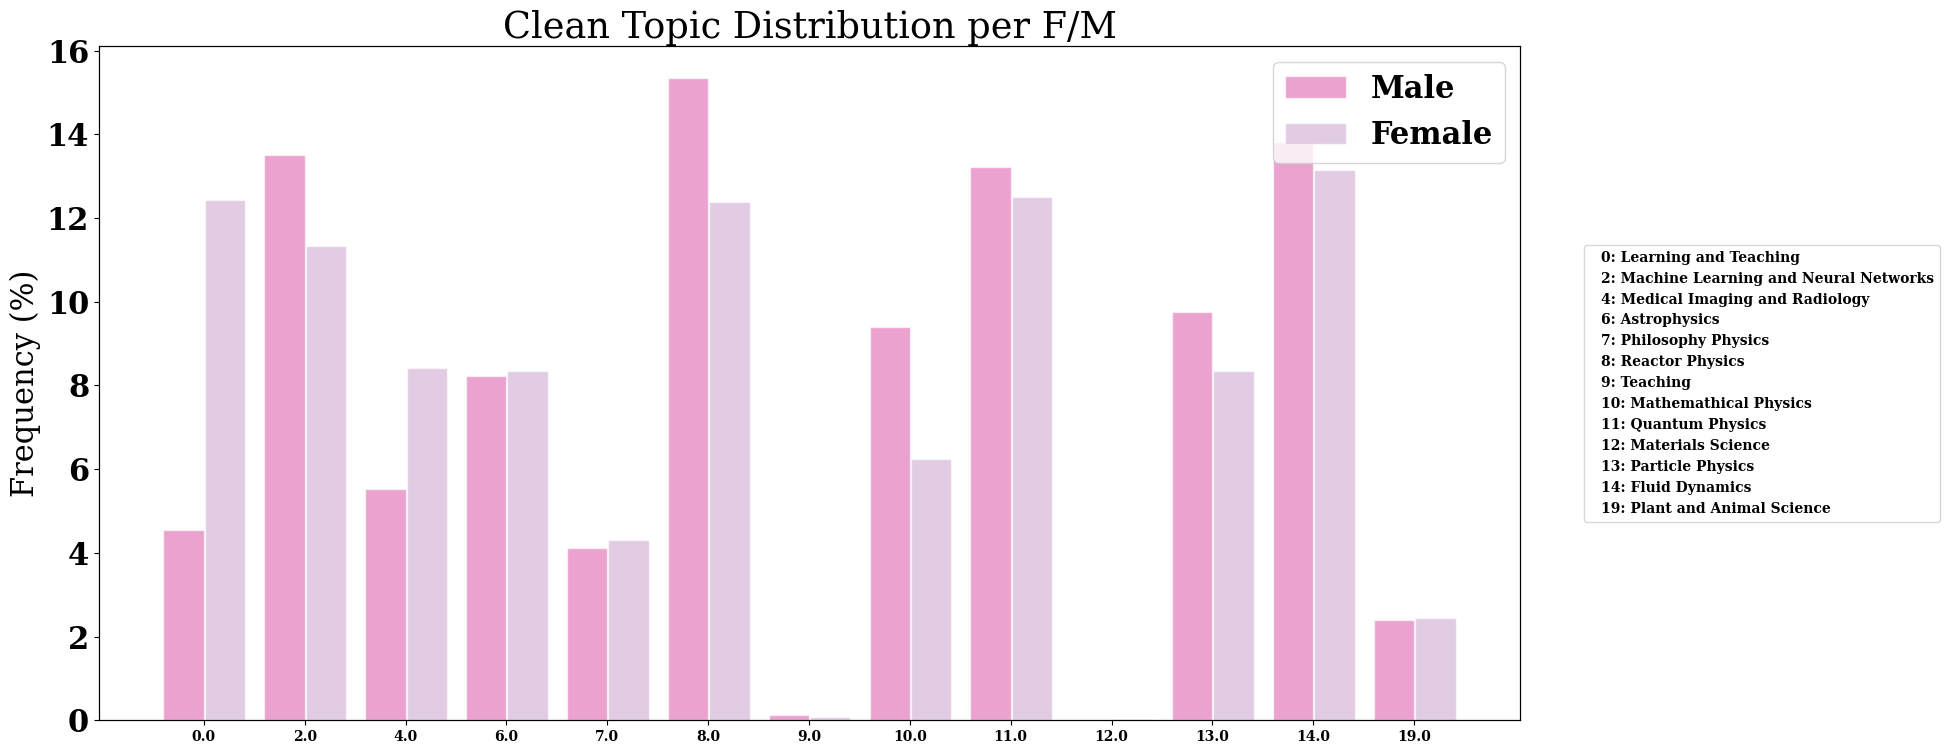

In [294]:
cat_plot_compare_short_names(topics_data['topic_index'][topics_data.binary_gender=='male'], topics_data['topic_index'][topics_data.binary_gender=='female'], 
                             topics_tfidf[['topic_index', 'topic_label']], title='Clean Topic Distribution per F/M', xlabel=None, ylabel='Frequency (%)', norm=True, multiply=100, 
                             font=None, rot=0, xmargins=None, ymargins=None, save_name='CleanTopicsGender', label1='Male', label2='Female')


In [72]:

# Define a function to map topic indices to domain labels
def map_to_domain(topic_index):
    if topic_index in [2, 2, 4, 6, 8, 9, 10, 11, 12, 13, 14, 19]:
        return "research"
    elif topic_index in [0, 9, 7]:
        return "review"
    else:
        return "undefined"  # or any other default label you prefer

topics_data['domain'] = topics_data['topic_index'].apply(lambda x: map_to_domain(x))


In [73]:
#save and load topics data 
with open(f'Data backup/topics_data_clean{str(date.today())}.pkl', 'wb') as f:
    pickle.dump(topics_data, f) #2024-03-20


In [127]:
#import fresh data 
with open('Data backup/topics_data_clean2024-03-20.pkl', 'rb') as f:
    topics_data = pickle.load(f)

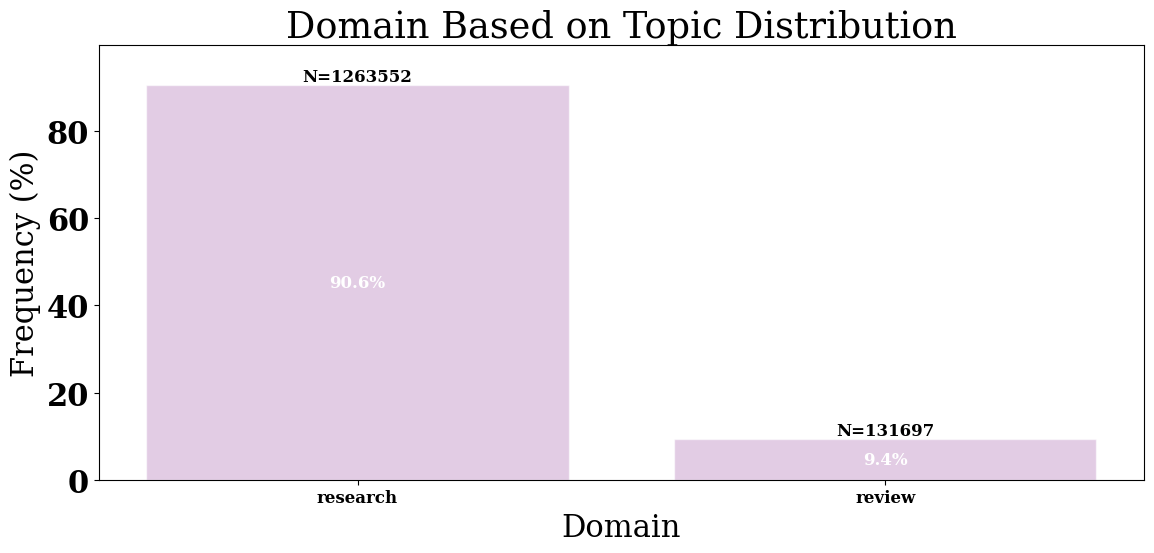

In [297]:
#domain distribution 
cat_plot(topics_data.domain, title='Domain Based on Topic Distribution', xlabel='Domain', ylabel='Frequency (%)', norm=True, multiply=100, font=None, rot=0, xmargins=0.05, ymargins=0.1, save_name='domaine_dist')


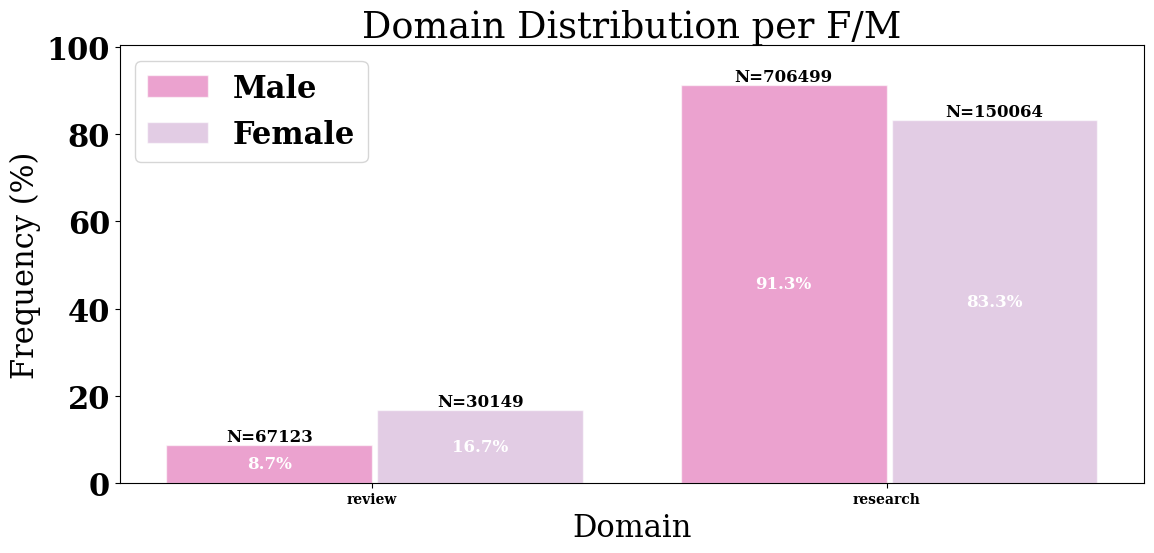

In [298]:
cat_plot_compare(topics_data['domain'][topics_data.binary_gender=='male'], topics_data['domain'][topics_data.binary_gender=='female'], title='Domain Distribution per F/M', xlabel='Domain', ylabel='Frequency (%)', norm=True, multiply=100, font=None, rot=0, xmargins=0.05, ymargins=0.1, save_name='DomainGender', label1='Male', label2='Female')


In [282]:
#test if there is a significant diff between male/female within the two categories 

In [299]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(topics_data['domain'], topics_data['binary_gender'])

# Perform the chi-square test of independence
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Print the results
print("Chi-square statistic:", chi2)
print("p-value:", p_value)
print("Degrees of freedom:", dof)
print("\nObserved Contingency Table:")
print(contingency_table)
print("\nExpected Contingency Table:")
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("\nThere is a significant difference in the distribution of genders within the domains.")
else:
    print("\nThere is no significant difference in the distribution of genders within the domains.")


Chi-square statistic: 10349.987360744784
p-value: 0.0
Degrees of freedom: 1

Observed Contingency Table:
binary_gender  female    male
domain                       
research       150064  706499
review          30149   67123

Expected Contingency Table:
binary_gender         female           male
domain                                     
research       161834.895888  694728.104112
review          18378.104112   78893.895888

There is a significant difference in the distribution of genders within the domains.


In [360]:
# author position topics 

In [389]:
topics_position=topics_data.groupby('topic_label')[['predicted_gender','author_position']].value_counts().reset_index() #remmber update this to binary_gender

In [398]:
topics_position=test_data_topics_position[test_data_topics_position.predicted_gender.isin(['female', 'male'])] #we don't have to do this with binary gender

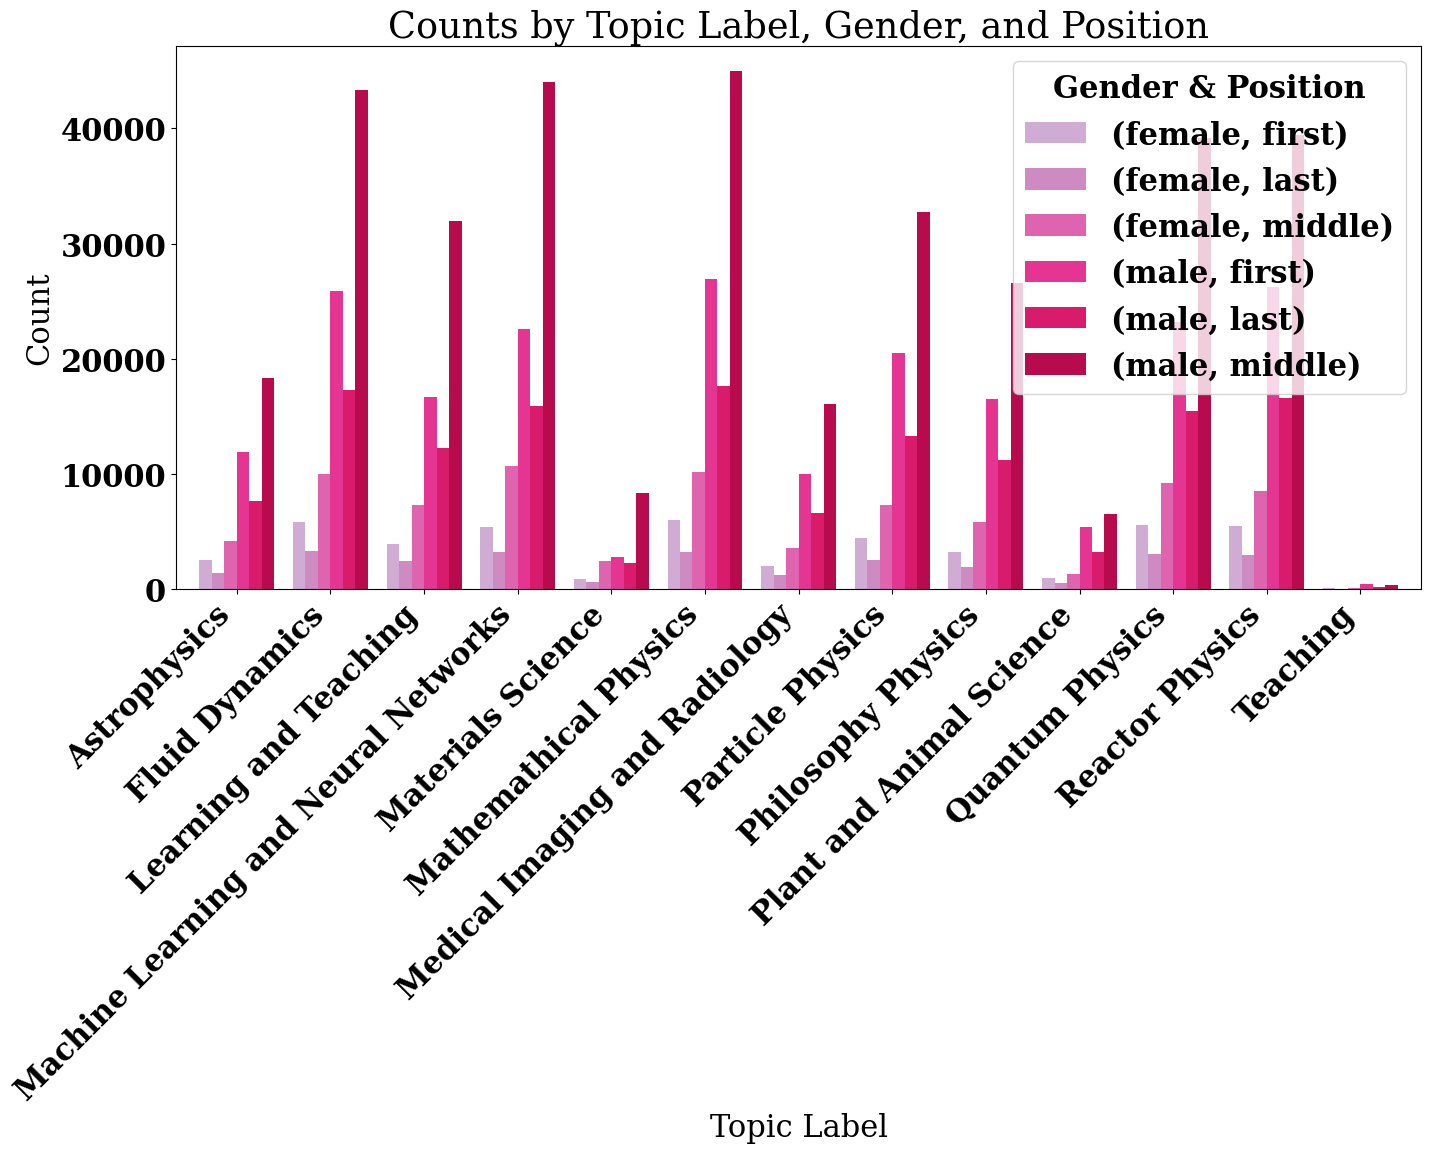

In [411]:

topics_position_pivot = topics_position.pivot_table(index='topic_label', columns=['predicted_gender', 'author_position'], values='count', fill_value=0)

# Plotting
topics_position_pivot.plot(kind='bar', figsize=(15, 12), width=0.8)
plt.title('Counts by Topic Label, Gender, and Position')
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Gender & Position')
plt.tight_layout()
plt.show()

#this should be normalised according to the total number of authors - but should it be according to authors all over or authors within that topic or authors of that gender? 
#update to have x-ticks as index and legend with topic labels I guess 

# Citations  

Find average citattions per author 

In [300]:
cites_per_author = topics_data.groupby('author_id')['cited_by_count'].transform('mean')
topics_data['author_mean_cites'] = cites_per_author


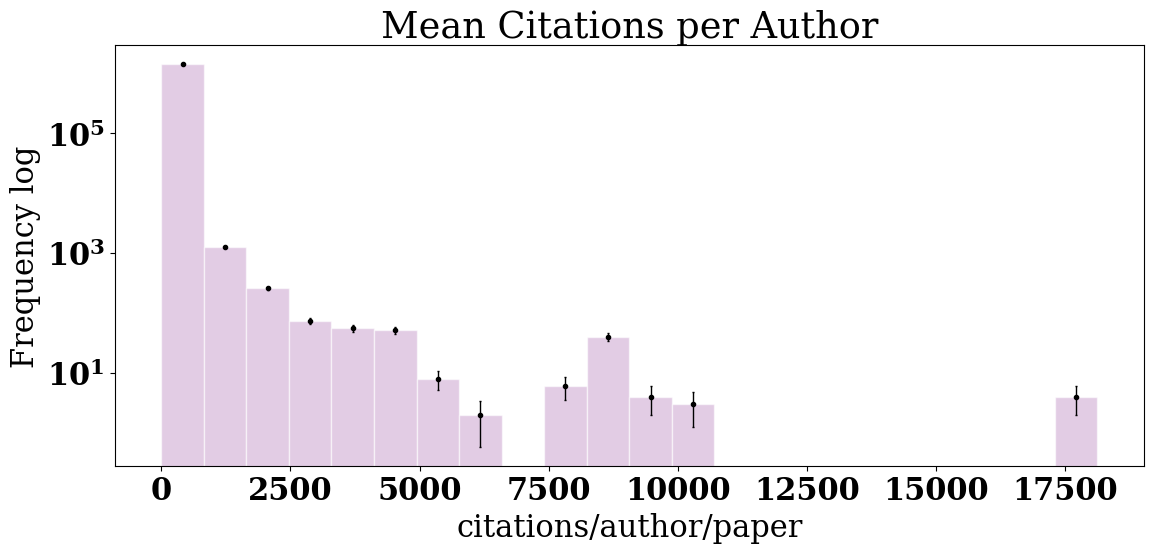

In [301]:
hist_plot([topics_data.author_mean_cites], N_bins=None, log=True, title='Mean Citations per Author', xlabel='citations/author/paper', ylabel='Frequency log', xmargins=None, save_name='citations_per_author', legend_labels=None, disp_legend=False)


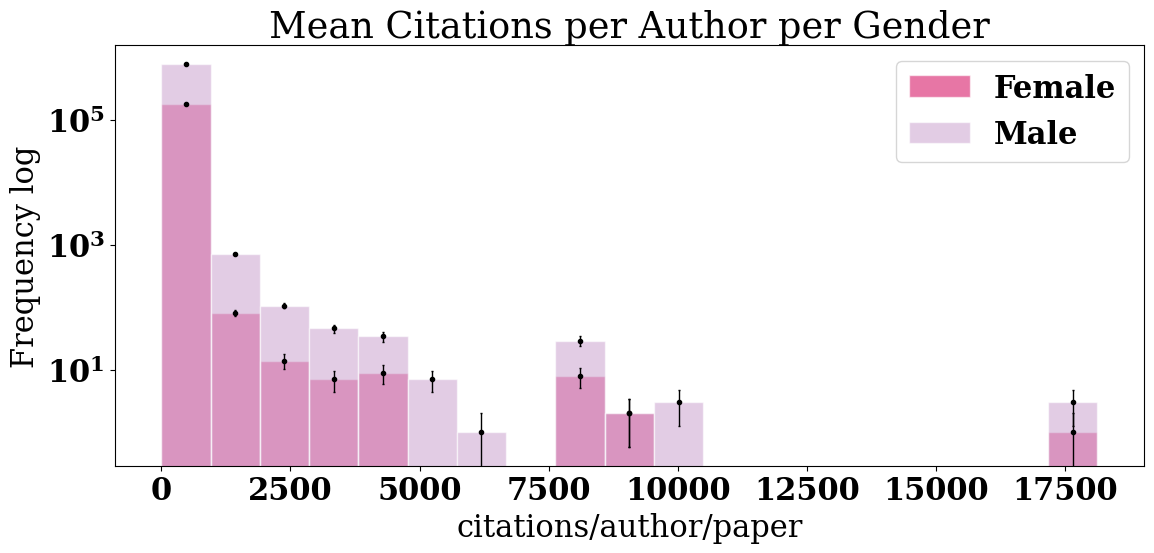

In [302]:
hist_plot([topics_data.author_mean_cites[topics_data.binary_gender=='female'], topics_data.author_mean_cites[topics_data.binary_gender=='male']], N_bins=None, log=True, title='Mean Citations per Author per Gender', xlabel='citations/author/paper', ylabel='Frequency log', xmargins=None, save_name='citations_per_author', legend_labels=['Female', 'Male'], disp_legend=True)


In [303]:
#citations per topic 

In [304]:
avg_cites_topics=pd.DataFrame(topics_data.groupby('topic_label')[['topic_index','author_mean_cites']].mean().reset_index())
avg_cites_topics_err=pd.DataFrame(topics_data.groupby('topic_label')['author_mean_cites'].std().reset_index())

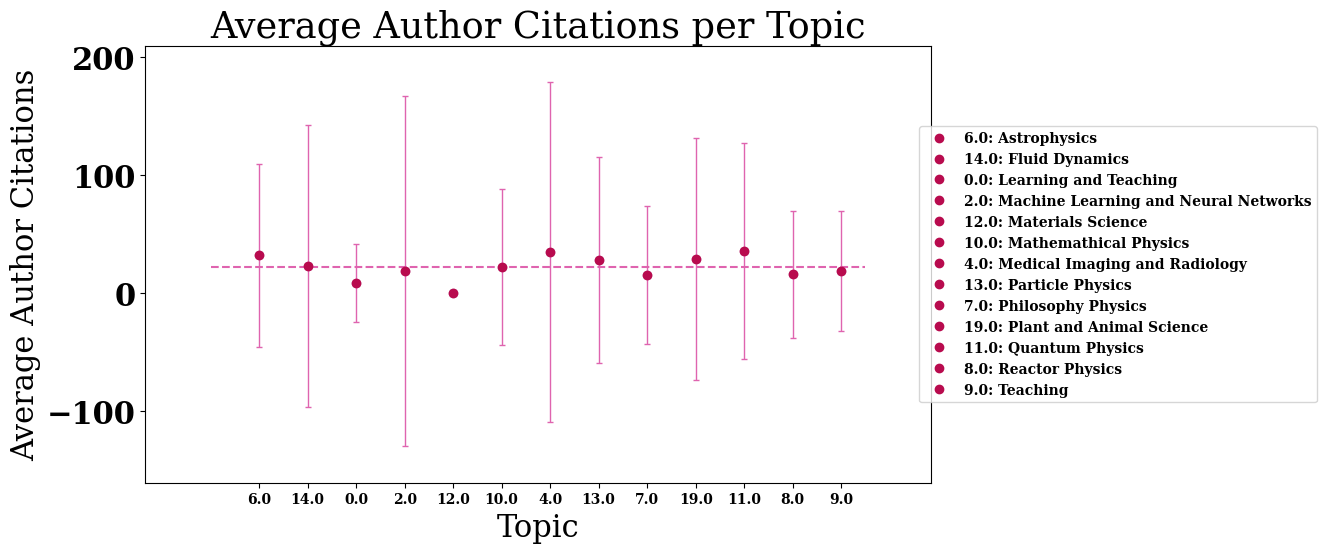

In [306]:
average_plot(avg_cites_topics.author_mean_cites, avg_cites_topics_err.author_mean_cites, title='Average Author Citations per Topic',
            xlabel='Topic', ylabel='Average Author Citations', rot=0,
            full_names=avg_cites_topics.topic_label, short_names=avg_cites_topics.topic_index, add_means=False)



In [259]:
#citations per domaine

In [307]:
topics_data.groupby('domain')['author_mean_cites'].mean()

domain
research    24.868703
review      10.893205
Name: author_mean_cites, dtype: float64

## University Ranking 

 institution name(id)/citationer/artikel For forfatter: hver artikel for forfatter gennemsnit citation + score fra institution: middel over alle artikler og se om der er en korrelation. Altså at de forfattere med høj citation også er høj institution/omvendt. Er der en korrelation og er det den samme?

In [308]:
#calculate number of citations per university (institution) 
cites_per_inst = article_author_data_final.groupby('institution_id')['cited_by_count'].transform('sum')
#count number of times each institution appear 
inst_count = article_author_data_final['institution_id'].value_counts()
#calculate our university ranking by dividing number of citations per papers 
inst_ranking = cites_per_inst / article_author_data_final['institution_id'].map(inst_count)
#save in a new column 
article_author_data_final['institution_ranking'] = inst_ranking


In [309]:
#now we do the exact same but also divided per year 
#calculate number of citations per university (institution) 
cites_per_inst_per_year = article_author_data_final.groupby(['publication_year', 'institution_id'])['cited_by_count'].transform('sum')
#count number of times each institution appear 
inst_count_per_year = article_author_data_final.groupby(['publication_year', 'institution_id']).size()
#calculate our university ranking by dividing number of citations per papers 
inst_ranking_per_year = cites_per_inst_per_year / article_author_data_final.set_index(['publication_year', 'institution_id']).index.map(inst_count_per_year)

#save in a new column 
article_author_data_final['institution_ranking_per_year'] = inst_ranking_per_year


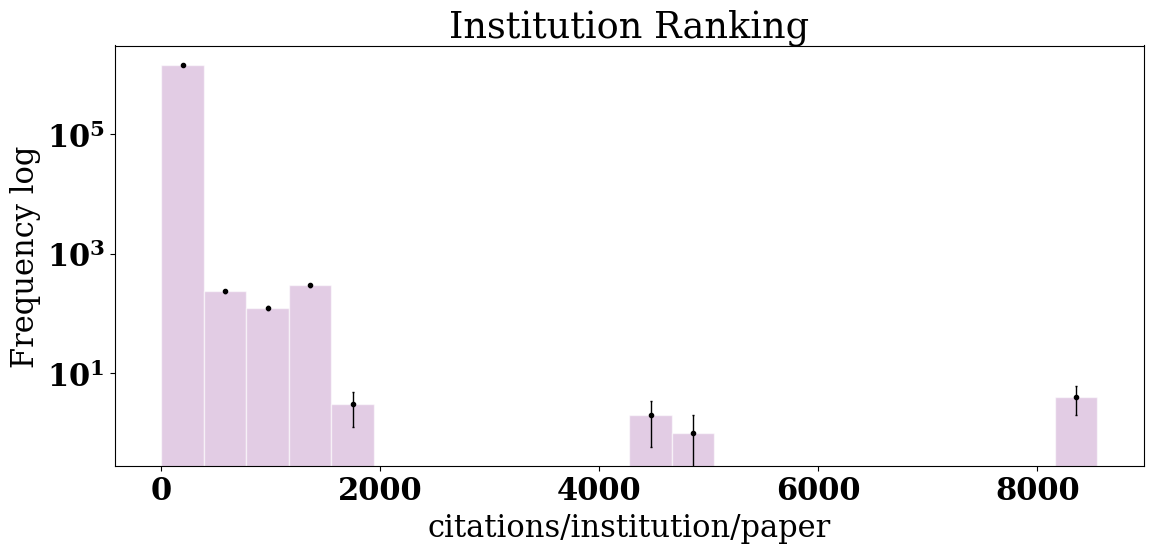

In [310]:
hist_plot([article_author_data_final.institution_ranking], N_bins=None, log=True, title='Institution Ranking', xlabel='citations/institution/paper', ylabel='Frequency log', xmargins=None, save_name='inst_ranking', legend_labels=None, disp_legend=False)


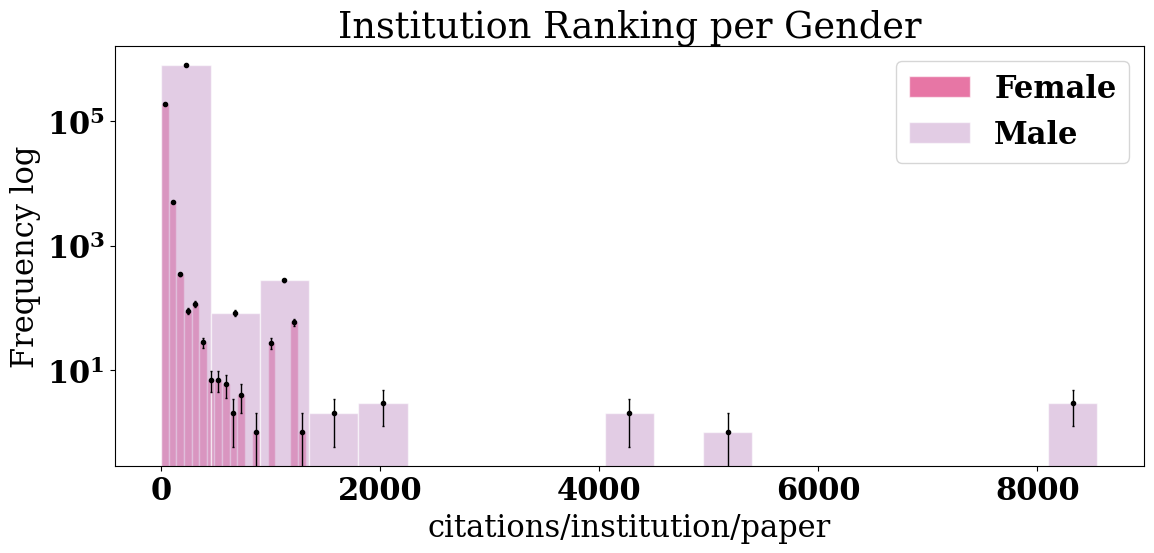

In [311]:
hist_plot([article_author_data_final.institution_ranking[article_author_data_final.binary_gender=='female'], article_author_data_final.institution_ranking[article_author_data_final.binary_gender=='male']], N_bins=None, log=True, title='Institution Ranking per Gender', xlabel='citations/institution/paper', ylabel='Frequency log', xmargins=None, save_name='inst_ranking_gender', legend_labels=['Female', 'Male'], disp_legend=True)


In [312]:
#define short names outside plotting function 
data_cats=article_author_data_final.drop_duplicates(subset=['institution_id'], keep='first')[['institution_name', 'institution_ranking']].dropna()
data_cats=data_cats.sort_values(by='institution_ranking', ascending=False).iloc[:, 0][0:10]
data_cats_labels=data_cats.reset_index()

excluded_words = ['THE', 'AND', 'OF', 'FOR']
short_names = []

def extract_first_letters(words):
    short_name = ''
    skip_next = False
    
    for word in words:
        if skip_next:
            skip_next = ')' not in word
        elif '(' in word:
            skip_next = ')' not in word
        else:
            short_name += word[0]

    return short_name

for cat in data_cats:
    words = [word.upper() for word in cat.split() if word.upper() not in excluded_words]
    unique_short_name = extract_first_letters(words)
    
    # Check for duplicates and add a unique identifier
    count = short_names.count(unique_short_name)
    if count > 0:
        unique_short_name += str(count + 1)
    
    short_names.append(unique_short_name)

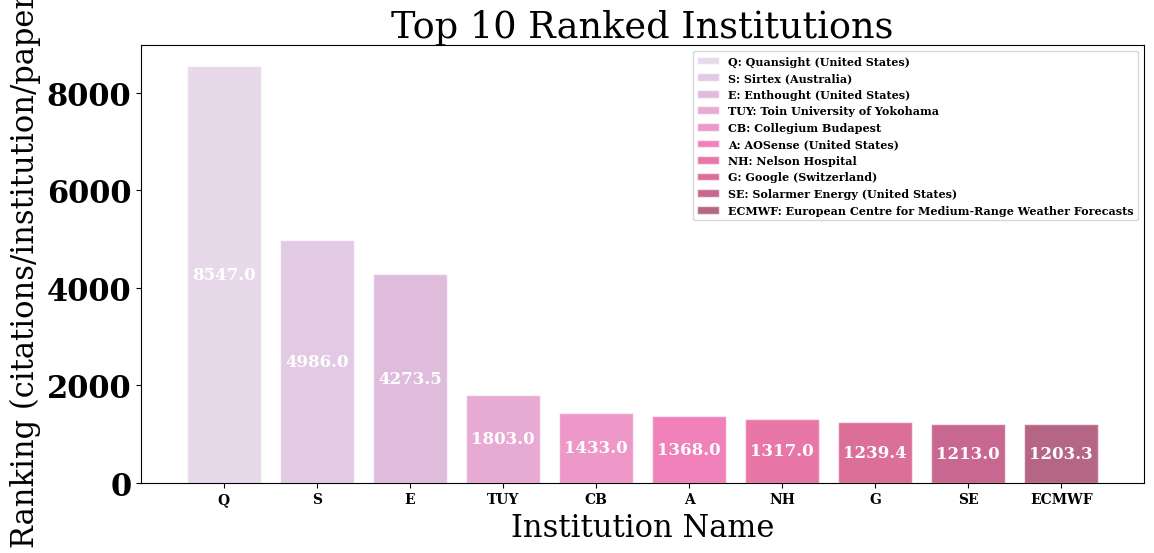

In [313]:
cat_value_top_plot_short_names(article_author_data_final.drop_duplicates(subset=['institution_id'], keep='first')[['institution_name', 'institution_ranking']].dropna(), sort_col='institution_ranking', top_n=10, title='Top 10 Ranked Institutions', xlabel='Institution Name', ylabel='Ranking (citations/institution/paper)', norm=False, multiply=1, font=None, rot=0, xmargins=None, save_name='top10inst_ranking', legend_labels=np.array([f'{short_names[i]}: {data_cats_labels.institution_name[i]}' for i in range(len(data_cats_labels))]), short_names=short_names)


In [314]:
#check for only universities 

In [315]:
university_data=article_author_data_final[article_author_data_final.institution_type=='education']
# we could also search for institution_name.str.contains('University') instead ? 

In [316]:
#define short names outside plotting function 
data_cats=university_data.drop_duplicates(subset=['institution_id'], keep='first')[['institution_name', 'institution_ranking']].dropna()
data_cats=data_cats.sort_values(by='institution_ranking', ascending=False).iloc[:, 0][0:20]
data_cats_labels=data_cats.reset_index()

excluded_words = ['THE', 'AND', 'OF', 'FOR']
short_names = []

def extract_first_letters(words):
    short_name = ''
    skip_next = False
    
    for word in words:
        if skip_next:
            skip_next = ')' not in word
        elif '(' in word:
            skip_next = ')' not in word
        else:
            short_name += word[0]

    return short_name

for cat in data_cats:
    words = [word.upper() for word in cat.split() if word.upper() not in excluded_words]
    unique_short_name = extract_first_letters(words)
    
    # Check for duplicates and add a unique identifier
    count = short_names.count(unique_short_name)
    if count > 0:
        unique_short_name += str(count + 1)
    
    short_names.append(unique_short_name)

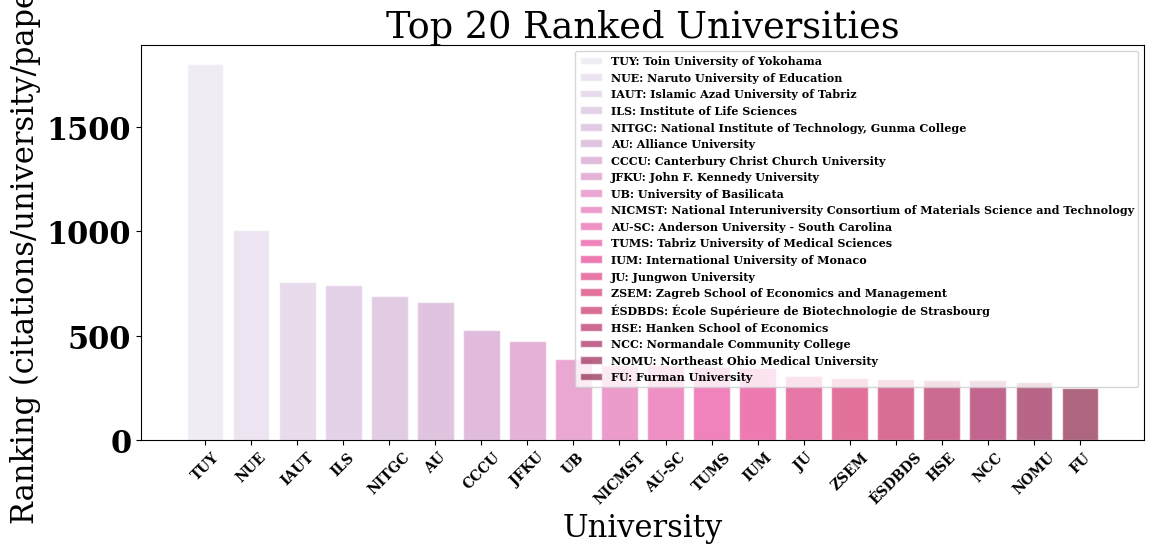

In [317]:
cat_value_top_plot_short_names(university_data.drop_duplicates(subset=['institution_id'], keep='first')[['institution_name', 'institution_ranking']].dropna(), sort_col='institution_ranking', top_n=20, title='Top 20 Ranked Universities', xlabel='University', ylabel='Ranking (citations/university/paper)', norm=False, multiply=1, font=None, rot=45, xmargins=None, save_name='top10university_ranking', legend_labels=np.array([f'{short_names[i]}: {data_cats_labels.institution_name[i]}' for i in range(len(data_cats_labels))]), short_names=short_names)


## Journal Ranking 

In [1385]:
#now let's do the same but for each journal 

In [318]:
#calculate number of citations per university (institution) 
cites_per_journal = article_author_data_final.groupby('journal_id')['cited_by_count'].transform('sum')
#count number of times each institution appear 
journal_count = article_author_data_final['journal_id'].value_counts()
#calculate our university ranking by dividing number of citations per papers 
journal_ranking = cites_per_journal / article_author_data_final['journal_id'].map(journal_count)
#save in a new column 
article_author_data_final['journal_ranking'] = journal_ranking


In [319]:
#now we do the exact same but also divided per year 
#calculate number of citations per university (institution) 
cites_per_journal_per_year = article_author_data_final.groupby(['publication_year', 'journal_id'])['cited_by_count'].transform('sum')
#count number of times each institution appear 
journal_count_per_year = article_author_data_final.groupby(['publication_year', 'journal_id']).size()
#calculate our university ranking by dividing number of citations per papers 
journal_ranking_per_year = cites_per_journal_per_year / article_author_data_final.set_index(['publication_year', 'journal_id']).index.map(journal_count_per_year)

#save in a new column 
article_author_data_final['journal_ranking_per_year'] = journal_ranking_per_year


In [320]:
#skal vi lige normalisere de her rankings i forhold til sig selv ?

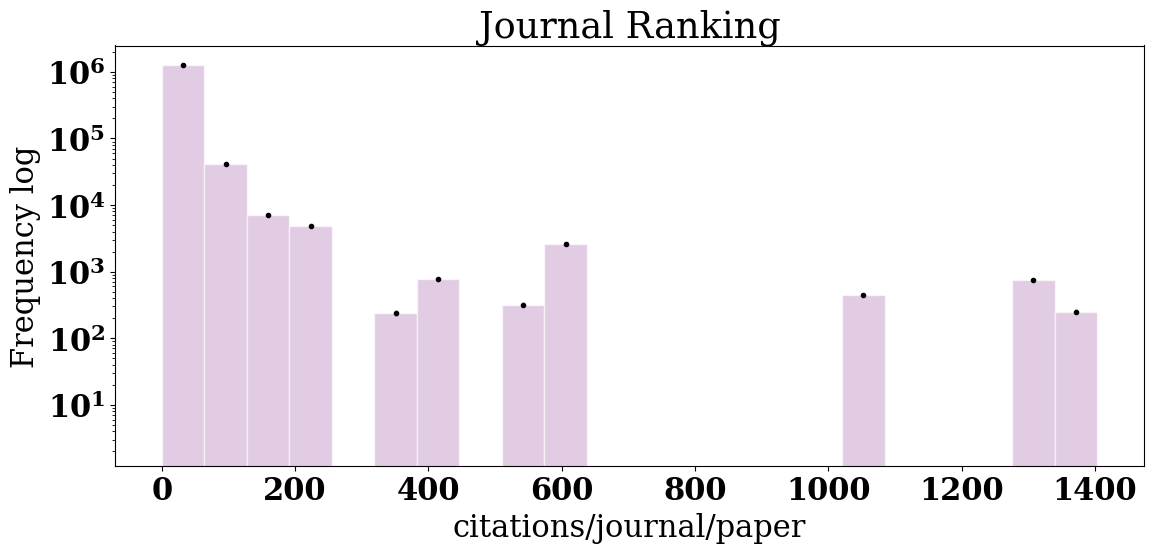

In [321]:
hist_plot([article_author_data_final.journal_ranking], N_bins=None, log=True, title='Journal Ranking', xlabel='citations/journal/paper', ylabel='Frequency log', xmargins=None, save_name='journal_ranking', legend_labels=None, disp_legend=False)


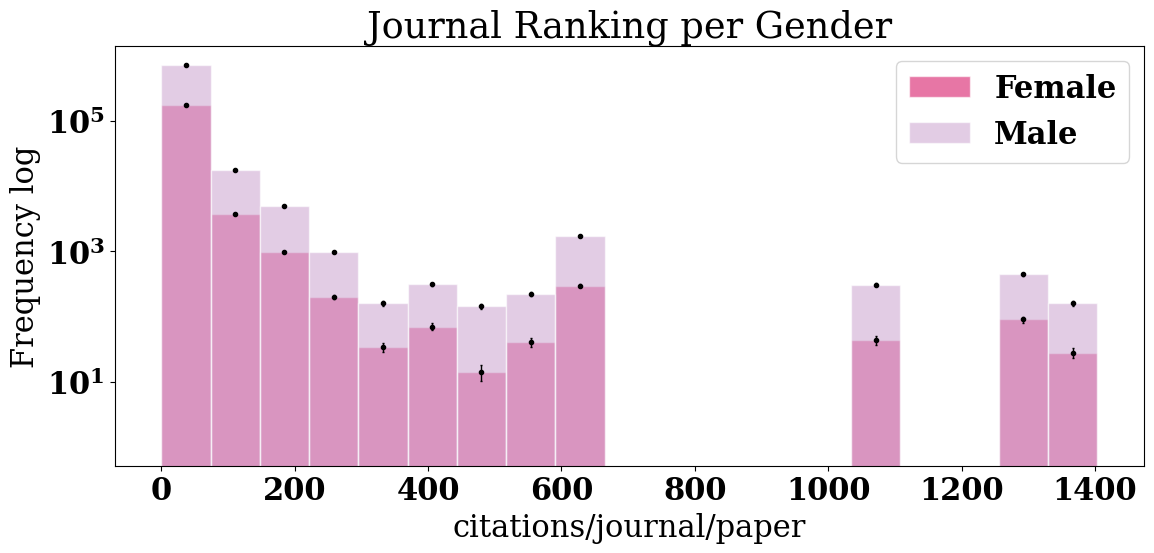

In [322]:
hist_plot([article_author_data_final.journal_ranking[article_author_data_final.binary_gender=='female'], article_author_data_final.journal_ranking[article_author_data_final.binary_gender=='male']], N_bins=None, log=True, title='Journal Ranking per Gender', xlabel='citations/journal/paper', ylabel='Frequency log', xmargins=None, save_name='journal_ranking_gender', legend_labels=['Female', 'Male'], disp_legend=True)


In [323]:
#define short names outside plotting function 
data_cats=article_author_data_final.drop_duplicates(subset=['journal_id'], keep='first')[['journal_name', 'journal_ranking']].dropna()
data_cats=data_cats.sort_values(by='journal_ranking', ascending=False).iloc[:, 0][0:20]
data_cats_labels=data_cats.reset_index()

excluded_words = ['THE', 'AND', 'OF', 'FOR']
short_names = []

def extract_first_letters(words):
    short_name = ''
    skip_next = False
    
    for word in words:
        if skip_next:
            skip_next = ')' not in word
        elif '(' in word:
            skip_next = ')' not in word
        else:
            short_name += word[0]

    return short_name

for cat in data_cats:
    words = [word.upper() for word in cat.split() if word.upper() not in excluded_words]
    unique_short_name = extract_first_letters(words)
    
    # Check for duplicates and add a unique identifier
    count = short_names.count(unique_short_name)
    if count > 0:
        unique_short_name += str(count + 1)
    
    short_names.append(unique_short_name)

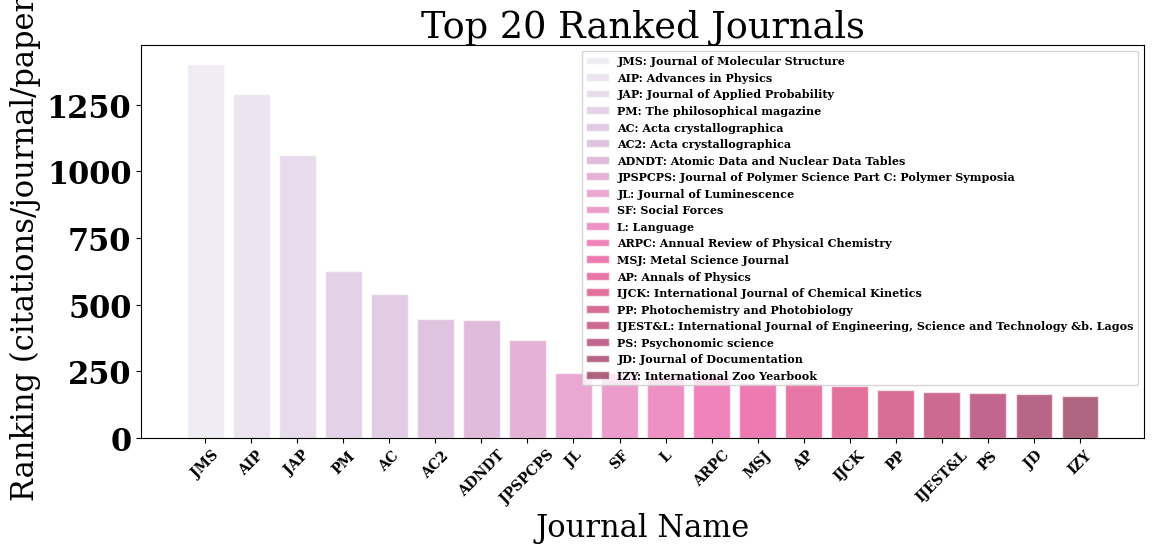

In [324]:
cat_value_top_plot_short_names(article_author_data_final.drop_duplicates(subset=['journal_id'], keep='first')[['journal_name', 'journal_ranking']].dropna(), sort_col='journal_ranking', top_n=20, title='Top 20 Ranked Journals', xlabel='Journal Name', ylabel='Ranking (citations/journal/paper)', norm=False, multiply=1, font=None, rot=45, xmargins=None, save_name='top10journal_ranking', legend_labels=np.array([f'{short_names[i]}: {data_cats_labels.journal_name[i]}' for i in range(len(data_cats_labels))]), short_names=short_names)


## Citations

In [335]:
#calculate number of citations per university (institution) 
author_mean_cites = article_author_data_final.groupby('author_id')['cited_by_count'].transform('sum')
#count number of times each institution appear 
author_count = article_author_data_final['author_id'].value_counts()
#calculate our university ranking by dividing number of citations per papers 
author_mean_cites_ranking = author_mean_cites / article_author_data_final['author_id'].map(author_count)
#save in a new column 
article_author_data_final['author_mean_cites'] = author_mean_cites_ranking


In [339]:
article_author_data_final.drop(columns={'author_cites'}, inplace=True)

## Prestige Correlations 

In [341]:
article_author_data_final.columns

Index(['article_id', 'doi', 'publication_year', 'publication_date', 'title',
       'cited_by_count', 'grants', 'abstract', 'journal_id', 'journal_name',
       'total_author_counts', 'author_position', 'author_countries',
       'is_corresponding', 'raw_affiliation_string', 'raw_author_name',
       'author.display_name', 'author_id', 'institution_country_code',
       'institution_name', 'institution_id', 'institution_type',
       'selected_full_name', 'extracted_first_name', 'country_name',
       'author_country_name', 'author_country_name_api', 'predicted_gender',
       'author_first_country', 'name_gender_api', 'gender_gender_api',
       'binary_gender', 'institution_ranking', 'institution_ranking_per_year',
       'journal_ranking', 'journal_ranking_per_year', 'author_mean_cites'],
      dtype='object')

In [345]:
#normalize ranking 
norm_author_cites=np.abs(pd.Series(preprocessing.normalize(article_author_data_final.author_mean_cites.dropna().values.reshape(-1, 1), axis=0).flatten()))
norm_inst_rank=np.abs(pd.Series(preprocessing.normalize(article_author_data_final.institution_ranking.dropna().values.reshape(-1, 1), axis=0).flatten()))
norm_journal_rank=np.abs(pd.Series(preprocessing.normalize(article_author_data_final.journal_ranking.dropna().values.reshape(-1, 1), axis=0).flatten()))


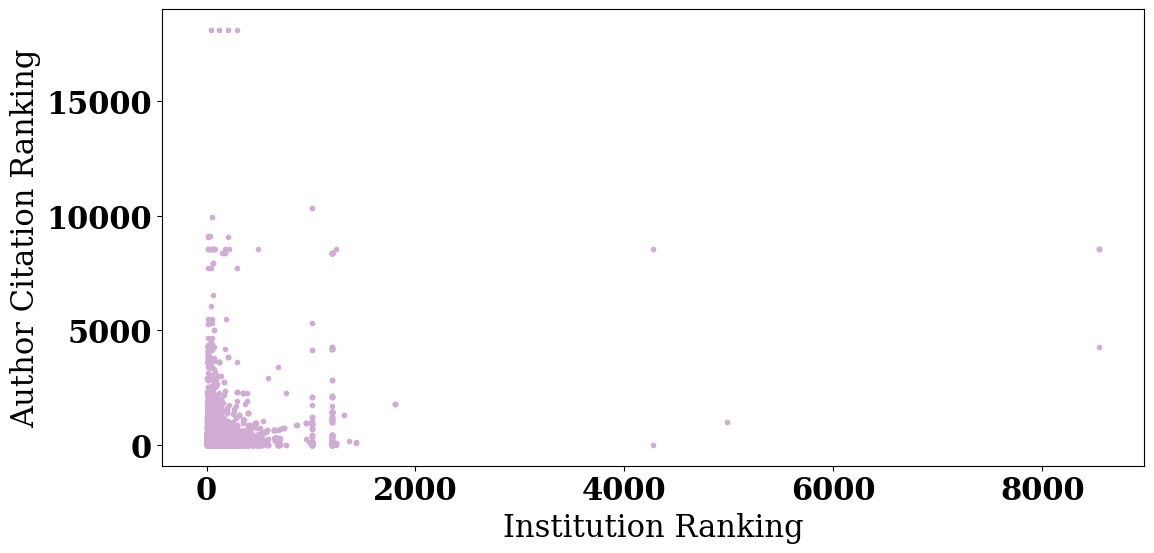

In [605]:
scatter_plot(article_author_data_final.institution_ranking, article_author_data_final.author_mean_cites, title=None, xlabel='Institution Ranking', ylabel='Author Citation Ranking', xmargins=None, new_figure=True, save_name='correlationInstRankAuthorCites')


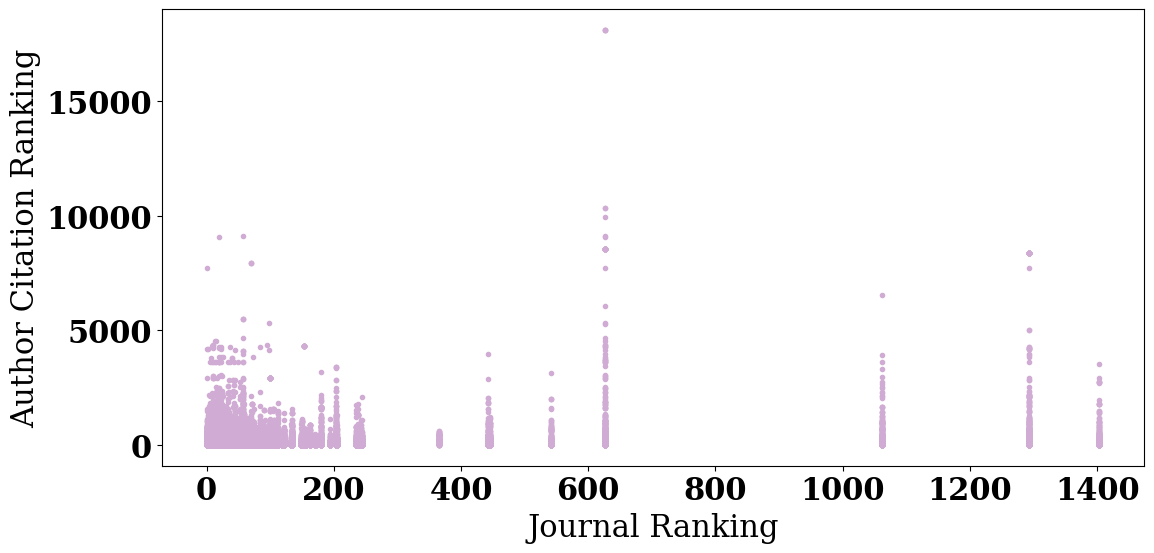

In [606]:
scatter_plot(article_author_data_final.journal_ranking, article_author_data_final.author_mean_cites, title=None, xlabel='Journal Ranking', ylabel='Author Citation Ranking', xmargins=None, new_figure=True, save_name='correlationJournalRankAuthorCites')


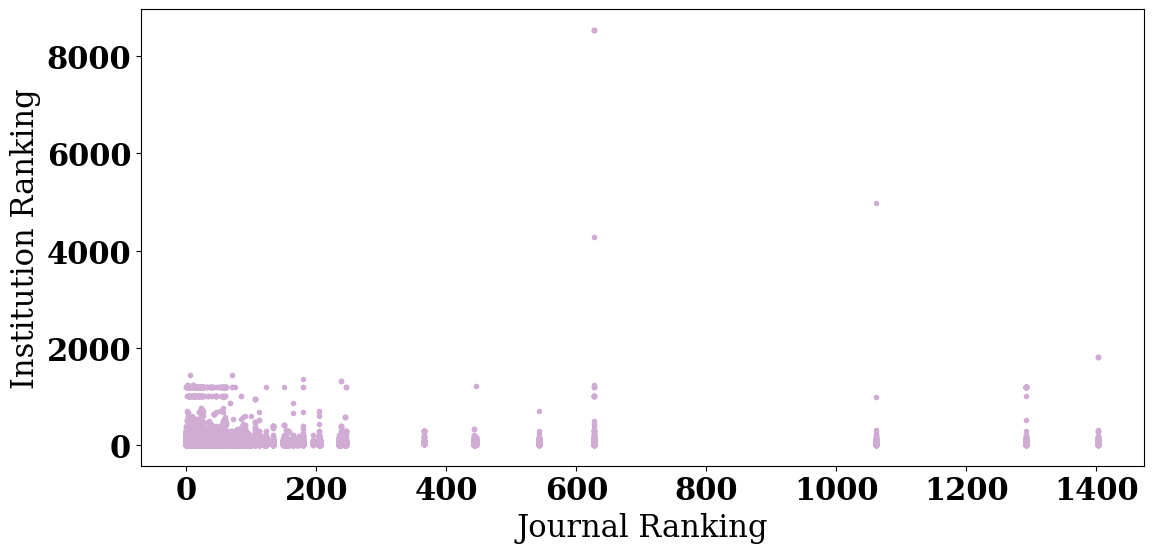

In [607]:
scatter_plot(article_author_data_final.journal_ranking, article_author_data_final.institution_ranking, title=None, xlabel='Journal Ranking', ylabel='Institution Ranking', xmargins=None, new_figure=True, save_name='correlationJournalRankInstRank')

#maybe we should check if there would be any correlations if we grouped the rankings into levels instead??? 

### Prestige correlations to topics 

In [380]:
#calculate all the same rankings but for our topic data instead 

In [381]:
#calculate number of citations per university (institution) 
cites_per_inst = topics_data.groupby('institution_id')['cited_by_count'].transform('sum')
#count number of times each institution appear 
inst_count = topics_data['institution_id'].value_counts()
#calculate our university ranking by dividing number of citations per papers 
inst_ranking = cites_per_inst / topics_data['institution_id'].map(inst_count)
#save in a new column 
topics_data['institution_ranking'] = inst_ranking


In [382]:
#now we do the exact same but also divided per year 
#calculate number of citations per university (institution) 
cites_per_inst_per_year = topics_data.groupby(['publication_year', 'institution_id'])['cited_by_count'].transform('sum')
#count number of times each institution appear 
inst_count_per_year = topics_data.groupby(['publication_year', 'institution_id']).size()
#calculate our university ranking by dividing number of citations per papers 
inst_ranking_per_year = cites_per_inst_per_year / topics_data.set_index(['publication_year', 'institution_id']).index.map(inst_count_per_year)

#save in a new column 
topics_data['institution_ranking_per_year'] = inst_ranking_per_year


In [383]:
#calculate number of citations per university (institution) 
cites_per_journal = topics_data.groupby('journal_id')['cited_by_count'].transform('sum')
#count number of times each institution appear 
journal_count = topics_data['journal_id'].value_counts()
#calculate our university ranking by dividing number of citations per papers 
journal_ranking = cites_per_journal / topics_data['journal_id'].map(journal_count)
#save in a new column 
topics_data['journal_ranking'] = journal_ranking


In [384]:
#now we do the exact same but also divided per year 
#calculate number of citations per university (institution) 
cites_per_journal_per_year = topics_data.groupby(['publication_year', 'journal_id'])['cited_by_count'].transform('sum')
#count number of times each institution appear 
journal_count_per_year = topics_data.groupby(['publication_year', 'journal_id']).size()
#calculate our university ranking by dividing number of citations per papers 
journal_ranking_per_year = cites_per_journal_per_year / topics_data.set_index(['publication_year', 'journal_id']).index.map(journal_count_per_year)

#save in a new column 
topics_data['journal_ranking_per_year'] = journal_ranking_per_year


In [385]:
#find avg scores pr. topic 
avg_inst_rank_topics=pd.DataFrame(topics_data.groupby('topic_label')[['topic_index','institution_ranking']].mean().reset_index())
avg_inst_rank_topics_err=pd.DataFrame(topics_data.groupby('topic_label')['institution_ranking'].std().reset_index())

In [386]:
#find avg scores pr. topic 
avg_journal_rank_topics=pd.DataFrame(topics_data.groupby('topic_label')[['topic_index','journal_ranking']].mean().reset_index())
avg_journal_rank_topics_err=pd.DataFrame(topics_data.groupby('topic_label')['journal_ranking'].std().reset_index())

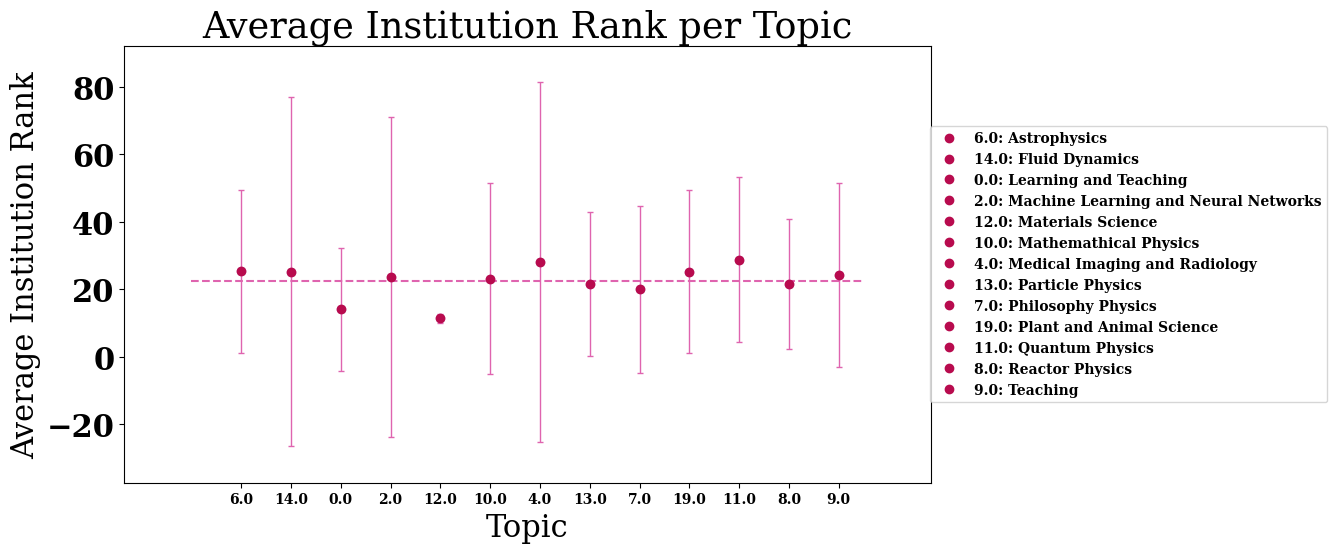

In [593]:
average_plot(avg_inst_rank_topics.institution_ranking, avg_inst_rank_topics_err.institution_ranking, title='Average Institution Rank per Topic',
            xlabel='Topic', ylabel='Average Institution Rank', rot=0,
            full_names=avg_inst_rank_topics.topic_label, short_names=avg_inst_rank_topics.topic_index, add_means=False, save_name='AverageInstRankTopic')



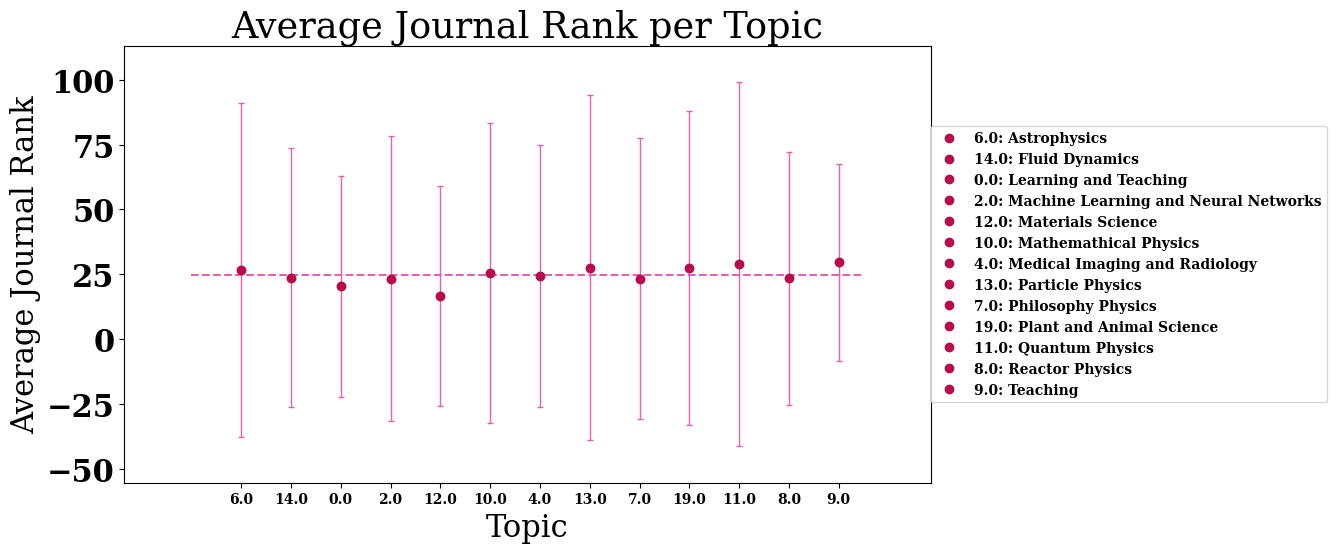

In [594]:
average_plot(avg_journal_rank_topics.journal_ranking, avg_journal_rank_topics_err.journal_ranking, title='Average Journal Rank per Topic',
            xlabel='Topic', ylabel='Average Journal Rank', rot=0,
            full_names=avg_journal_rank_topics.topic_label, short_names=avg_journal_rank_topics.topic_index, add_means=False, save_name='averageJournalRankTopic')



In [395]:
merged_avg_ranking_topic=pd.merge(avg_inst_rank_topics, avg_journal_rank_topics, on='topic_index')
merged_avg_ranking_topic.drop(columns={'topic_label_y'}, inplace=True)
merged_avg_ranking_topic.rename(columns={'topic_label_x':'topic_label'}, inplace=True)

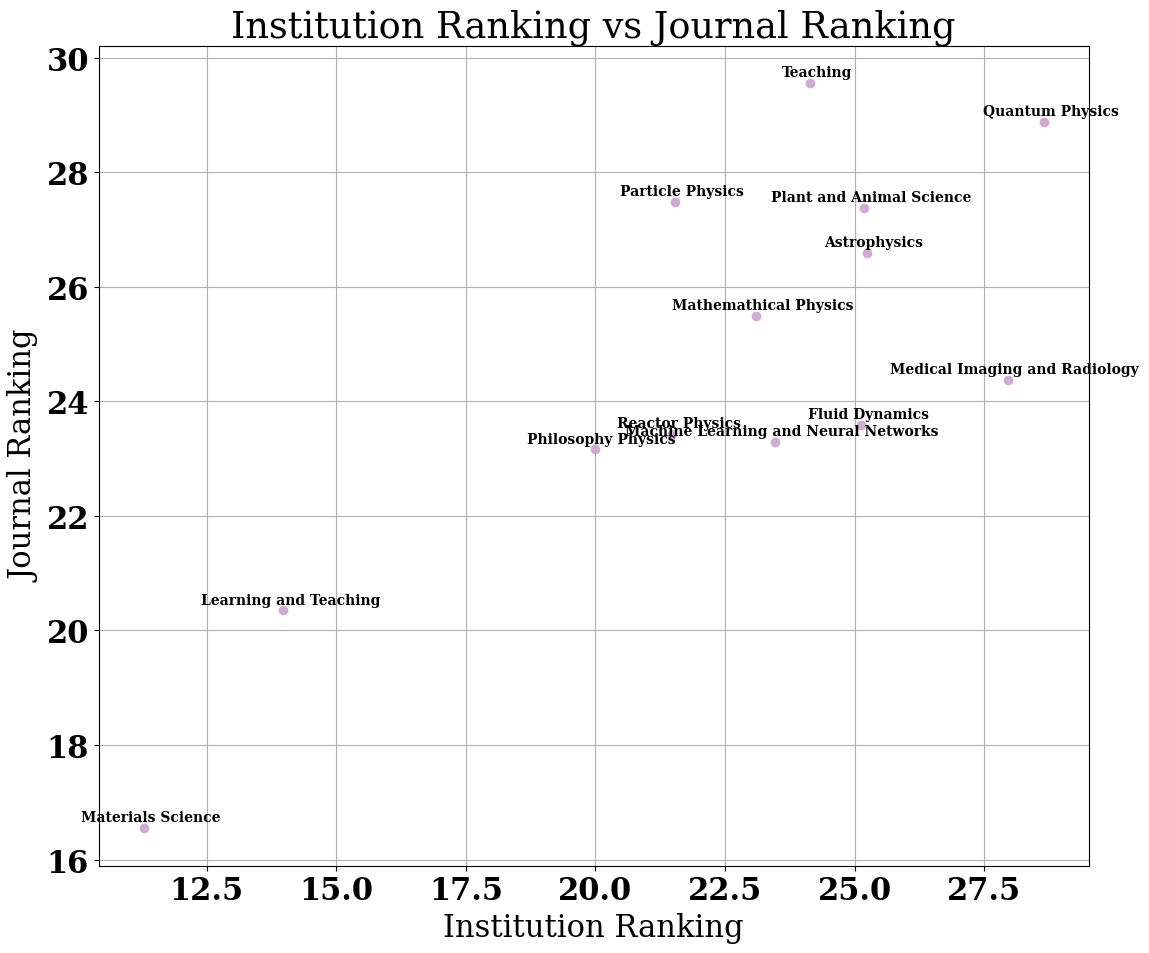

In [608]:
plot_ranking_scatter(merged_avg_ranking_topic.institution_ranking, merged_avg_ranking_topic.journal_ranking, 
                     merged_avg_ranking_topic.topic_label, xlabel='Institution Ranking', ylabel='Journal Ranking', 
                     title='Institution Ranking vs Journal Ranking', save_name='InstJournalRankTopic')

In [409]:
merged_avg_cites_inst_topic=pd.merge(avg_cites_topics, avg_inst_rank_topics, on='topic_index')
merged_avg_cites_inst_topic.drop(columns={'topic_label_y'}, inplace=True)
merged_avg_cites_inst_topic.rename(columns={'topic_label_x':'topic_label'}, inplace=True)

In [410]:
merged_avg_cites_journal_topic=pd.merge(avg_cites_topics, avg_journal_rank_topics, on='topic_index')
merged_avg_cites_journal_topic.drop(columns={'topic_label_y'}, inplace=True)
merged_avg_cites_journal_topic.rename(columns={'topic_label_x':'topic_label'}, inplace=True)

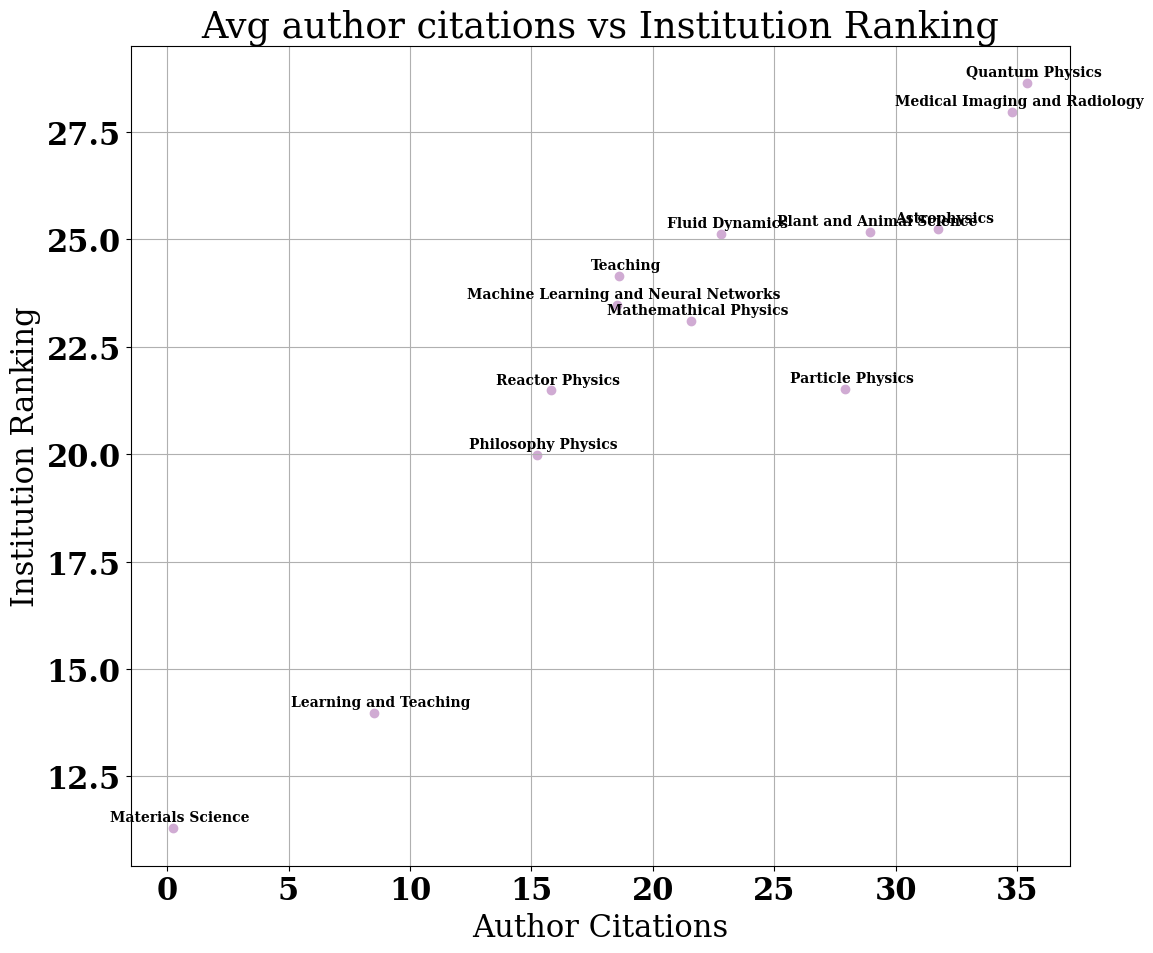

In [609]:
plot_ranking_scatter(merged_avg_cites_inst_topic.author_mean_cites, merged_avg_cites_inst_topic.institution_ranking, 
                     merged_avg_ranking_topic.topic_label, xlabel='Author Citations', ylabel='Institution Ranking', 
                     title='Avg author citations vs Institution Ranking', save_name='AuthorcitesInstTopics')



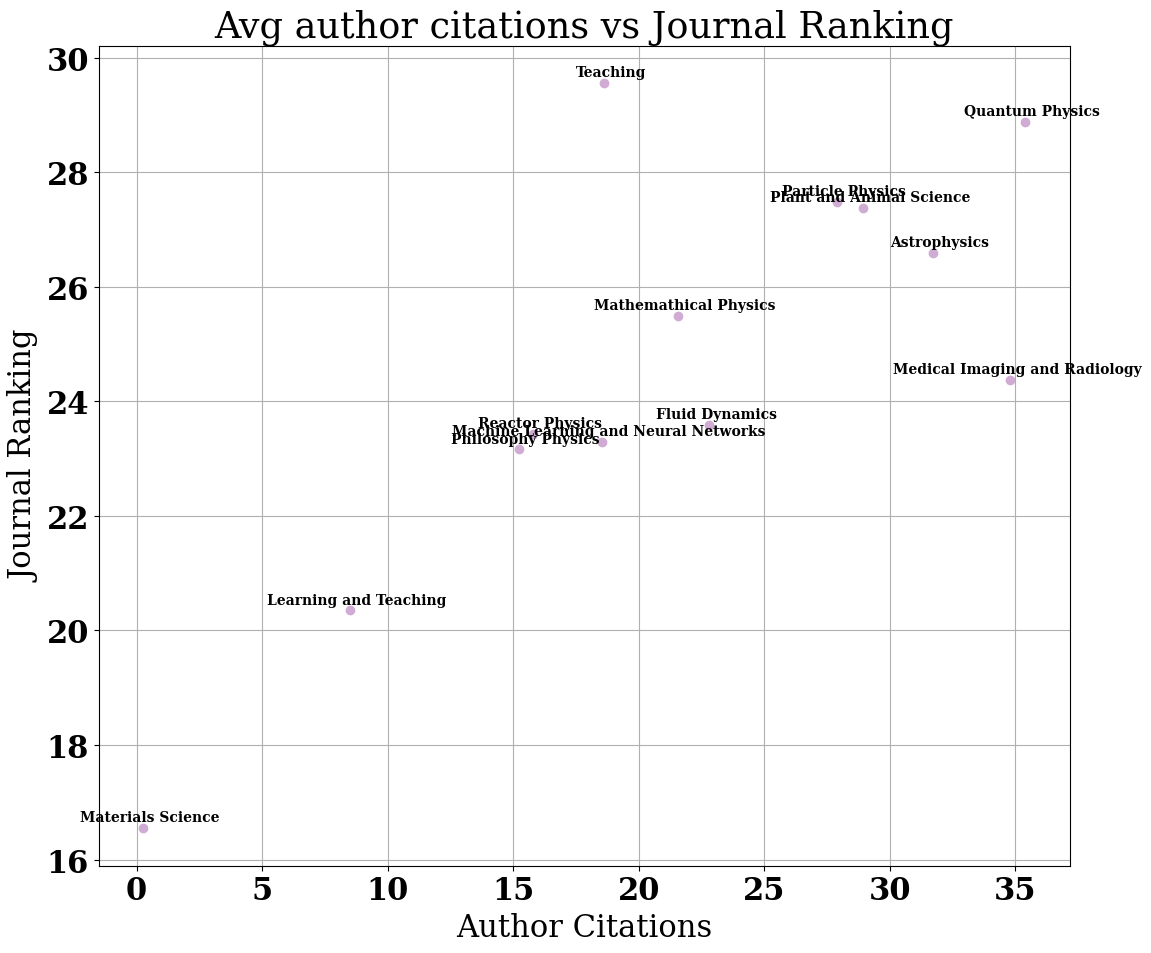

In [610]:
plot_ranking_scatter(merged_avg_cites_inst_topic.author_mean_cites, merged_avg_ranking_topic.journal_ranking, merged_avg_ranking_topic.topic_label,
                    xlabel='Author Citations', ylabel='Journal Ranking', title='Avg author citations vs Journal Ranking',
                    save_name='AutohorCitesJournalRankTopics')


# Activity Measure

Definer drop out: fx gennesmnit på over 1 over tre år periode: on /aktiv og indtil periode med 3 år med 0 publikationer så er man off  

but how do we deal with those having their first publication in 1970 - should we say that if their first publication is in 1975 then that's fair to assume that that would be their ACTUAL first publication - as the ones in 1970 we have no idea if they have been publishing in 1969 as well etc. and that if they do not have any publications AFTER 2020 then it is fair to assume that they have actually dropped out? 
however we should also exclude those whose first publication is in year 2023-3 years (if that is our activity threshold) as they have clearly just started their career and we do not know what their future career will look like 


In [69]:
#define variables relating to activity rate 
article_author_data_final['first_publication_year'] = article_author_data_final.groupby('author_id')['publication_year'].transform('min')
article_author_data_final['last_publication_year'] = article_author_data_final.groupby('author_id')['publication_year'].transform('max')
article_author_data_final['career_span_years'] = article_author_data_final['last_publication_year'] - article_author_data_final['first_publication_year']
article_author_data_final['author_publication_count'] = article_author_data_final.groupby('author_id')['author_id'].transform('count')
article_author_data_final['author_publication_rate'] = article_author_data_final['author_publication_count']/article_author_data_final['career_span_years']


In [70]:
#select only authors that we can assume has their whole career span within our time window 

In [71]:
#define an activity threshold in order to determine how many years an author should be inactive to be "dropped out"
activity_threshold = 5 #years 
active_startyear = 1970+activity_threshold
active_finalyear = 2023-activity_threshold

In [72]:
article_author_data_active = article_author_data_final[
    (article_author_data_final['first_publication_year'] >= active_startyear) & 
    (article_author_data_final['last_publication_year'] != article_author_data_final['first_publication_year']) &
    (article_author_data_final['last_publication_year'] <= active_finalyear)
]

In [73]:
len(article_author_data_active) # now these should be able to use for drop out analysis 

247287

In [74]:
#define drop out 
#if an author has had a period of inactivity for 5 years or longer 


In [75]:


#Determine if the last publication year is 2013 or earlier
event_observed = article_author_data_active['last_publication_year'] <= 2013 # this is set to 2018-5=2013 but we could try different settings 

# create the event_observed column based on the condition
article_author_data_active['event_observed'] = event_observed.astype(int)



/var/folders/23/_5nwl30d12q_2dv4hhpqjfl00000gn/T/ipykernel_3433/2555840108.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_author_data_active['event_observed'] = event_observed.astype(int)


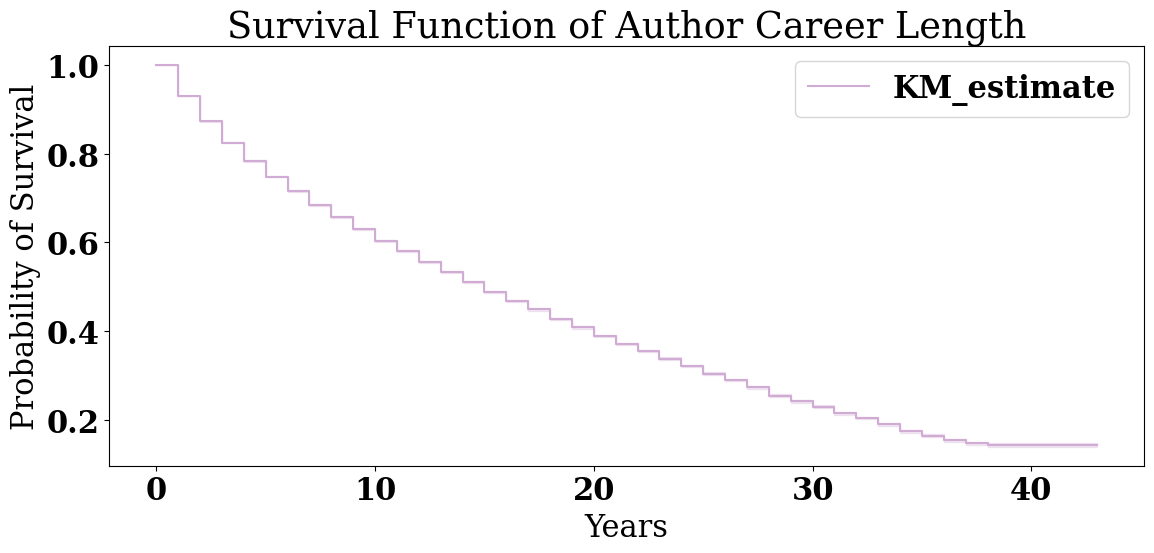

In [613]:
survival_plot(article_author_data_active['career_span_years'], article_author_data_active['event_observed'], title='Survival Function of Author Career Length', xlabel='Years', ylabel='Probability of Survival', save_name='survivalfuncAllAuthors')


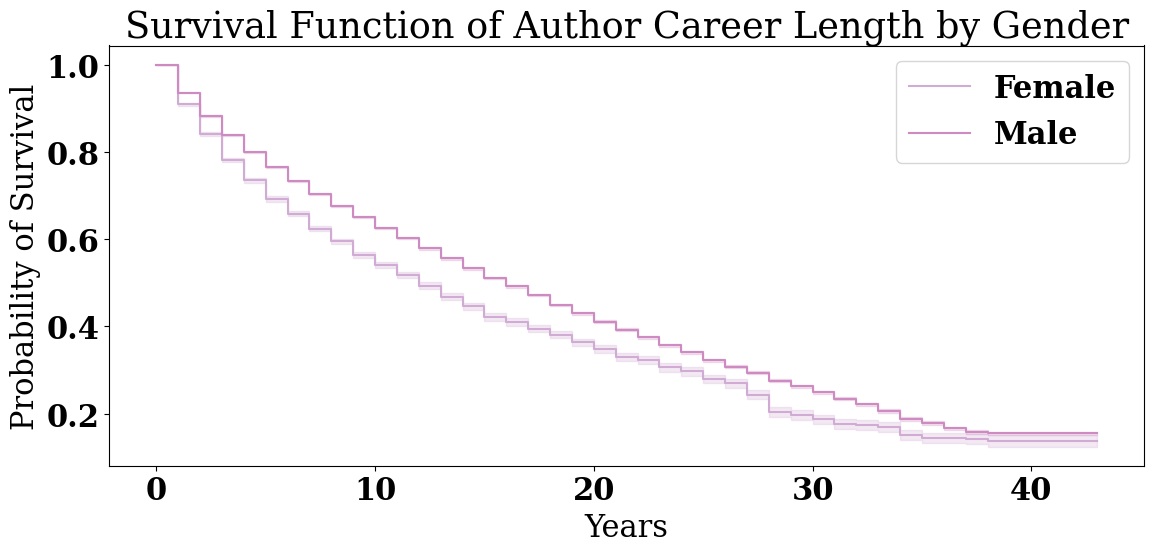

In [621]:
survival_compare_plot(article_author_data_active['career_span_years'][article_author_data_active.binary_gender == 'female'], 
                      article_author_data_active['event_observed'][article_author_data_active.binary_gender == 'female'], 
                      article_author_data_active['career_span_years'][article_author_data_active.binary_gender == 'male'],
                      article_author_data_active['event_observed'][article_author_data_active.binary_gender == 'male'],
                      label1='Female', label2='Male', title='Survival Function of Author Career Length by Gender',
                      xlabel='Years', ylabel='Probability of Survival', save_name='survivalGender')


In [622]:
from lifelines.statistics import logrank_test

# Separate the data for female and male authors
female_data = article_author_data_active[article_author_data_active['binary_gender'] == 'female']
male_data = article_author_data_active[article_author_data_active['binary_gender'] == 'male']

# Perform the log-rank test
results = logrank_test(female_data['career_span_years'], male_data['career_span_years'],
                       event_observed_A=female_data['event_observed'], event_observed_B=male_data['event_observed'])

# Print the p-value
print('Log-Rank Test p-value:', results.p_value)


Log-Rank Test p-value: 7.537744768507448e-141


### Survival func between topics 

In [128]:
#define variables relating to activity rate 
topics_data['first_publication_year'] = topics_data.groupby('author_id')['publication_year'].transform('min')
topics_data['last_publication_year'] = topics_data.groupby('author_id')['publication_year'].transform('max')
topics_data['career_span_years'] = topics_data['last_publication_year'] - topics_data['first_publication_year']
topics_data['author_publication_count'] = topics_data.groupby('author_id')['author_id'].transform('count')
topics_data['author_publication_rate'] = topics_data['author_publication_count']/topics_data['career_span_years']


In [129]:
#select only authors that we can assume has their whole career span within our time window 

In [130]:
#define an activity threshold in order to determine how many years an author should be inactive to be "dropped out"
activity_threshold = 5 #years 
active_startyear = 1970+activity_threshold
active_finalyear = 2023-activity_threshold

In [131]:
topics_data_active = topics_data[
    (topics_data['first_publication_year'] >= active_startyear) & 
    (topics_data['last_publication_year'] != topics_data['first_publication_year']) &
    (topics_data['last_publication_year'] <= active_finalyear)
]

In [132]:
len(topics_data_active) # now these should be able to use for drop out analysis 

236760

In [133]:
#define drop out 
#if an author has had a period of inactivity for 5 years or longer 


In [134]:


#Determine if the last publication year is 2013 or earlier
event_observed = topics_data_active['last_publication_year'] <= 2013 # this is set to 2018-5=2013 but we could try different settings 

# create the event_observed column based on the condition
topics_data_active['event_observed'] = event_observed.astype(int)


/var/folders/23/_5nwl30d12q_2dv4hhpqjfl00000gn/T/ipykernel_6557/3079331232.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



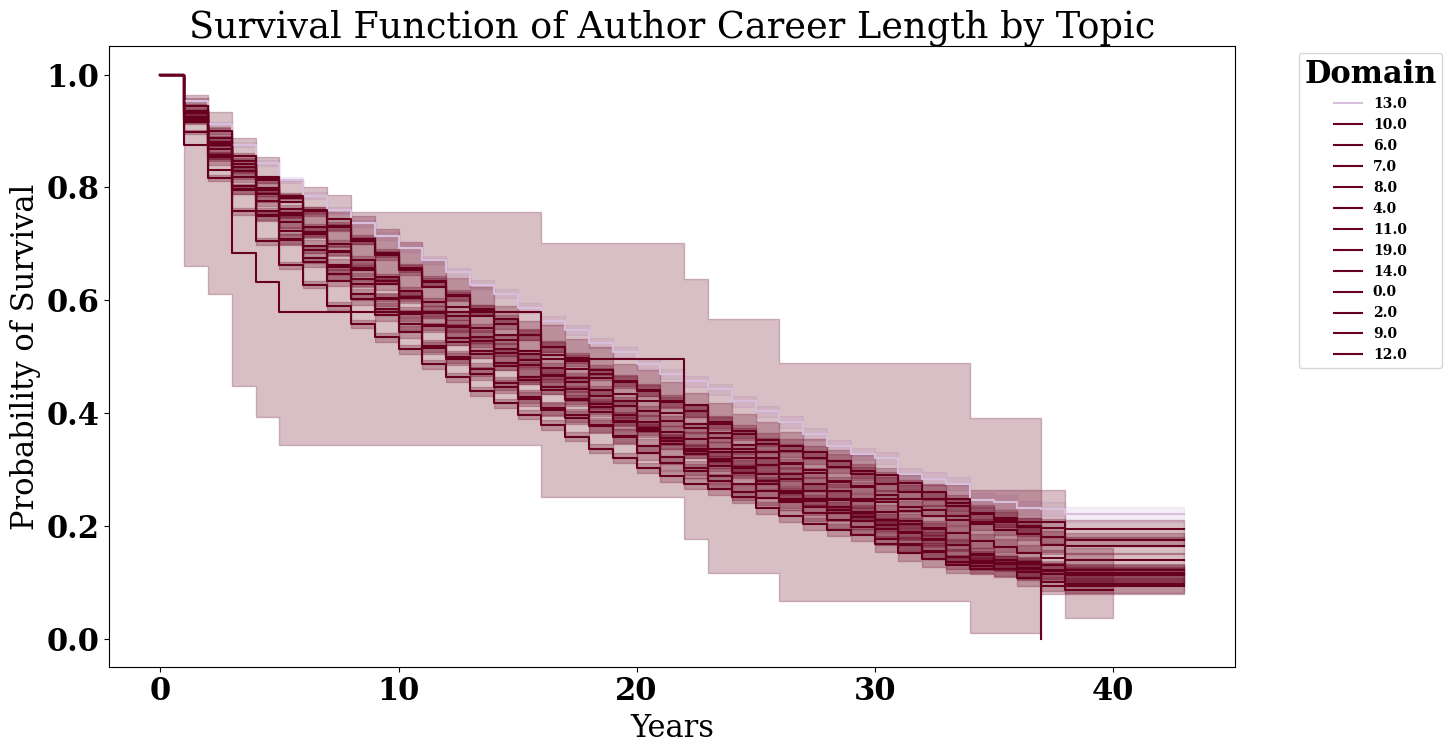

In [636]:
plot_survival_by_group(topics_data_active, topics_data_active.topic_index, title='Survival Function of Author Career Length by Topic', xlabel='Years', ylabel='Probability of Survival', legend_title='Domain', save_name='SurvivalByTopic')

#burde vi her måske vælge kun dem der publicerer indenfor ét topic - lige nu er det jo rodet sammen 

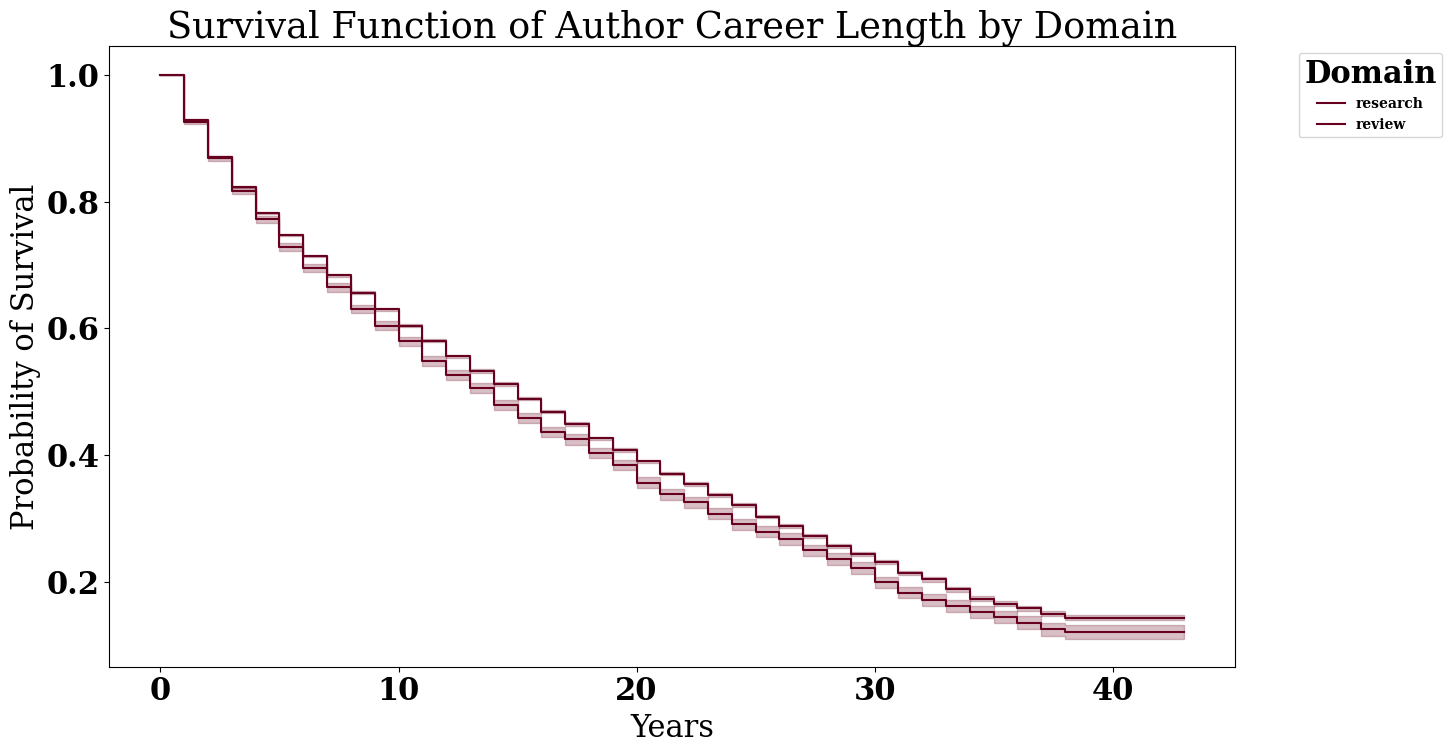

In [634]:
plot_survival_by_group(topics_data_active, topics_data_active.domain, title='Survival Function of Author Career Length by Domain', xlabel='Years', ylabel='Probability of Survival', legend_title='Domain', save_name='SurvivalByDomain')


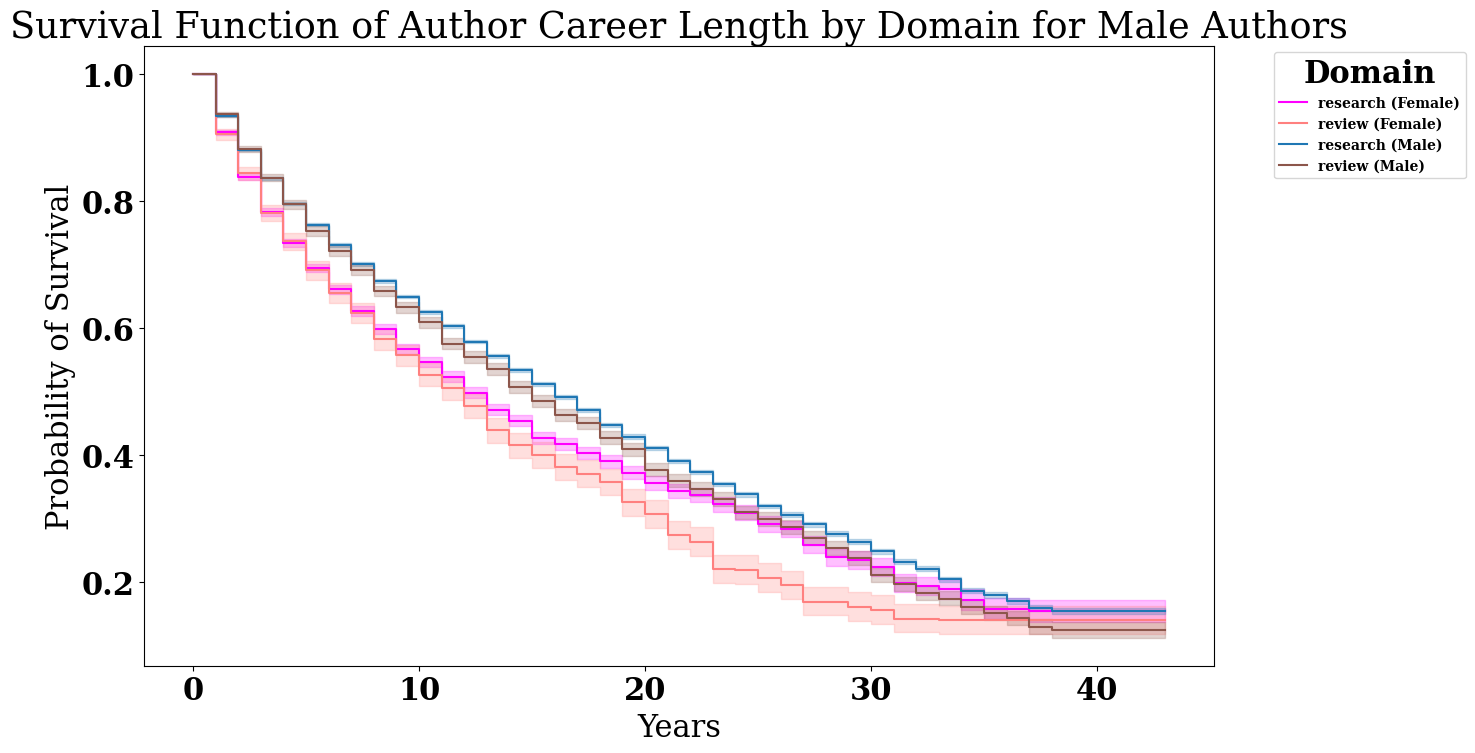

In [649]:
# Create a single figure
plt.figure(figsize=(15, 8))

# Define colormaps for female and male authors
cmap_female = 'spring'
cmap_male = 'tab20'

# Plot survival function by domain for female authors
plot_survival_by_domain_compare(topics_data_active[topics_data_active['binary_gender'] == 'female'], 'female', cmap_female, save_name='SurvivalGenderDomain')

# Plot survival function by domain for male authors
plot_survival_by_domain_compare(topics_data_active[topics_data_active['binary_gender'] == 'male'], 'male', cmap_male, save_name='SurvivalGenderDomain')

# Add legend
plt.legend(title='Domain', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


# Collaborations 

In [157]:
#investegate collaborations between genders between topics/domains 

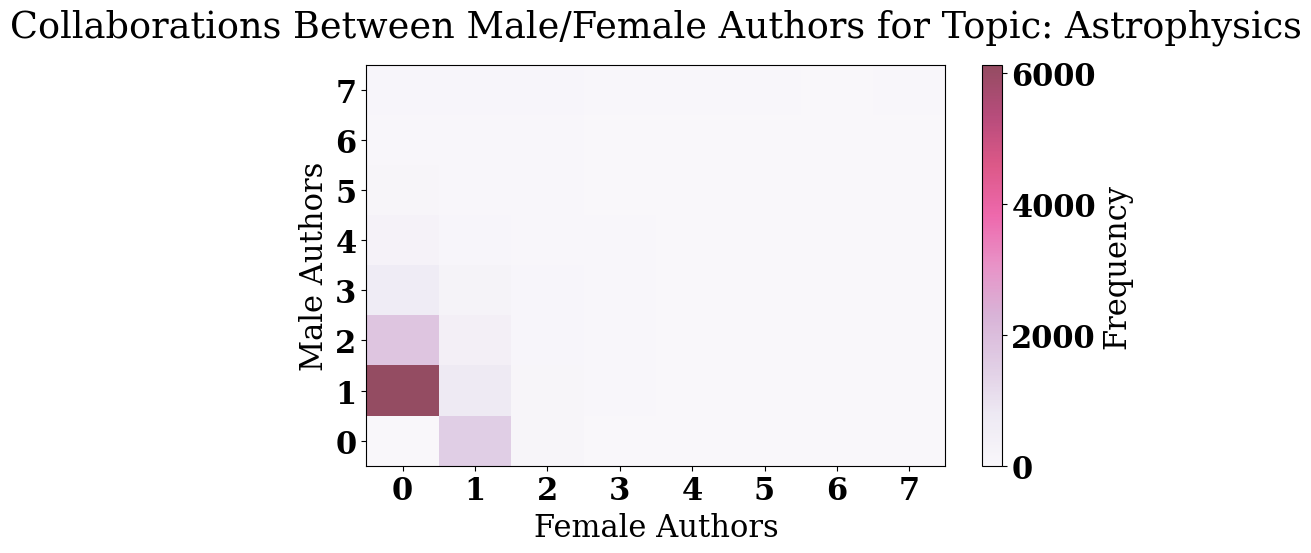

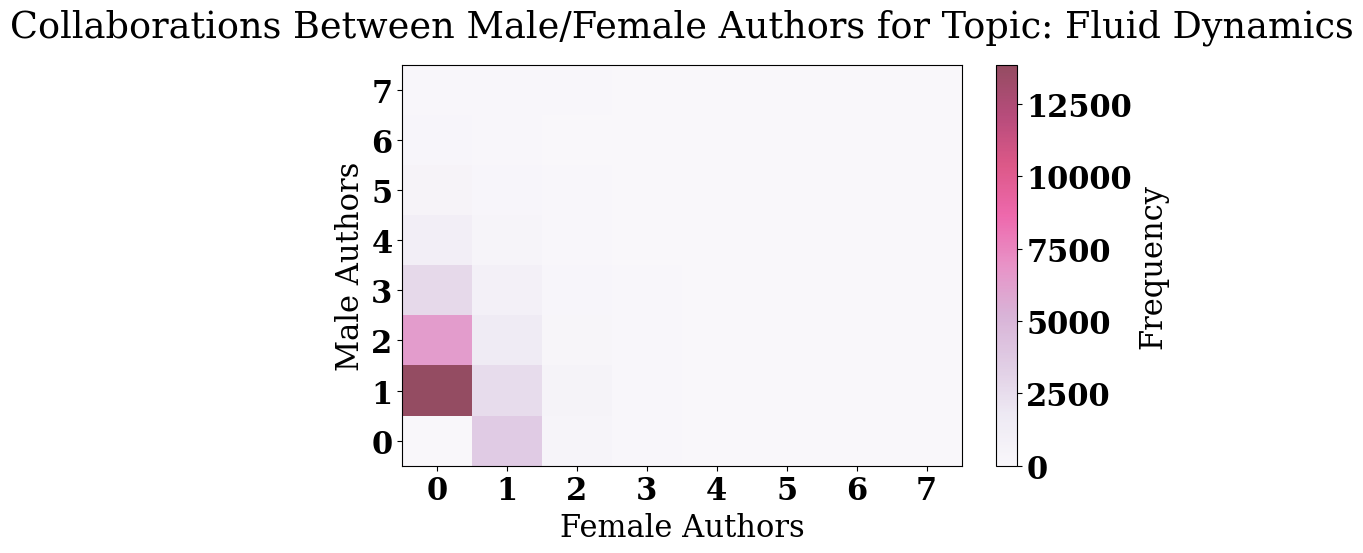

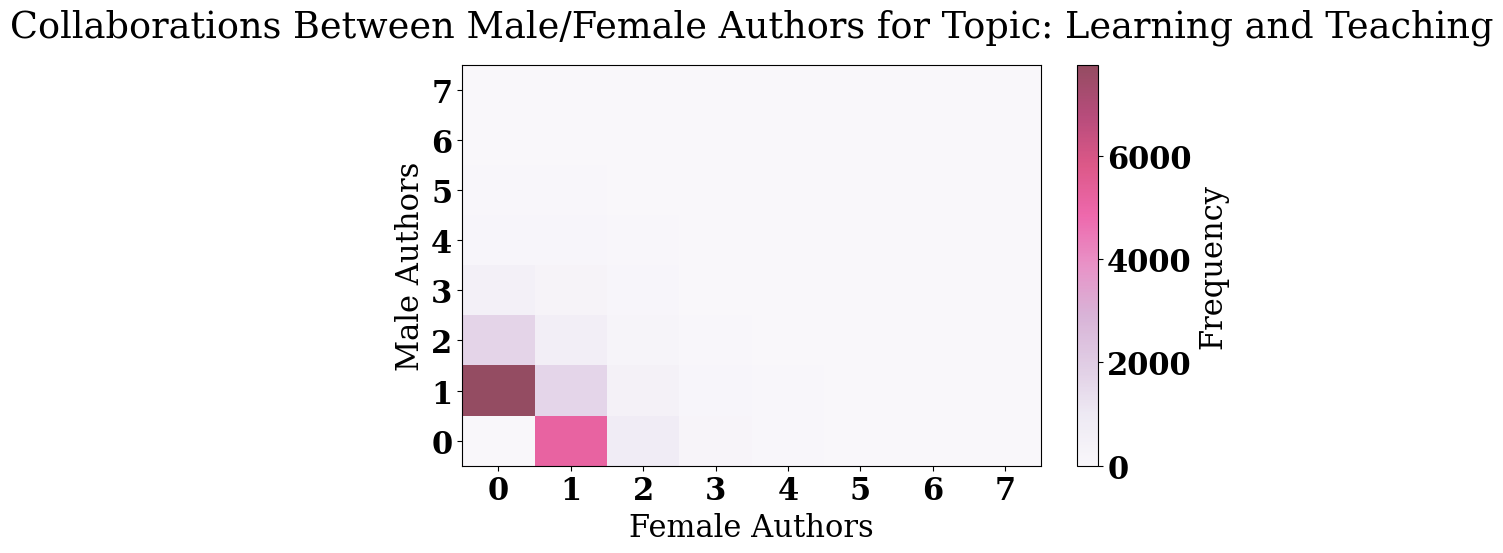

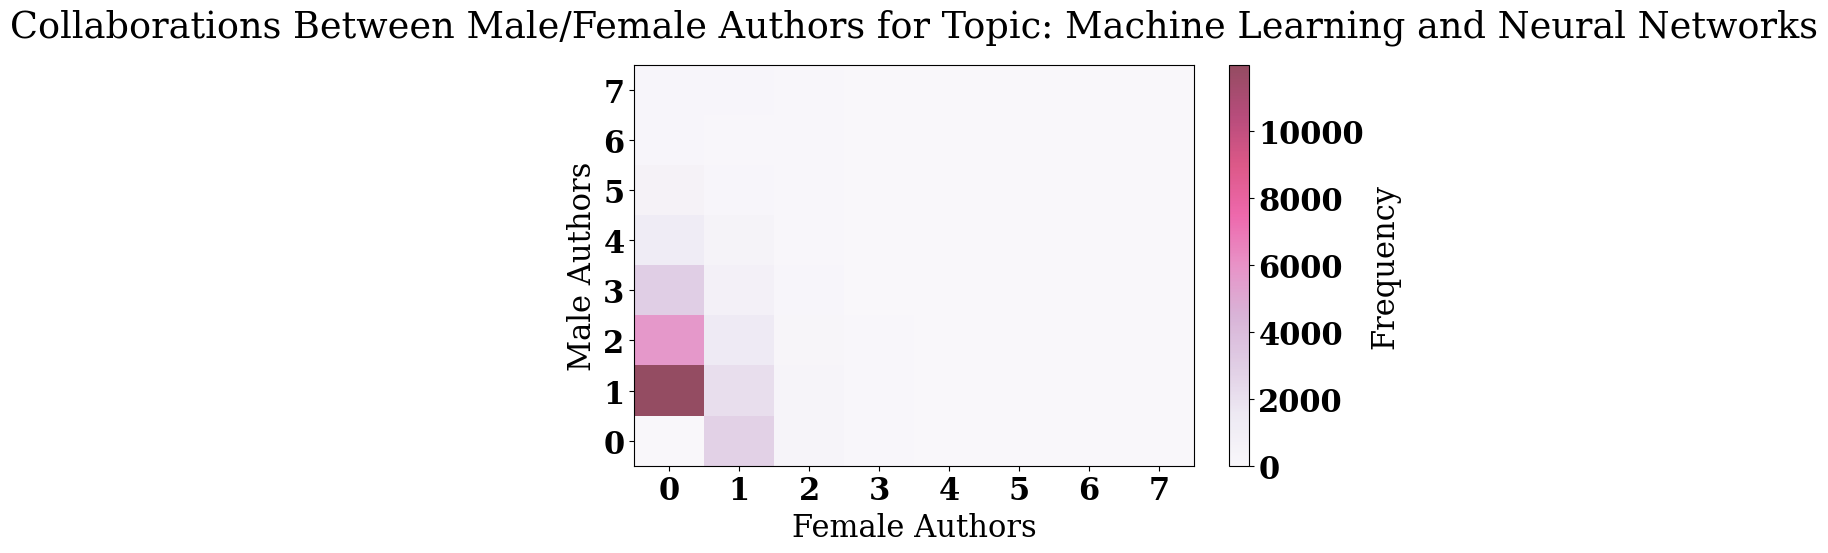

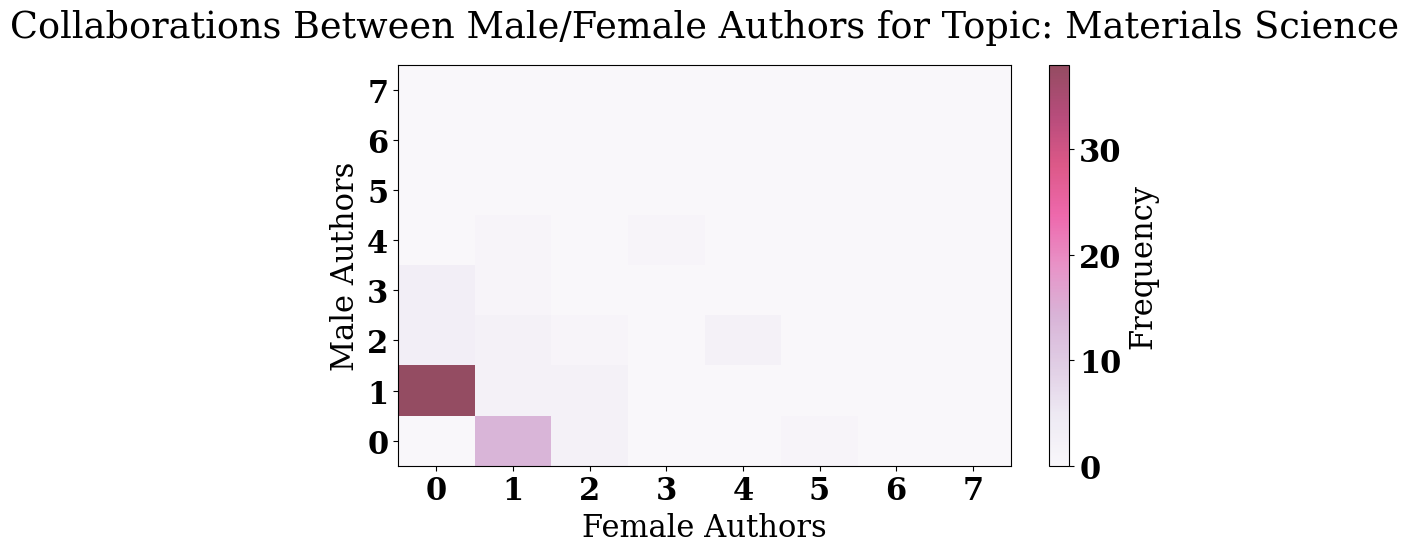

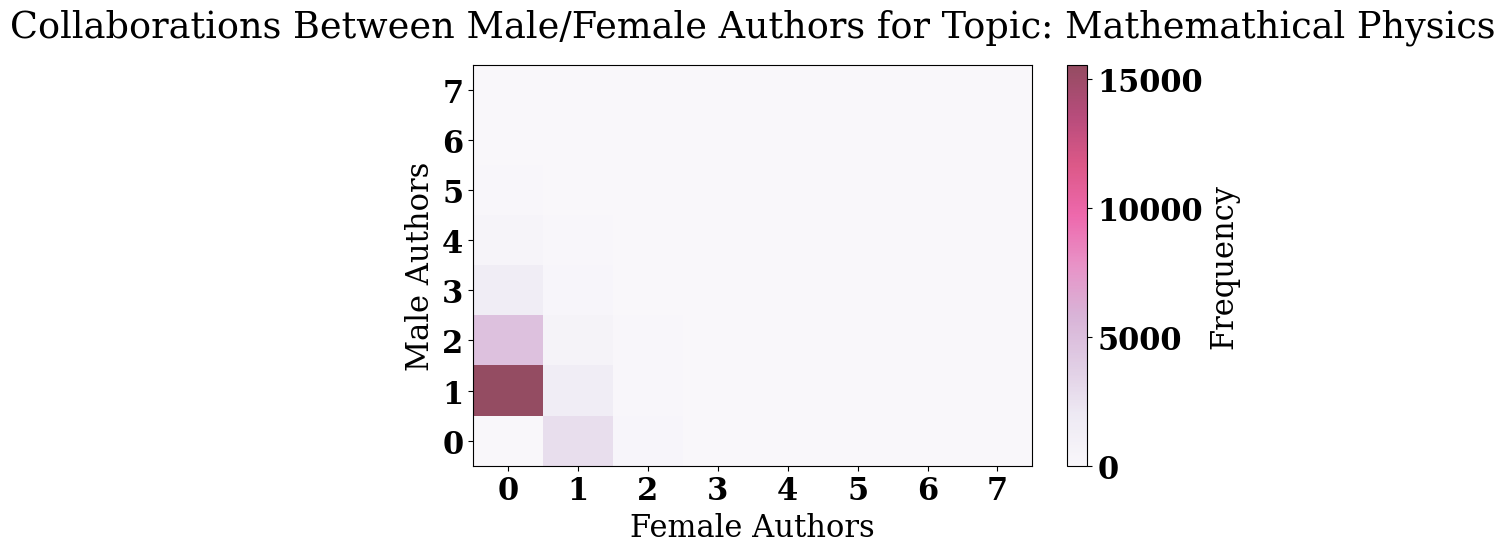

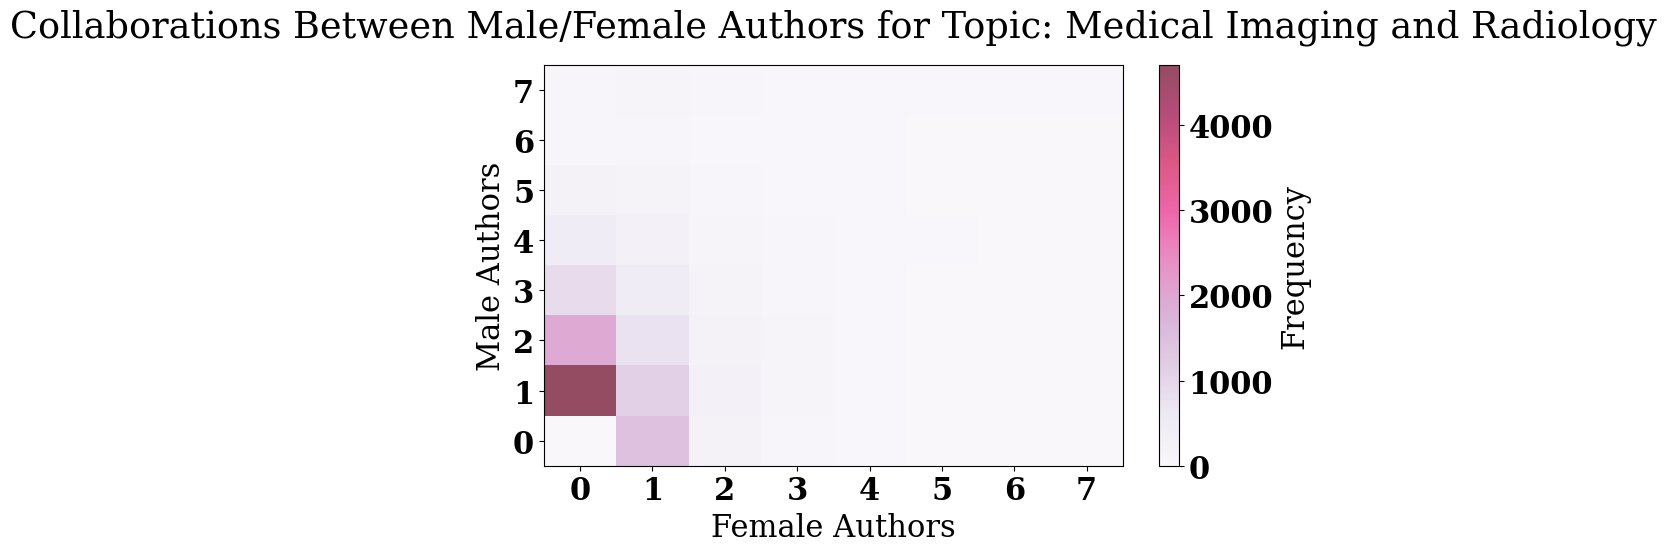

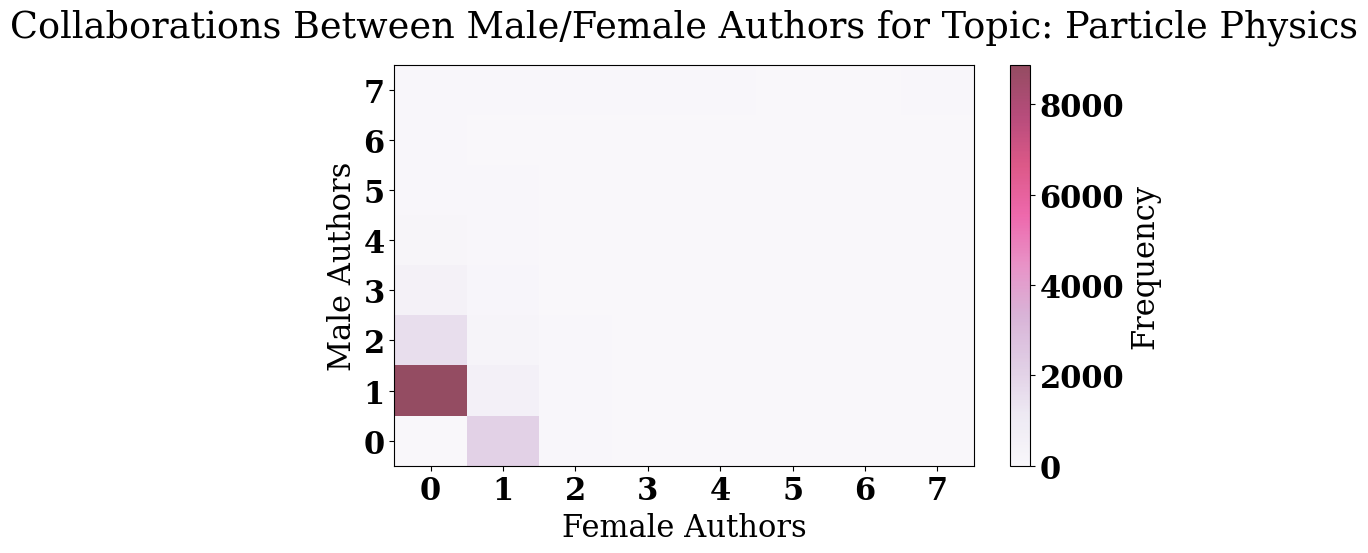

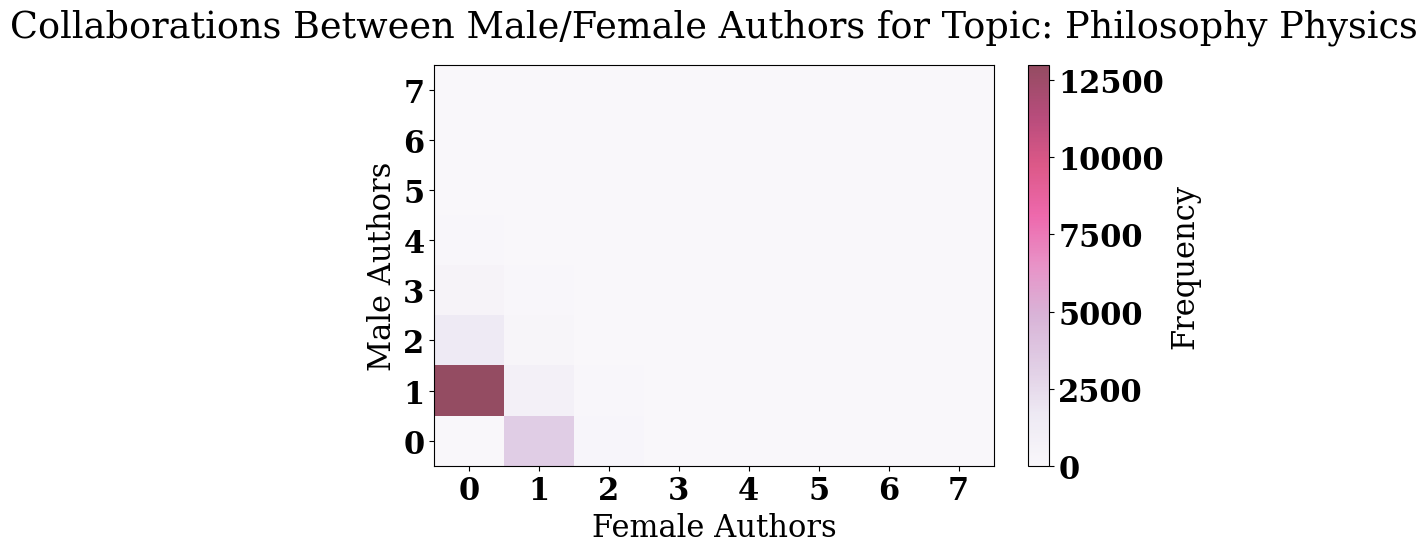

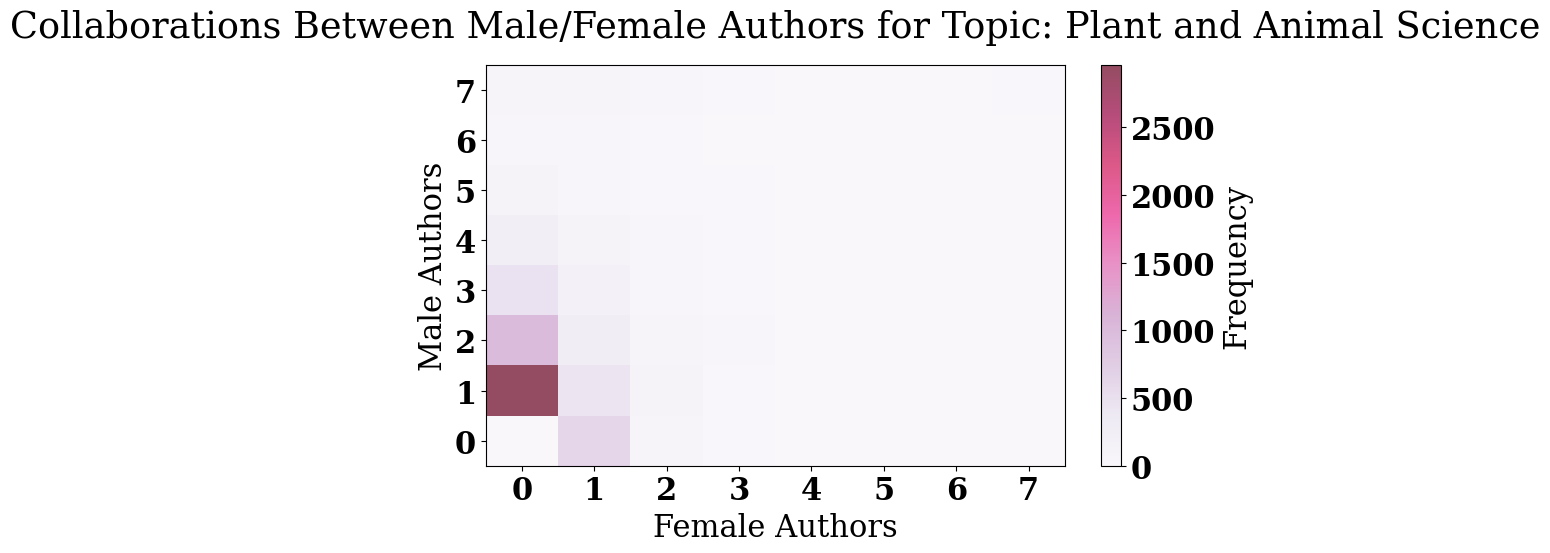

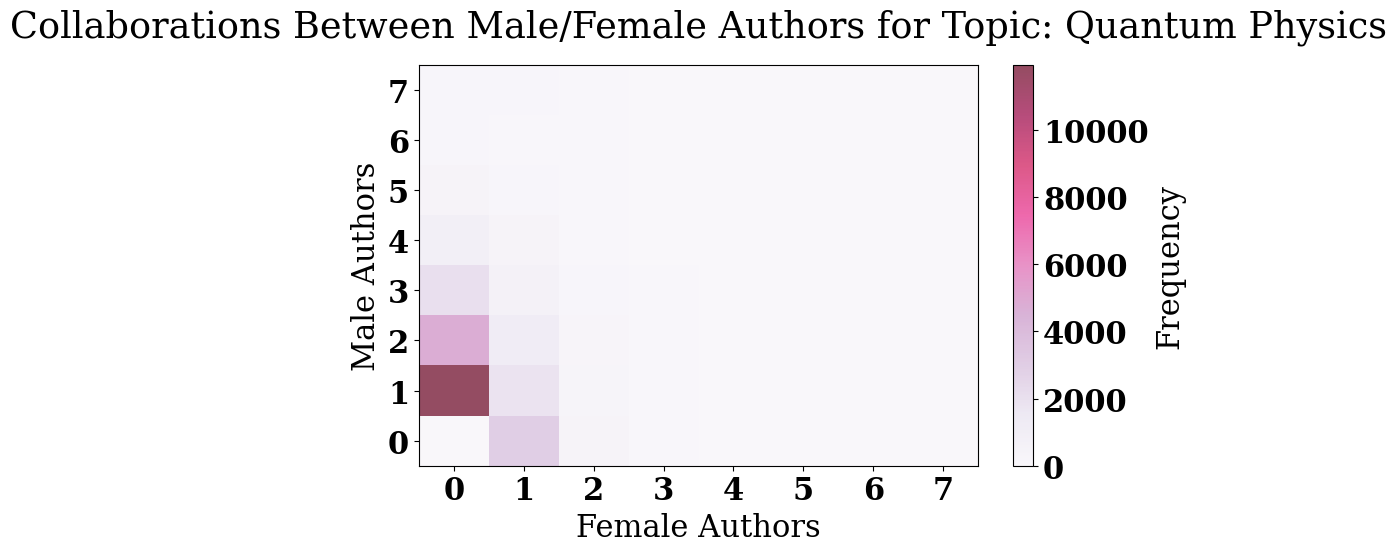

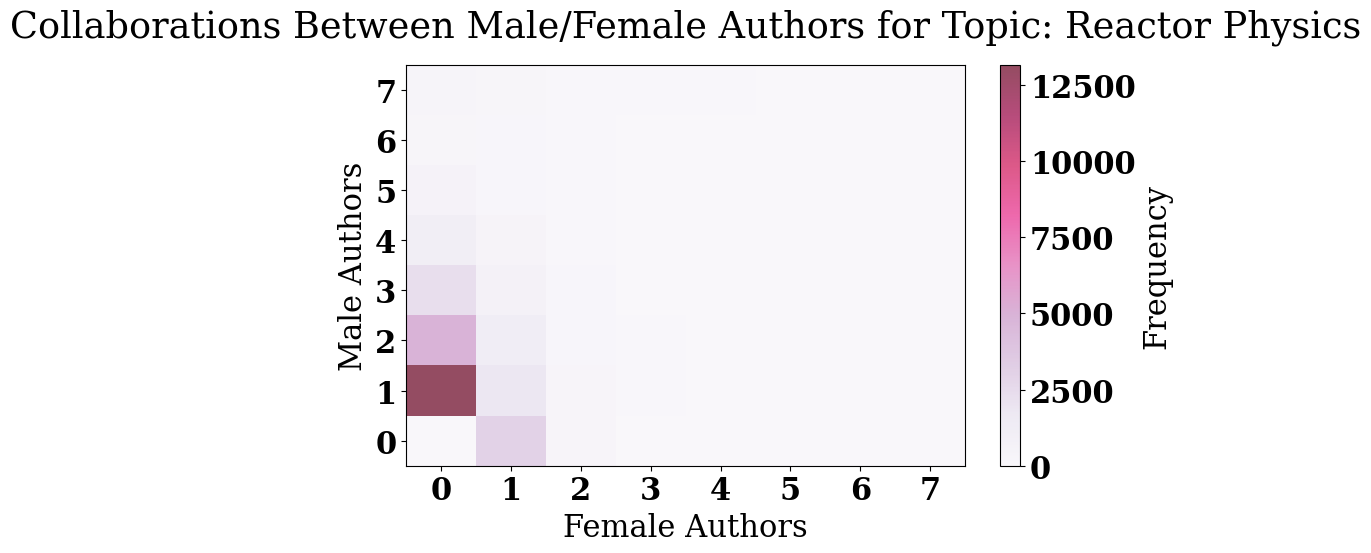

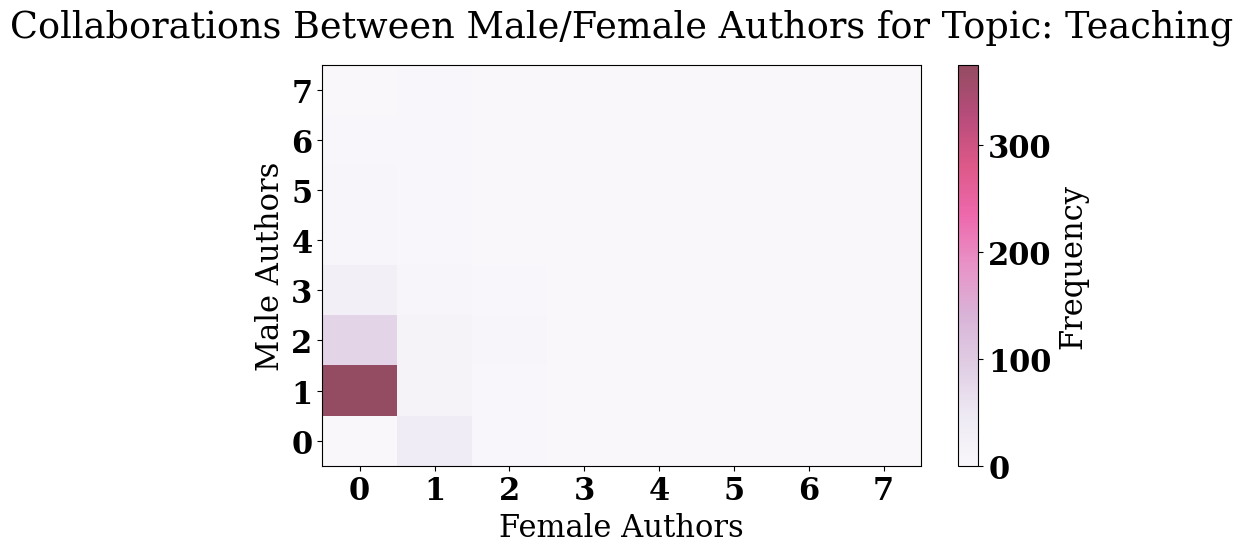

In [654]:
hist2D_author_gender_counts_by_topic(topics_data, save_name='TopicsCollaborationsGender')

# Flow between topics 

Is there a tendency to go from research to teaching/review and is the tendency different between genders - når en forfatter er aktiv hvor stor er andelen så af de publikationer der er I teaching/research. Andel per forfatter over tid- udvælg forfattere der er aktive.

In [135]:
#let's first just check how many authors that publish within different topics and how many of each gender 
topics_per_author=topics_data.groupby('author_id')['topic_label'].nunique().reset_index()
#then let's check the same thing but within each domain 
domains_per_author=topics_data.groupby('author_id')['domain'].nunique().reset_index()

In [136]:
topics_per_author[topics_per_author.topic_label>1]

author_id  topic_label
9       https://openalex.org/A5000001854           10
12      https://openalex.org/A5000002458            2
15      https://openalex.org/A5000002873            2
16      https://openalex.org/A5000002960            3
18      https://openalex.org/A5000003309            4
...                                  ...          ...
619138  https://openalex.org/A5092857551            2
619139  https://openalex.org/A5092857552            2
619141  https://openalex.org/A5092857554            2
619195  https://openalex.org/A5093039163            3
619210  https://openalex.org/A9999999999           13

[201440 rows x 2 columns]

In [137]:
both_domains_authors=domains_per_author[domains_per_author.domain>1]

In [664]:
both_domains_authors_list=both_domains_authors.author_id.to_list()

In [669]:
both_domains_data=topics_data[topics_data.author_id.isin(both_domains_authors_list)]

In [672]:
both_domains_data.binary_gender.value_counts()

binary_gender
male      74441
female    13988
Name: count, dtype: int64

In [676]:
topics_data.binary_gender.value_counts()

binary_gender
male      773622
female    180213
Name: count, dtype: int64

In [684]:
single_domain_authors=domains_per_author[domains_per_author.domain==1]
single_domain_authors_list=single_domain_authors.author_id.to_list()

In [685]:
single_domain_authors_data=topics_data[topics_data.author_id.isin(single_domain_authors_list)]

In [686]:
#then let's check how many are only in research vs only in review  
only_research_data=single_domain_authors_data[single_domain_authors_data.domain=='research']

only_review_data=single_domain_authors_data[single_domain_authors_data.domain=='review']

In [687]:
#check gender dist of authors in both domains 
only_research_data.binary_gender.value_counts()

binary_gender
male      654401
female    140915
Name: count, dtype: int64

In [689]:
654401/773622*100

84.58924384260014

In [690]:
140915/180213*100

78.1935820390316

In [688]:
only_review_data.binary_gender.value_counts() 

binary_gender
male      44780
female    25310
Name: count, dtype: int64

In [691]:
44780/773622*100

5.788356587584118

In [692]:
25310/180213*100

14.044491795819392

In [ ]:
#then let's see what the nature of the switching between topics/domains is 

In [299]:
#this is the data we should use to include drop out 
topics_data_active.head(1)

article_id  \
5908  https://openalex.org/W2080980089   

                                               doi  publication_year  \
5908  https://doi.org/10.1016/0370-1573(75)90009-5              1975   

     publication_date                                            title_x  \
5908       1975-01-01  The two-photon particle production mechanism. ...   

      cited_by_count grants  \
5908             915     []   

                                             abstract_x  \
5908  This review deals with the physics of two-phot...   

                            journal_id              journal_name_x  ...  \
5908  https://openalex.org/S4210240599  The philosophical magazine  ...   

      last_publication_year career_span_years author_publication_count  \
5908                   2006                31                        8   

      author_publication_rate event_observed topic_count topic_switcher  \
5908                 0.258065              1           6           True   

     domain_count domain_switcher domain_binary  
5908            2            True             1  

[1 rows x 52 columns]

In [300]:
# Group by author_id and count the unique topic_label
topics_data_active['topic_count'] = topics_data_active.groupby('author_id')['topic_label'].transform('nunique')

# Create the topic_switcher column based on the count
topics_data_active['topic_switcher'] = topics_data_active['topic_count'] > 1


/var/folders/23/_5nwl30d12q_2dv4hhpqjfl00000gn/T/ipykernel_6557/407280177.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/23/_5nwl30d12q_2dv4hhpqjfl00000gn/T/ipykernel_6557/407280177.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [301]:
#same thing but for domain
topics_data_active['domain_count'] = topics_data_active.groupby('author_id')['domain'].transform('nunique')
topics_data_active['domain_switcher'] = topics_data_active['domain_count'] > 1


/var/folders/23/_5nwl30d12q_2dv4hhpqjfl00000gn/T/ipykernel_6557/403280676.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/23/_5nwl30d12q_2dv4hhpqjfl00000gn/T/ipykernel_6557/403280676.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [302]:
#let's create a binary domain column where research=1 and review = 2 
topics_data_active['domain_binary'] = topics_data_active['domain'].replace({'research': 1, 'review': 2})


/var/folders/23/_5nwl30d12q_2dv4hhpqjfl00000gn/T/ipykernel_6557/2040317988.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [303]:
#let's create a third value 3 that correpsonds to drop out the year after their last publication year 

# Find rows where publication_year matches last_publication_year and event_observed is 1
matching_rows = topics_data_active[(topics_data_active['publication_year'] == topics_data_active['last_publication_year']) & (topics_data_active['event_observed'] == 1)].copy()

# Increment publication_year by 1 and set domain_binary to 3 for the copied rows
matching_rows['publication_year'] += 1
matching_rows['domain_binary'] = 3

# Concatenate the original DataFrame with the copied rows
result_topics_data_active = pd.concat([topics_data_active, matching_rows], ignore_index=True)


In [304]:
#now let's define what their past/current topic is for each year - we start by domain since that is simpler 
# Pivot the data to get a table where each row represents an article_id and each column represents a publication year,
# with the values being the corresponding domain of the author_id
topics_data_active_pivot = pd.pivot_table(result_topics_data_active, index='author_id', columns='publication_year', values='domain_binary', aggfunc='mean')

# Add a prefix 'domain_' to the column names
topics_data_active_pivot.columns = [f'domain_{year}' for year in topics_data_active_pivot.columns]



In [305]:
#let's maybe start by making a simple Sankey diagram - let's start by just taking in between the first years so 1970-1971 as current/past
#and then let's just look at their first domaine and lastd domaine for each author

In [306]:
# map 1 and 2 and other numbers back to research and review strings and anything in between should be both 
topics_data_active_pivot.replace({1: 'research', 2: 'review', 3: 'drop out', 1.1785714285714286:'both', 1.0555555555555556:'both', 1.3125:'both',1.1627906976744187:'both', 1.2333333333333334:'both', 1.1333333333333333:'both', 1.5294117647058822:'both', 1.9333333333333333:'both', 1.6818181818181819:'both', 1.6111111111111112:'both', 1.08:'both', 1.7:'both', 1.1538461538461537:'both', 1.4615384615384615:'both', 1.0952380952380953:'both', 1.9411764705882353:'both', 1.0793650793650793:'both',1.0793650793650793:'both', 1.7777777777777777:'both',1.3571428571428572:'both',1.0769230769230769:'both', 1.0434782608695652:'both', 1.3103448275862069:'both', 1.3076923076923077:'both', 1.5555555555555556:'both', 1.9:'both', 1.8333333333333333:'both', 1.9230769230769231:'both', 1.0714285714285714:'both', 1.3:'both', 1.1:'both',1.9285714285714286:'both', 1.8461538461538463:'both', 1.6428571428571428:'both', 1.3636363636363635:'both', 1.9166666666666667:'both', 1.1111111111111112:'both',1.5714285714285714:'both', 1.4166666666666667: 'both', 1.9375:'both', 1.8529411764705883:'both', 1.625:'both', 1.875: 'both', 1.864864864864865:'both', 1.9666666666666666: 'both', 1.3888888888888888: 'both', 1.8888888888888888: 'both', 1.9387755102040816: 'both', 1.92: 'both', 1.0666666666666667: 'both', 1.2727272727272727: 'both', 1.1875: 'both', 1.0833333333333333: 'both', 1.1176470588235294: 'both', 1.4285714285714286: 'both', 1.7142857142857142: 'both', 1.9090909090909092: 'both', 1.8571428571428572: 'both', 1.4444444444444444: 'both', 1.1818181818181819: 'both', 1.0909090909090908: 'both', 1.8: 'both', 1.6: 'both', 1.375: 'both', 1.4: 'both', 1.25: 'both', 1.75: 'both', 1.2857142857142858: 'both', 1.2: 'both', 1.125: 'both', 1.5: 'both', 1.6666666666666667: 'both', 1.1666666666666667: 'both', 1.2222222222222223: 'both', 1.3333333333333333: 'both', 1.1428571428571428: 'both'}, inplace=True)


#let's do this correctly once we got the correct data!!! 

In [307]:
topics_data_active_pivot

domain_1975 domain_1976 domain_1977  \
author_id                                                              
https://openalex.org/A5000003750         NaN         NaN         NaN   
https://openalex.org/A5000005323         NaN         NaN         NaN   
https://openalex.org/A5000005456         NaN         NaN         NaN   
https://openalex.org/A5000006628         NaN         NaN         NaN   
https://openalex.org/A5000010033         NaN         NaN         NaN   
...                                      ...         ...         ...   
https://openalex.org/A5091907741         NaN         NaN         NaN   
https://openalex.org/A5091907856         NaN         NaN         NaN   
https://openalex.org/A5091912090         NaN         NaN         NaN   
https://openalex.org/A5091912575         NaN         NaN         NaN   
https://openalex.org/A5091912782         NaN         NaN         NaN   

                                 domain_1978 domain_1979 domain_1980  \
author_id                                                              
https://openalex.org/A5000003750         NaN         NaN         NaN   
https://openalex.org/A5000005323         NaN         NaN         NaN   
https://openalex.org/A5000005456         NaN         NaN    research   
https://openalex.org/A5000006628         NaN         NaN         NaN   
https://openalex.org/A5000010033         NaN         NaN         NaN   
...                                      ...         ...         ...   
https://openalex.org/A5091907741         NaN         NaN         NaN   
https://openalex.org/A5091907856         NaN         NaN         NaN   
https://openalex.org/A5091912090         NaN         NaN         NaN   
https://openalex.org/A5091912575         NaN         NaN         NaN   
https://openalex.org/A5091912782         NaN         NaN         NaN   

                                 domain_1981 domain_1982 domain_1983  \
author_id                                                              
https://openalex.org/A5000003750         NaN         NaN         NaN   
https://openalex.org/A5000005323         NaN         NaN         NaN   
https://openalex.org/A5000005456         NaN         NaN         NaN   
https://openalex.org/A5000006628         NaN         NaN         NaN   
https://openalex.org/A5000010033         NaN         NaN         NaN   
...                                      ...         ...         ...   
https://openalex.org/A5091907741         NaN         NaN         NaN   
https://openalex.org/A5091907856         NaN         NaN         NaN   
https://openalex.org/A5091912090         NaN         NaN         NaN   
https://openalex.org/A5091912575         NaN         NaN         NaN   
https://openalex.org/A5091912782         NaN         NaN         NaN   

                                 domain_1984  ... domain_2009 domain_2010  \
author_id                                     ...                           
https://openalex.org/A5000003750         NaN  ...         NaN         NaN   
https://openalex.org/A5000005323         NaN  ...    research         NaN   
https://openalex.org/A5000005456         NaN  ...         NaN         NaN   
https://openalex.org/A5000006628         NaN  ...         NaN         NaN   
https://openalex.org/A5000010033         NaN  ...      review         NaN   
...                                      ...  ...         ...         ...   
https://openalex.org/A5091907741         NaN  ...         NaN         NaN   
https://openalex.org/A5091907856         NaN  ...         NaN         NaN   
https://openalex.org/A5091912090         NaN  ...    research    research   
https://openalex.org/A5091912575         NaN  ...    research         NaN   
https://openalex.org/A5091912782         NaN  ...         NaN         NaN   

                                 domain_2011 domain_2012 domain_2013  \
author_id                                                              
https://openalex.org/A5000003750         NaN         NaN         NaN   
http

In [308]:
topics_data_active_pivot.domain_2018.value_counts()

domain_2018
research    7471
review      1344
both         369
Name: count, dtype: int64

In [309]:
#find a way to assign dropout year 

In [310]:
topics_data_active_pivot_filled=topics_data_active_pivot.ffill(axis=1)

In [311]:
topics_data_active_pivot_filled

domain_1975 domain_1976 domain_1977  \
author_id                                                              
https://openalex.org/A5000003750         NaN         NaN         NaN   
https://openalex.org/A5000005323         NaN         NaN         NaN   
https://openalex.org/A5000005456         NaN         NaN         NaN   
https://openalex.org/A5000006628         NaN         NaN         NaN   
https://openalex.org/A5000010033         NaN         NaN         NaN   
...                                      ...         ...         ...   
https://openalex.org/A5091907741         NaN         NaN         NaN   
https://openalex.org/A5091907856         NaN         NaN         NaN   
https://openalex.org/A5091912090         NaN         NaN         NaN   
https://openalex.org/A5091912575         NaN         NaN         NaN   
https://openalex.org/A5091912782         NaN         NaN         NaN   

                                 domain_1978 domain_1979 domain_1980  \
author_id                                                              
https://openalex.org/A5000003750         NaN         NaN         NaN   
https://openalex.org/A5000005323         NaN         NaN         NaN   
https://openalex.org/A5000005456         NaN         NaN    research   
https://openalex.org/A5000006628         NaN         NaN         NaN   
https://openalex.org/A5000010033         NaN         NaN         NaN   
...                                      ...         ...         ...   
https://openalex.org/A5091907741         NaN         NaN         NaN   
https://openalex.org/A5091907856         NaN         NaN         NaN   
https://openalex.org/A5091912090         NaN         NaN         NaN   
https://openalex.org/A5091912575         NaN         NaN         NaN   
https://openalex.org/A5091912782         NaN         NaN         NaN   

                                 domain_1981 domain_1982 domain_1983  \
author_id                                                              
https://openalex.org/A5000003750         NaN         NaN         NaN   
https://openalex.org/A5000005323         NaN         NaN         NaN   
https://openalex.org/A5000005456    research    research    research   
https://openalex.org/A5000006628         NaN         NaN         NaN   
https://openalex.org/A5000010033         NaN         NaN         NaN   
...                                      ...         ...         ...   
https://openalex.org/A5091907741         NaN         NaN         NaN   
https://openalex.org/A5091907856         NaN         NaN         NaN   
https://openalex.org/A5091912090         NaN         NaN         NaN   
https://openalex.org/A5091912575         NaN         NaN         NaN   
https://openalex.org/A5091912782         NaN         NaN         NaN   

                                 domain_1984  ... domain_2009 domain_2010  \
author_id                                     ...                           
https://openalex.org/A5000003750         NaN  ...    drop out    drop out   
https://openalex.org/A5000005323         NaN  ...    research    research   
https://openalex.org/A5000005456    research  ...    drop out    drop out   
https://openalex.org/A5000006628         NaN  ...    drop out    drop out   
https://openalex.org/A5000010033         NaN  ...      review      review   
...                                      ...  ...         ...         ...   
https://openalex.org/A5091907741         NaN  ...         NaN         NaN   
https://openalex.org/A5091907856         NaN  ...    drop out    drop out   
https://openalex.org/A5091912090         NaN  ...    research    research   
https://openalex.org/A5091912575         NaN  ...    research    research   
https://openalex.org/A5091912782         NaN  ...    drop out    drop out   

                                 domain_2011 domain_2012 domain_2013  \
author_id                                                              
https://openalex.org/A5000003750    drop out    drop out    drop out   
http

In [312]:
# Function to find first and last non-NaN values in a row
def find_first_last(row):
    last_domain = row.last_valid_index()
    first_domain = row.first_valid_index()
    return row[first_domain], row[last_domain]

# Apply the function row-wise
topics_data_active_pivot_filled[['first_domain', 'last_domain']] = topics_data_active_pivot_filled.apply(find_first_last, axis=1, result_type='expand')



In [313]:
topics_data_active_pivot_filled

domain_1975 domain_1976 domain_1977  \
author_id                                                              
https://openalex.org/A5000003750         NaN         NaN         NaN   
https://openalex.org/A5000005323         NaN         NaN         NaN   
https://openalex.org/A5000005456         NaN         NaN         NaN   
https://openalex.org/A5000006628         NaN         NaN         NaN   
https://openalex.org/A5000010033         NaN         NaN         NaN   
...                                      ...         ...         ...   
https://openalex.org/A5091907741         NaN         NaN         NaN   
https://openalex.org/A5091907856         NaN         NaN         NaN   
https://openalex.org/A5091912090         NaN         NaN         NaN   
https://openalex.org/A5091912575         NaN         NaN         NaN   
https://openalex.org/A5091912782         NaN         NaN         NaN   

                                 domain_1978 domain_1979 domain_1980  \
author_id                                                              
https://openalex.org/A5000003750         NaN         NaN         NaN   
https://openalex.org/A5000005323         NaN         NaN         NaN   
https://openalex.org/A5000005456         NaN         NaN    research   
https://openalex.org/A5000006628         NaN         NaN         NaN   
https://openalex.org/A5000010033         NaN         NaN         NaN   
...                                      ...         ...         ...   
https://openalex.org/A5091907741         NaN         NaN         NaN   
https://openalex.org/A5091907856         NaN         NaN         NaN   
https://openalex.org/A5091912090         NaN         NaN         NaN   
https://openalex.org/A5091912575         NaN         NaN         NaN   
https://openalex.org/A5091912782         NaN         NaN         NaN   

                                 domain_1981 domain_1982 domain_1983  \
author_id                                                              
https://openalex.org/A5000003750         NaN         NaN         NaN   
https://openalex.org/A5000005323         NaN         NaN         NaN   
https://openalex.org/A5000005456    research    research    research   
https://openalex.org/A5000006628         NaN         NaN         NaN   
https://openalex.org/A5000010033         NaN         NaN         NaN   
...                                      ...         ...         ...   
https://openalex.org/A5091907741         NaN         NaN         NaN   
https://openalex.org/A5091907856         NaN         NaN         NaN   
https://openalex.org/A5091912090         NaN         NaN         NaN   
https://openalex.org/A5091912575         NaN         NaN         NaN   
https://openalex.org/A5091912782         NaN         NaN         NaN   

                                 domain_1984  ... domain_2011 domain_2012  \
author_id                                     ...                           
https://openalex.org/A5000003750         NaN  ...    drop out    drop out   
https://openalex.org/A5000005323         NaN  ...    research    research   
https://openalex.org/A5000005456    research  ...    drop out    drop out   
https://openalex.org/A5000006628         NaN  ...    drop out    drop out   
https://openalex.org/A5000010033         NaN  ...      review      review   
...                                      ...  ...         ...         ...   
https://openalex.org/A5091907741         NaN  ...         NaN         NaN   
https://openalex.org/A5091907856         NaN  ...    drop out    drop out   
https://openalex.org/A5091912090         NaN  ...    drop out    drop out   
https://openalex.org/A5091912575         NaN  ...    research    drop out   
https://openalex.org/A5091912782         NaN  ...    drop out    drop out   

                                 domain_2013 domain_2014 domain_2015  \
author_id                                                              
https://openalex.org/A5000003750    drop out    drop out    drop out   
http

In [314]:
#### EXAMPLE DATA HERFRA (OG TEST DATA) 

https://medium.com/@vidyaviz/building-a-sankey-plot-in-python-to-visualise-a-dataset-where-an-entity-has-multiple-repeating-4b7a7841f050

In [754]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from random import seed
from random import randint

In [452]:
pivot_table_filled_test=topics_data_active_pivot_filled[['domain_2008','domain_2012','domain_2013','domain_2014','domain_2015', 'domain_2016', 'domain_2017']].head(9).fillna('both').reset_index()

In [453]:
pivot_table_filled_test #let's use this to create the function for now 

index domain_2008 domain_2012 domain_2013 domain_2014 domain_2015  \
0      0    drop out    drop out    drop out    drop out    drop out   
1      1        both    research    research    research    research   
2      2    drop out    drop out    drop out    drop out    drop out   
3      3    drop out    drop out    drop out    drop out    drop out   
4      4        both      review      review      review    research   
5      5    research    research    research    drop out    drop out   
6      6    drop out    drop out    drop out    drop out    drop out   
7      7    research    drop out    drop out    drop out    drop out   
8      8    drop out    drop out    drop out    drop out    drop out   

  domain_2016 domain_2017  
0    drop out    drop out  
1    research    research  
2    drop out    drop out  
3    drop out    drop out  
4    research    research  
5    drop out    drop out  
6    drop out    drop out  
7    drop out    drop out  
8    drop out    drop out

In [755]:
topics_data_active_pivot_filled = topics_data_active_pivot_filled.drop(columns=['first_domain', 'last_domain']).reset_index()
#THIS IS THE ONE WE SHOULD USE ONCE WE HAVE UPDATED THE ACTUAL DATA 

KeyError: "['first_domain', 'last_domain'] not found in axis"

In [756]:
df=topics_data_active_pivot_filled #remember to change this to all the data 

In [757]:
#save and load topics data 
with open(f'Data backup/df_topics_sankey{str(date.today())}.pkl', 'wb') as f:
    pickle.dump(df, f) #2024-03-20


In [758]:
%%time
with open('Data backup/df_topics_sankey2024-03-20.pkl', 'rb') as f:
    df = pickle.load(f)

CPU times: user 60.4 ms, sys: 28.9 ms, total: 89.3 ms
Wall time: 118 ms


In [759]:
from random import shuffle

# Define the constant colors
colors_const = ['rgba(0,137,196, 0.9)', 'rgba(69,85,96, 0.9)', 'rgba(164,217,4, 0.9)', 'rgba(255,128,0, 0.9)']

# Shuffle the list of colors to ensure randomness and uniqueness
shuffle(colors_const)

# Define the categories and assign random colors
colors = {
    'research': '',
    'review': '',
    'both': '',
    'drop out': ''
}

# Assign colors to categories
for category, color in zip(colors, colors_const):
    colors[category] = color

# Print the assigned colors for verification
print(colors)


{'research': 'rgba(0,137,196, 0.9)', 'review': 'rgba(255,128,0, 0.9)', 'both': 'rgba(69,85,96, 0.9)', 'drop out': 'rgba(164,217,4, 0.9)'}


In [760]:
#start_year=topics_data_active.publication_year.min()
#end_year=topics_data_active.publication_year.max()
#these are the ones we should use with the final data but for the test we use
start_year=1975
end_year=2018

In [761]:
def create_year_mapping(start_year=start_year, end_year=end_year):
    mappings = {}
    index = 0
    for year in range(start_year, end_year + 1):
        year_mapping = {
            'research': index,
            'review': index + 1,
            'both': index + 2,
            'drop out': index + 3
        }
        mappings[f'year_{year}_map'] = year_mapping
        index += 4
    return mappings

year_mappings = create_year_mapping()

# Print the mappings for verification
for year, mapping in year_mappings.items():
    print(f"{year}: {mapping}")


year_1975_map: {'research': 0, 'review': 1, 'both': 2, 'drop out': 3}
year_1976_map: {'research': 4, 'review': 5, 'both': 6, 'drop out': 7}
year_1977_map: {'research': 8, 'review': 9, 'both': 10, 'drop out': 11}
year_1978_map: {'research': 12, 'review': 13, 'both': 14, 'drop out': 15}
year_1979_map: {'research': 16, 'review': 17, 'both': 18, 'drop out': 19}
year_1980_map: {'research': 20, 'review': 21, 'both': 22, 'drop out': 23}
year_1981_map: {'research': 24, 'review': 25, 'both': 26, 'drop out': 27}
year_1982_map: {'research': 28, 'review': 29, 'both': 30, 'drop out': 31}
year_1983_map: {'research': 32, 'review': 33, 'both': 34, 'drop out': 35}
year_1984_map: {'research': 36, 'review': 37, 'both': 38, 'drop out': 39}
year_1985_map: {'research': 40, 'review': 41, 'both': 42, 'drop out': 43}
year_1986_map: {'research': 44, 'review': 45, 'both': 46, 'drop out': 47}
year_1987_map: {'research': 48, 'review': 49, 'both': 50, 'drop out': 51}
year_1988_map: {'research': 52, 'review': 53, 'b

In [762]:
df.domain_1975.value_counts()
df.domain_1976.value_counts() #these are the only two years missing a "drop out" category - lets' plant a single case 

domain_1976
research    480
review      117
both         21
Name: count, dtype: int64

In [763]:
def create_nodes(df, year_mappings, colors, percentage=False):
    nodes = []
    for year1, year2 in zip(range(start_year, end_year), range(start_year+1, end_year+1)):
        node = df.groupby([f'domain_{year1}', f'domain_{year2}'], as_index=False).count()
        node = node.filter([f'domain_{year1}', f'domain_{year2}', 'author_id'])
        node.insert(3, column='Link Color', value='')  

        for index, row in node.iterrows():
            node.at[index, 'Link Color'] = colors[row[f'domain_{year1}']]

        node = node.replace({f'domain_{year1}': year_mappings[f'year_{year1}_map'], f'domain_{year2}': year_mappings[f'year_{year2}_map']})
        
        # Calculate count in percentage
        if percentage:
            total_count = node['author_id'].sum()
            node['author_id'] = (node['author_id'] / total_count) * 100
        
        nodes.append(node)
    return nodes


In [764]:
nodes = create_nodes(df, year_mappings, colors, percentage=True)

In [765]:
# Create an empty list to store the Node values
node_values = []

# Iterate through each node and get its values
for i in range(len(nodes)):
    node_values.append(nodes[i].values)


In [766]:
nodes = []

# Iterate through each year map
for year_map in year_mappings.values():
    for domain, value in year_map.items():
        nodes.append([value, domain, colors[domain]])



In [767]:
columns = ['Source','Target','Value', 'Link Color']


In [768]:
links = []

for i, node_value in enumerate(node_values):
    links.append(pd.DataFrame(node_value, columns=columns))


In [769]:
links_df = pd.concat(links, ignore_index=True)


In [770]:
links =links_df

In [771]:
nodes_headers = ['ID', 'Label', 'Color']
links_headers = ['Source','Target','Value','Link Color']
df_nodes = pd.DataFrame(nodes, columns = nodes_headers)
df_links = pd.DataFrame(links, columns = links_headers)

In [772]:
year_span=end_year-start_year

In [776]:
# Generate the repeating values
repeating_values = [[i / 1000] * 4 for i in range(0, year_span)]

# Flatten the list of repeating values
x = [val for sublist in repeating_values for val in sublist]


In [777]:
# Define the pattern for y
y_pattern = [10, 20, 30, 40]

# Generate y by repeating the pattern 43 times
y = y_pattern * year_span

# Adjust the values in y
#y = [.001 if v == 0 else .999 if v == 1 else v for v in y]


In [784]:
#THIS LOOKS GOOD 

import plotly.graph_objects as go

# Define the labels for the nodes
manual_labels = [df_nodes['Label'].iloc[i] if i in [0, 1, 2, 3, 172, 173, 174, 175] else None for i in range(len(df_nodes))]


# Create the data_trace dictionary with modified node labels
data_trace = dict(
    type='sankey',
    domain=dict(
        x=x,
        y=y
    ),
    orientation="h",
    valueformat=".0f",
    node=dict(
        label=manual_labels, # df_nodes['Label'].dropna(axis=0, how='any'),
        color=df_nodes['Color']
    ),
    link=dict(
        source=df_links['Source'].dropna(axis=0, how='any'),
        target=df_links['Target'].dropna(axis=0, how='any'),
        value=df_links['Value'].dropna(axis=0, how='any'),
    )
)
layout =  dict(
    #height=1500,
    width=10000,
    title = "Past and current domains of authors",
    font = dict(
      size = 10
            )
)

# Create annotations for node titles
annotations = []
print_years=[f'{start_year}', f'{end_year}']
for i, label in enumerate(print_years):
    if label is not None:
        annotations.append(dict(
            x=i,  # Set x-coordinate at center
            y=-0.06,    # Set y-coordinate at the node index
            text=label,  # Set the text of the annotation
            showarrow=False,  # Do not show arrow
            font=dict(
                color="black",
                size=12
            ),
            xanchor="center",  
            yanchor="center",  
        ))

# Add annotations to the layout
layout['annotations'] = annotations


# Create the figure
fig = dict(data=[data_trace], arrangement='snap', layout=layout)

# Plot the figure
iplot(fig, validate=False)


## TEST ORDERING NODES 

https://stackoverflow.com/questions/71099380/plotly-sankey-diagram-how-to-set-position-of-nodes-explicit-x-and-y-values-don

In [698]:
def create_year_mapping(start_year=start_year, end_year=end_year):
    mappings = {}
    index = 0
    for year in range(start_year, end_year + 1):
        year_mapping = {
            'research': f'research_{year}',
            'review': f'review_{year}',
            'both': f'both_{year}',
            'drop out': f'dropout_{year}'
        }
        mappings[f'year_{year}_map'] = year_mapping
        index += 4
    return mappings

year_mappings = create_year_mapping()

# Print the mappings for verification
for year, mapping in year_mappings.items():
    print(f"{year}: {mapping}")


year_1975_map: {'research': 'research_1975', 'review': 'review_1975', 'both': 'both_1975', 'drop out': 'dropout_1975'}
year_1976_map: {'research': 'research_1976', 'review': 'review_1976', 'both': 'both_1976', 'drop out': 'dropout_1976'}
year_1977_map: {'research': 'research_1977', 'review': 'review_1977', 'both': 'both_1977', 'drop out': 'dropout_1977'}
year_1978_map: {'research': 'research_1978', 'review': 'review_1978', 'both': 'both_1978', 'drop out': 'dropout_1978'}
year_1979_map: {'research': 'research_1979', 'review': 'review_1979', 'both': 'both_1979', 'drop out': 'dropout_1979'}
year_1980_map: {'research': 'research_1980', 'review': 'review_1980', 'both': 'both_1980', 'drop out': 'dropout_1980'}
year_1981_map: {'research': 'research_1981', 'review': 'review_1981', 'both': 'both_1981', 'drop out': 'dropout_1981'}
year_1982_map: {'research': 'research_1982', 'review': 'review_1982', 'both': 'both_1982', 'drop out': 'dropout_1982'}
year_1983_map: {'research': 'research_1983', 're

In [699]:
def create_nodes(df, year_mappings, colors, percentage=False):
    nodes = []
    for year1, year2 in zip(range(start_year, end_year), range(start_year+1, end_year+1)):
        node = df.groupby([f'domain_{year1}', f'domain_{year2}'], as_index=False).count()
        node = node.filter([f'domain_{year1}', f'domain_{year2}', 'author_id'])
        node.insert(3, column='Link Color', value='')  

        for index, row in node.iterrows():
            node.at[index, 'Link Color'] = colors[row[f'domain_{year1}']]

        node = node.replace({f'domain_{year1}': year_mappings[f'year_{year1}_map'], f'domain_{year2}': year_mappings[f'year_{year2}_map']})
        
        # Calculate count in percentage
        if percentage:
            total_count = node['author_id'].sum()
            node['author_id'] = (node['author_id'] / total_count) * 100
        
        nodes.append(node)
    return nodes


In [700]:
nodes = create_nodes(df, year_mappings, colors, percentage=True)

In [701]:
# Create an empty list to store the Node values
node_values = []

# Iterate through each node and get its values
for i in range(len(nodes)):
    node_values.append(nodes[i].values)


In [702]:
nodes = []

# Iterate through each year map
for year_map in year_mappings.values():
    for domain, value in year_map.items():
        nodes.append([value, domain, colors[domain]])



In [703]:
columns = ['Source','Target','Value', 'Link Color']


In [704]:
links = []

for i, node_value in enumerate(node_values):
    links.append(pd.DataFrame(node_value, columns=columns))


In [705]:
links_df = pd.concat(links, ignore_index=True)


In [706]:
links =links_df

In [707]:
nodes_headers = ['ID', 'Label', 'Color']
links_headers = ['Source','Target','Value','Link Color']
df_nodes = pd.DataFrame(nodes, columns = nodes_headers)
df_links = pd.DataFrame(links, columns = links_headers)

In [708]:
df_links

Source         Target      Value            Link Color
0        both_1975      both_1976   2.180685  rgba(164,217,4, 0.9)
1        both_1975    review_1976   0.311526  rgba(164,217,4, 0.9)
2    research_1975      both_1976   0.623053   rgba(69,85,96, 0.9)
3    research_1975  research_1976  78.193146   rgba(69,85,96, 0.9)
4    research_1975    review_1976   1.869159   rgba(69,85,96, 0.9)
..             ...            ...        ...                   ...
519  research_2017  research_2018   38.96486   rgba(69,85,96, 0.9)
520  research_2017    review_2018   1.563638   rgba(69,85,96, 0.9)
521    review_2017      both_2018   0.079863  rgba(255,128,0, 0.9)
522    review_2017  research_2018   1.353472  rgba(255,128,0, 0.9)
523    review_2017    review_2018   5.771171  rgba(255,128,0, 0.9)

[524 rows x 4 columns]

In [709]:
df_test=df_links.copy()

In [710]:
# Split 'Source' and 'Target' columns into category and year
df_test[['Source_Category', 'Source_Year']] = df_test['Source'].str.split('_', expand=True)
df_test[['Target_Category', 'Target_Year']] = df_test['Target'].str.split('_', expand=True)
df_test


Source         Target      Value            Link Color  \
0        both_1975      both_1976   2.180685  rgba(164,217,4, 0.9)   
1        both_1975    review_1976   0.311526  rgba(164,217,4, 0.9)   
2    research_1975      both_1976   0.623053   rgba(69,85,96, 0.9)   
3    research_1975  research_1976  78.193146   rgba(69,85,96, 0.9)   
4    research_1975    review_1976   1.869159   rgba(69,85,96, 0.9)   
..             ...            ...        ...                   ...   
519  research_2017  research_2018   38.96486   rgba(69,85,96, 0.9)   
520  research_2017    review_2018   1.563638   rgba(69,85,96, 0.9)   
521    review_2017      both_2018   0.079863  rgba(255,128,0, 0.9)   
522    review_2017  research_2018   1.353472  rgba(255,128,0, 0.9)   
523    review_2017    review_2018   5.771171  rgba(255,128,0, 0.9)   

    Source_Category Source_Year Target_Category Target_Year  
0              both        1975            both        1976  
1              both        1975          review        1976  
2          research        1975            both        1976  
3          research        1975        research        1976  
4          research        1975          review        1976  
..              ...         ...             ...         ...  
519        research        2017        research        2018  
520        research        2017          review        2018  
521          review        2017            both        2018  
522          review        2017        research        2018  
523          review        2017          review        2018  

[524 rows x 8 columns]

In [711]:
df_test.Source_Category.value_counts()

Source_Category
research    167
review      161
both        155
dropout      41
Name: count, dtype: int64

In [716]:
df_test['Source_Category'] = pd.Categorical(df_test['Source_Category'], ['research','review', 'both', 'dropout'])
df_test['Target_Category'] = pd.Categorical(df_test['Target_Category'], ['research','review', 'both', 'dropout'])


In [719]:
df_test.sort_values(['Source_Category', 'Target_Category'], inplace = True)


In [720]:
df_test.reset_index(drop=True)

Source         Target      Value            Link Color  \
0    research_1975  research_1976  78.193146   rgba(69,85,96, 0.9)   
1    research_1976  research_1977  74.757282   rgba(69,85,96, 0.9)   
2    research_1977  research_1978  75.698035   rgba(69,85,96, 0.9)   
3    research_1978  research_1979  74.445295   rgba(69,85,96, 0.9)   
4    research_1979  research_1980   74.26557   rgba(69,85,96, 0.9)   
..             ...            ...        ...                   ...   
519   dropout_2013   dropout_2014  50.476937  rgba(0,137,196, 0.9)   
520   dropout_2014   dropout_2015  55.224897  rgba(0,137,196, 0.9)   
521   dropout_2015   dropout_2016  52.877602  rgba(0,137,196, 0.9)   
522   dropout_2016   dropout_2017   51.09007  rgba(0,137,196, 0.9)   
523   dropout_2017   dropout_2018  49.973379  rgba(0,137,196, 0.9)   

    Source_Category Source_Year Target_Category Target_Year  
0          research        1975        research        1976  
1          research        1976        research        1977  
2          research        1977        research        1978  
3          research        1978        research        1979  
4          research        1979        research        1980  
..              ...         ...             ...         ...  
519         dropout        2013         dropout        2014  
520         dropout        2014         dropout        2015  
521         dropout        2015         dropout        2016  
522         dropout        2016         dropout        2017  
523         dropout        2017         dropout        2018  

[524 rows x 8 columns]

In [662]:
year_span=end_year-start_year

In [739]:
# Generate the repeating values
repeating_values = [[i / 1000] * 4 for i in range(0, year_span)]

# Flatten the list of repeating values
x = [val for sublist in repeating_values for val in sublist]

# Print the resulting list
len(x)


172

In [742]:
# Define the pattern for y
y_pattern = [0.001, 25/100, 50/100, 75/100]

# Generate y by repeating the pattern 43 times
y = y_pattern * year_span

len(y)

172

In [752]:
df_test.sort_values(['Source_Year', 'Target_Year', 'Source_Category', 'Target_Category'], inplace = True)


In [753]:
df_test

Source         Target      Value            Link Color  \
3    research_1975  research_1976  78.193146   rgba(69,85,96, 0.9)   
4    research_1975    review_1976   1.869159   rgba(69,85,96, 0.9)   
2    research_1975      both_1976   0.623053   rgba(69,85,96, 0.9)   
5      review_1975  research_1976   0.623053  rgba(255,128,0, 0.9)   
6      review_1975    review_1976  16.199377  rgba(255,128,0, 0.9)   
..             ...            ...        ...                   ...   
521    review_2017      both_2018   0.079863  rgba(255,128,0, 0.9)   
515      both_2017  research_2018   0.439948  rgba(164,217,4, 0.9)   
516      both_2017    review_2018   0.072858  rgba(164,217,4, 0.9)   
514      both_2017      both_2018   1.391302  rgba(164,217,4, 0.9)   
517   dropout_2017   dropout_2018  49.973379  rgba(0,137,196, 0.9)   

    Source_Category Source_Year Target_Category Target_Year  
3          research        1975        research        1976  
4          research        1975          review        1976  
2          research        1975            both        1976  
5            review        1975        research        1976  
6            review        1975          review        1976  
..              ...         ...             ...         ...  
521          review        2017            both        2018  
515            both        2017        research        2018  
516            both        2017          review        2018  
514            both        2017            both        2018  
517         dropout        2017         dropout        2018  

[524 rows x 8 columns]

In [ ]:
x = [0, 0, 0, 0, 0, 0.16, 0.16, 0.16, 0.16, 0.16, 0.33, 0.33, 0.33, 0.33, 0.33, 0.5, 0.5, 0.5, 0.5, 0.5, 0.66, 0.66, 0.66, 0.66, 0.66, 0.84, 0.84, 0.84, 0.84, 0.84, 1, 1, 1, 1, 1]
y = [0, 0.25, 0.5, 0.75, 1.0,0, 0.25, 0.5, 0.75, 1.0,0, 0.25, 0.5, 0.75, 1.0,0, 0.25, 0.5, 0.75, 1.0,0, 0.25, 0.5, 0.75, 1.0,0, 0.25, 0.5, 0.75, 1.0,0, 0.25, 0.5, 0.75, 1.0]
x = [.001 if v==0 else .999 if v==1 else v for v in x]
y = [.001 if v==0 else .999 if v==1 else v for v in y]
fig = go.Figure(go.Sankey(
arrangement = "snap",
node = {
    "label": ["0br","0cl","0go","0gr","0hy","1br","1cl","1go","1gr","1hy","2br","2cl","2go","2gr","2hy","3br","3cl","3go","3gr","3hy","4br","4cl","4go","4gr","4hy","5br","5cl","5go","5gr","5hy","6br","6cl","6go","6gr","6hy"],
    "x": x,
    "y": y,
    "color" : ['rgba(177, 86, 15, 0.85)','rgba(0, 0, 0, 1)','rgba(212,175,55, 0.8)','rgba(0, 153, 51, 0.8)','rgba(212,175,55, 0.8)',                   'rgba(177, 86, 15, 0.85)','rgba(0, 0, 0, 1)','rgba(212,175,55, 0.8)','rgba(0, 153, 51, 0.8)','rgba(212,175,55, 0.8)','rgba(177, 86, 15, 0.85)','rgba(0, 0, 0, 1)','rgba(212,175,55, 0.8)','rgba(0, 153, 51, 0.8)','rgba(212,175,55, 0.8)',                   'rgba(177, 86, 15, 0.85)','rgba(0, 0, 0, 1)','rgba(212,175,55, 0.8)','rgba(0, 153, 51, 0.8)','rgba(212,175,55, 0.8)',                   'rgba(177, 86, 15, 0.85)','rgba(0, 0, 0, 1)','rgba(212,175,55, 0.8)','rgba(0, 153, 51, 0.8)','rgba(212,175,55, 0.8)',                   'rgba(177, 86, 15, 0.85)','rgba(0, 0, 0, 1)','rgba(212,175,55, 0.8)','rgba(0, 153, 51, 0.8)','rgba(212,175,55, 0.8)',                   'rgba(177, 86, 15, 0.85)','rgba(0, 0, 0, 1)','rgba(212,175,55, 0.8)','rgba(0, 153, 51, 0.8)','rgba(212,175,55, 0.8)'],
    'pad':1,
    "thickness" : 20,
    "line" : dict(color = "black", width = 0.5),},
link = {
    "source": [0,0,0,0,0,1,1,1,1,2,3,3,3,3,3,4,4,4,4,4,5,5,5,5,5,6,6,6,6,7,8,8,8,8,9,9,9,9,10,10,10,10,11,11,11,11,12,12,12,13,13,13,13,14,15,15,15,16,16,16,17,17,17,18,18,18,18,19,19,20,20,20,21,21,21,22,22,23,23,23,24,24,24,24,25,25,25,25,26,26,26,26,27,28,28,28,28,29],
    "target": [5,6,7,8,9,5,6,8,9,7,5,6,7,8,9,5,6,7,8,9,10,11,12,13,14,10,11,13,14,12,10,11,13,14,11,12,13,14,15,16,18,19,15,16,18,19,15,17,19,15,16,18,19,19,20,21,23,20,21,23,20,22,24,20,21,23,24,21,24,25,26,28,25,26,28,27,29,25,26,28,25,27,28,29,30,31,33,34,30,31,33,34,32,30,31,33,34,34],
    "value": [322,14,4,6,1,47,1177,36,26,37,8,17,1,209,6,1,4,97,5,333,228,103,5,33,9,110,1016,77,9,139,27,12,203,14,3,5,12,346,336,21,7,1,74,1014,40,6,2,146,1,22,2,286,15,378,377,38,19,4,978,55,2,143,1,1,3,322,7,1,400,362,6,16,9,960,51,139,4,9,9,378,5,1,1,401,377,1,4,3,2,845,127,1,140,11,14,420,1,405]
})) 

fig.show()

In [745]:
mynode = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ['research','review', 'both', 'dropout']*43,
      x = x,
      y = y, 
      color = df_test['Link Color'])

mylink = dict(
    source = df_test['Source_Category'], 
    target = df_test['Target_Category'],
    value = df_test.Value.to_list())

fig = go.Figure(data=[go.Sankey(
    arrangement='snap',
    node = mynode,
    link = mylink
)])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=20)
fig.show()

In [ ]:
#ORDER NODES 
# I think what we have to do is label them back to 'research1975', 'review1975', 'both1975', dropout1975' etc
# I guess we can do that by using the year mapping 
#then we should be able to use something like this example 
#Sort by Source and then Destination
df['source'] = pd.Categorical(df['source'], ['Formal','Informal', 'Unemployed', 'Inactive'])
df['destination'] = pd.Categorical(df['destination'], ['Formal','Informal', 'Unemployed', 'Inactive'])
df.sort_values(['source', 'destination'], inplace = True)
df.reset_index(drop=True)

mynode = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ['Formal', 'Informal', 'Unemployed', 'Inactive', 'Formal', 'Informal', 'Unemployed', 'Inactive'],
      x = [0.001, 0.001, 0.001, 0.001, 0.999, 0.999, 0.999, 0.999],
      y = [0.001, 75/285, 160/285, 190/285, 0.001, 75/285, 130/285, 215/285], 
      color = ["#305CA3", "#C1DAF1", "#C9304E", "#F7DC70", "#305CA3", "#C1DAF1", "#C9304E", "#F7DC70"])

mylink = dict(
    source = [ 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3 ], 
    target = [ 4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7 ],
    value = df.value.to_list())

fig = go.Figure(data=[go.Sankey(
    arrangement='snap',
    node = mynode,
    link = mylink
)])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=20)
fig.show()

In [ ]:
x = [0, 0, 0, 0, 0, 0.16, 0.16, 0.16, 0.16, 0.16, 0.33, 0.33, 0.33, 0.33, 0.33, 0.5, 0.5, 0.5, 0.5, 0.5, 0.66, 0.66, 0.66, 0.66, 0.66, 0.84, 0.84, 0.84, 0.84, 0.84, 1, 1, 1, 1, 1]
y = [0, 0.25, 0.5, 0.75, 1.0,0, 0.25, 0.5, 0.75, 1.0,0, 0.25, 0.5, 0.75, 1.0,0, 0.25, 0.5, 0.75, 1.0,0, 0.25, 0.5, 0.75, 1.0,0, 0.25, 0.5, 0.75, 1.0,0, 0.25, 0.5, 0.75, 1.0]
x = [.001 if v==0 else .999 if v==1 else v for v in x]
y = [.001 if v==0 else .999 if v==1 else v for v in y]
fig = go.Figure(go.Sankey(
arrangement = "snap",
node = {
    "label": ["0br","0cl","0go","0gr","0hy","1br","1cl","1go","1gr","1hy","2br","2cl","2go","2gr","2hy","3br","3cl","3go","3gr","3hy","4br","4cl","4go","4gr","4hy","5br","5cl","5go","5gr","5hy","6br","6cl","6go","6gr","6hy"],
    "x": x,
    "y": y,
    "color" : ['rgba(177, 86, 15, 0.85)','rgba(0, 0, 0, 1)','rgba(212,175,55, 0.8)','rgba(0, 153, 51, 0.8)','rgba(212,175,55, 0.8)',                   'rgba(177, 86, 15, 0.85)','rgba(0, 0, 0, 1)','rgba(212,175,55, 0.8)','rgba(0, 153, 51, 0.8)','rgba(212,175,55, 0.8)','rgba(177, 86, 15, 0.85)','rgba(0, 0, 0, 1)','rgba(212,175,55, 0.8)','rgba(0, 153, 51, 0.8)','rgba(212,175,55, 0.8)',                   'rgba(177, 86, 15, 0.85)','rgba(0, 0, 0, 1)','rgba(212,175,55, 0.8)','rgba(0, 153, 51, 0.8)','rgba(212,175,55, 0.8)',                   'rgba(177, 86, 15, 0.85)','rgba(0, 0, 0, 1)','rgba(212,175,55, 0.8)','rgba(0, 153, 51, 0.8)','rgba(212,175,55, 0.8)',                   'rgba(177, 86, 15, 0.85)','rgba(0, 0, 0, 1)','rgba(212,175,55, 0.8)','rgba(0, 153, 51, 0.8)','rgba(212,175,55, 0.8)',                   'rgba(177, 86, 15, 0.85)','rgba(0, 0, 0, 1)','rgba(212,175,55, 0.8)','rgba(0, 153, 51, 0.8)','rgba(212,175,55, 0.8)'],
    'pad':1,
    "thickness" : 20,
    "line" : dict(color = "black", width = 0.5),},
link = {
    "source": [0,0,0,0,0,1,1,1,1,2,3,3,3,3,3,4,4,4,4,4,5,5,5,5,5,6,6,6,6,7,8,8,8,8,9,9,9,9,10,10,10,10,11,11,11,11,12,12,12,13,13,13,13,14,15,15,15,16,16,16,17,17,17,18,18,18,18,19,19,20,20,20,21,21,21,22,22,23,23,23,24,24,24,24,25,25,25,25,26,26,26,26,27,28,28,28,28,29],
    "target": [5,6,7,8,9,5,6,8,9,7,5,6,7,8,9,5,6,7,8,9,10,11,12,13,14,10,11,13,14,12,10,11,13,14,11,12,13,14,15,16,18,19,15,16,18,19,15,17,19,15,16,18,19,19,20,21,23,20,21,23,20,22,24,20,21,23,24,21,24,25,26,28,25,26,28,27,29,25,26,28,25,27,28,29,30,31,33,34,30,31,33,34,32,30,31,33,34,34],
    "value": [322,14,4,6,1,47,1177,36,26,37,8,17,1,209,6,1,4,97,5,333,228,103,5,33,9,110,1016,77,9,139,27,12,203,14,3,5,12,346,336,21,7,1,74,1014,40,6,2,146,1,22,2,286,15,378,377,38,19,4,978,55,2,143,1,1,3,322,7,1,400,362,6,16,9,960,51,139,4,9,9,378,5,1,1,401,377,1,4,3,2,845,127,1,140,11,14,420,1,405]
})) 

fig.show()

KeyError: 'source'

In [646]:
def custom_sort(category):
    # Define the custom order of categories
    custom_order = ['research', 'review', 'both', 'drop out']
    # Extract the year information from the category ID
    year = category // len(custom_order)
    # Extract the category information from the category ID
    category_index = category % len(custom_order)
    # If category is NaN, return a large index value
    if pd.isnull(category):
        return year, len(custom_order)
    # Otherwise, return the index of the category in the custom order list
    return year, custom_order[category_index]


In [647]:

# Apply custom sorting to the 'Source' and 'Target' columns
df_links['Source'] = df_links['Source'].apply(custom_sort)
df_links['Target'] = df_links['Target'].apply(custom_sort)


df_links = df_links.sort_values(by=['Source', 'Target'])

# Plot the Sankey diagram using the sorted data
# (Code for plotting Sankey diagram)



# Create the data_trace dictionary with modified node labels and positions
data_trace = dict(
    type='sankey',
    domain=dict(
        x=x,
        y=y
    ),
    orientation="h",
    valueformat=".0f",
    node=dict(
        label=manual_labels, # df_nodes['Label'].dropna(axis=0, how='any'),
        color=df_nodes['Color']
    ),
    link=dict(
        source=df_links['Source'].dropna(axis=0, how='any'),
        target=df_links['Target'].dropna(axis=0, how='any'),
        value=df_links['Value'].dropna(axis=0, how='any'),
    )
)

# Add annotations to the layout
layout['annotations'] = annotations


# Create the figure
fig = dict(data=[data_trace], arrangement='snap', layout=layout)

# Plot the figure
iplot(fig, validate=False)

In [539]:
import pandas as pd

# Sample DataFrame
data = {
    'values': [0, 1, 2, 3, 4, 5, 6, 7]
}
df_test = pd.DataFrame(data)

# Define the custom sorting key function
def custom_sort_key(x):
    return x % 4

# Apply the custom sorting key to the DataFrame
df_test['sorting_key'] = df_test['values'].apply(custom_sort_key)
df_test = df_test.sort_values(by='sorting_key').drop(columns='sorting_key')

df_test


values
0       0
4       4
1       1
5       5
2       2
6       6
3       3
7       7

# Forest Plot

# Cluster Analysis 

# Jensen-Shannon

In [ ]:
import pandas as pd
from scipy.spatial.distance import jensenshannon

# Assuming df is your DataFrame with columns: gender, year, and 10 feature columns

# Group the DataFrame by gender and year
grouped = X.groupby(['binary_gender', 'publication_year'])

# Function to calculate probability distribution and Jensen-Shannon difference
def jensen_shannon_difference(group):
    # Calculate probability distribution for each feature
    probs = group.iloc[:, 2:].apply(lambda x: x / x.sum(), axis=1)
    
    # Compute Jensen-Shannon difference between the two distributions
    js_diff = jensenshannon(probs.iloc[0], probs.iloc[1])
    
    return js_diff

# Calculate Jensen-Shannon difference for each group
js_difference = grouped.apply(jensen_shannon_difference)

# Display the result
print(js_difference)


# Random Forest Regression 

https://www.geeksforgeeks.org/random-forest-regression-in-python/

# ML verification

Test that our machine learning works as expected both for gender and topic assignment

## Gender 

In [1678]:
#find danish names of professors that we know and check their gender 

In [1674]:
danish_names = article_author_data_final[
               (article_author_data_final["institution_name"]=='University of Copenhagen') &
               (article_author_data_final["author_first_country"]=='DK') &
                (article_author_data_final["publication_year"]>=2015) &
                (article_author_data_final["raw_affiliation_string"].str.contains("Niels Bohr"))
                 ]


In [1676]:
danish_names[["selected_full_name", "predicted_gender", "binary_gender"]].dropna()

selected_full_name predicted_gender binary_gender
595020     johan p. u. fynbo             male          male
595021      lise christensen           female        female
600902       klaus mosegaard             male          male
600904       yulia melnikova           female        female
600905   thomas mejer hansen             male          male
...                      ...              ...           ...
1451601    jan fabio nickels             male          male
1451602          kim sneppen             male          male
1458858          kim lefmann             male          male
1465544               yu liu           female        female
1465545               yu liu           female        female

[233 rows x 3 columns]

## Topic

In [1681]:
text_dataset[["title", "abstract", "abstract_clean", "topic_max_score_5", "topic_words_5", "topic_label_5"]].sample(100)

title  \
272184  Citation context versus the frequency counts o...   
402700  Online Identification of Mathematical Model of...   
322038  Novel gateway stay/add policy used to increase...   
248815  Reopen parameter regions in two-Higgs doublet ...   
5396    Analytical modeling of quantization and volume...   
...                                                   ...   
458223  Probing the Skill of Random Forest Emulators f...   
460790  Nanomaterials for Nanooptoelectronics Device A...   
276084  The Establishment and Practice of the Teaching...   
309587  The Evaluation of Curriculum Laboratory School...   
458637  Validation study of WindTrax reverse dispersio...   

                                                 abstract  \
272184  Over 200 papers produced by a multidisciplinar...   
402700  Identification is the first step in designing ...   
322038  Students were made to earn at least 90% on eig...   
248815  The stability of the electroweak potential is ...   
5396    A compact physics-based quantum-effects model ...   
...                                                   ...   
458223  Machine learning approaches, such as random fo...   
460790  1 Department of Applied Physics, National Univ...   
276084  This paper introduces the establish ment princ...   
309587  The main aim of the study is to investigate ho...   
458637  In last years, atmospheric dispersion models h...   

                                           abstract_clean  topic_max_score_5  \
272184  Over 200 papers produced by a multidisciplinar...           0.972245   
402700  Identification is the first step in designing ...           0.967736   
322038  Students were made to earn at least 90% on eig...           0.970075   
248815  The stability of the electroweak potential is ...           0.964548   
5396    A compact physics-based quantum-effects model ...           0.968937   
...                                                   ...                ...   
458223  Machine learning approaches, such as random fo...           0.506523   
460790  1 Department of Applied Physics, National Univ...           0.496012   
276084  This paper introduces the establish ment princ...           0.935305   
309587  The main aim of the study is to investigate ho...           0.971280   
458637  In last years, atmospheric dispersion models h...           0.977629   

                                            topic_words_5  \
272184  0.012*"learn" + 0.006*"teach" + 0.005*"skill" ...   
402700  0.008*"neural" + 0.008*"learn" + 0.007*"networ...   
322038  0.012*"learn" + 0.006*"teach" + 0.005*"skill" ...   
248815  0.015*"neutrino" + 0.008*"lepton" + 0.007*"dec...   
5396    0.007*"topolog" + 0.007*"spin" + 0.006*"electr...   
...                                                   ...   
458223  0.010*"climat" + 0.007*"forecast" + 0.006*"soi...   
460790  0.078*"omnisci" + 0.075*"ceram" + 0.073*"annua...   
276084  0.012*"learn" + 0.006*"teach" + 0.005*"skill" ...   
309587  0.012*"learn" + 0.006*"teach" + 0.005*"skill" ...   
458637  0.010*"climat" + 0.007*"forecast" + 0.006*"soi...   

                               topic_label_5  
272184                 Learning and Teaching  
402700  Neural Networks and Machine Learning  
322038                 Learning and Teaching  
248815                      Particle Physics  
5396                       Quantum Mechanics  
...                                      ...  
458223       Climate Science and Meteorology  
460790      Materials Science and Biophysics  
276084                 Learning and Teaching  
309587                 Learning and Teaching  
458637       Climate Science and Meteorology  

[100 rows x 6 columns]